# Anonymous Feature Correlation Notebook

This notebook correlates the anonymous features from `train.csv` with public, open-source data from **Yahoo Finance** and **FRED (Federal Reserve Economic Data)**.

**Objective:** To de-anonymize the features by finding strong correlations with real-world indicators.

**Logic:**
1.  **Install** required libraries.
2.  **Load Public Data:** Download 10+ years of daily data from Yahoo (`yfinance`) and FRED (`fredapi`).
3.  **Load Anonymous Data:** Load the `train.csv` file.
4.  **Map Dates:** Replicate the logic from the original notebook. We assume the `N` unique `date_id`s in `train.csv` map sequentially to the *last N* trading days of the S&P 500 (`^GSPC`) data.
5.  **Merge Data:** Join all dataframes on the mapped `Date`.
6.  **Calculate & Show Correlations:** Find the strongest (positive and negative) correlations between the anonymous and public features.

In [1]:
%pip install polars pandas yfinance fredapi --quiet

DEPRECATION: Loading egg at /home/paul/anaconda3/envs/ml_311/lib/python3.11/site-packages/ete3-3.1.3-py3.10.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [2]:
import polars as pl
import pandas as pd
import yfinance as yf
from fredapi import Fred
import io

print("Libraries imported.")

Libraries imported.


## Part 1: Load Open-Source Public Data

First, we define our date range and the public tickers/series we want to check.

In [3]:
# --- Parameters ---
START_DATE = "2005-01-01"
END_DATE = "2025-08-31"


TRAIN_DATA_PATH = "./kaggle/train.csv"
SPY_DATE_PATH = "./kaggle/spy-historical.csv"  # Public SPY dates data

In [4]:
# --- 2. Load Public Data ---
import yfinance as yf
from fredapi import Fred
import polars as pl
from datetime import datetime
import pandas as pd
import dotenv

# *** START OF UPDATE ***

# --- Configuration ---
START_DATE = "2010-01-01"
END_DATE = datetime.now().strftime('%Y-%m-%d')
FRED_API_KEY = dotenv.get_key(dotenv.find_dotenv(), "FRED_API_KEY")

# Define tickers and FRED series IDs by category
YFINANCE_TICKERS = {
    # M* - Market Dynamics/Technical
    'M_GSPC': '^GSPC',        # S&P 500 Index
    'M_IXIC': '^IXIC',        # NASDAQ Composite
    'M_DJI': '^DJI',          # Dow Jones Industrial Average
    'M_RUT': '^RUT',          # Russell 2000

    # V* - Volatility
    'V_VIX': '^VIX',          # CBOE Volatility Index
    #'V_VXN': '^VXN',          # CBOE NASDAQ 100 Volatility Index
    'V_VIX3M': '^VIX3M',      # CBOE 3 Month Volatility Index

    # P* - Price/Valuation
    'P_GC=F': 'GC=F',         # Gold Futures
    'P_CL=F': 'CL=F',         # Crude Oil Futures
    'P_SI=F': 'SI=F',         # Silver Futures
    'P_HG=F': 'HG=F',         # Copper Futures

    # I* - Interest Rates (from Yahoo)
    'I_FVX': '^FVX',          # Treasury Yield 5 Years
    'I_TNX': '^TNX',          # CBOE Interest Rate 10 Year T Note
    'I_TYX': '^TYX',          # Treasury Yield 30 Years
    
    # S* - Sentiment/Alternative
    'S_BTC-USD': 'BTC-USD',   # Bitcoin
}

FRED_SERIES = {
    # E* - Macro Economic
    'E_GDP': 'GDP',                       # Gross Domestic Product
    'E_UNRATE': 'UNRATE',                 # Unemployment Rate
    'E_CPIAUCSL': 'CPIAUCSL',             # Consumer Price Index
    'E_PPIACO': 'PPIACO',                 # Producer Price Index
    'E_INDPRO': 'INDPRO',                 # Industrial Production Index
    'E_PAYEMS': 'PAYEMS',                 # Non-Farm Payrolls
    'E_ICSA': 'ICSA',                     # Initial Claims

    # I* - Interest Rates
    'I_DFF': 'DFF',                       # Federal Funds Effective Rate
    'I_DTB3': 'DTB3',                     # 3-Month Treasury Bill
    'I_DGS2': 'DGS2',                     # 2-Year Treasury Yield
    'I_DGS10': 'DGS10',                   # 10-Year Treasury Yield
    'I_T10Y2Y': 'T10Y2Y',                 # 10-Year vs 2-Year Treasury Spread

    # V* - Volatility
    # 'V_VIXCLS': 'VIXCLS',                 # VIX (from FRED)

    # S* - Sentiment
    'S_UMCSENT': 'UMCSENT',               # University of Michigan Consumer Sentiment
    'S_BAMLH0A0HYM2': 'BAMLH0A0HYM2',    # BofA US High Yield Index Option-Adjusted Spread
    'S_EMVMACROBUS': 'EMVMACROBUS',      #Equity Market Volatility Tracker: Macroeconomic News and Outlook: Business Investment And Sentiment
}



# --- Data Fetching Functions ---
def fetch_yfinance_data(tickers, start, end):
    """Fetches and processes data from Yahoo Finance."""
    print(f"Fetching {len(tickers)} tickers from Yahoo Finance...")
    df = yf.download(list(tickers.values()), start=start, end=end, progress=False)
    
    # Use only 'Adj Close' and rename columns to custom names
    df = df['Close']
    df = df.rename(columns={v: k for k, v in tickers.items()})
    
    df = df.reset_index()
    return pl.from_pandas(df)

def fetch_fred_data(series_ids, api_key, start, end):
    """Fetches and processes data from FRED."""
    print(f"Fetching {len(series_ids)} series from FRED...")
    try:
        fred = Fred(api_key=api_key)
    except ValueError as e:
        print(f"Error initializing Fred API: {e}")
        print("Please make sure you have set a valid FRED_API_KEY.")
        return pl.DataFrame()

    # Fetch all series
    df_list = []
    for code, name in series_ids.items():
        try:
            s = fred.get_series(name, start_date=start, end_date=end)
            s.name = code
            df_list.append(s)
        except Exception as e:
            print(f"Could not fetch series {name} ({code}): {e}")
            
    if not df_list:
        print("No data fetched from FRED.")
        return pl.DataFrame()
    
    # Combine into a single DataFrame
    df = pd.concat(df_list, axis=1).reset_index()
    df = df.rename(columns={'index': 'Date'})
    return pl.from_pandas(df)

# --- Fetch and Process Data ---
yf_data = fetch_yfinance_data(YFINANCE_TICKERS, START_DATE, END_DATE)
fred_data = fetch_fred_data(FRED_SERIES, FRED_API_KEY, START_DATE, END_DATE)


Fetching 14 tickers from Yahoo Finance...


/tmp/ipykernel_7195/3695140231.py:76: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(list(tickers.values()), start=start, end=end, progress=False)


Fetching 15 series from FRED...


In [5]:
# Define momentum periods (in days)
MOMENTUM_PERIODS = [21] # 1 week, 1 month, 6 months
MOMENTUM_PERIODS = []
# Ensure Date columns are of the same type
yf_data = yf_data.with_columns(pl.col("Date").cast(pl.Date))
if not fred_data.is_empty():
    fred_data = fred_data.with_columns(pl.col("Date").cast(pl.Date))

    # Join the two public datasets
    public_data = yf_data.join(fred_data, on='Date', how='left')
else:
    public_data = yf_data

# Sort and forward-fill missing values (common for economic data)
public_data = public_data.sort("Date").fill_null(strategy='forward')

# --- Calculate Momentum Features ---
mom_features = []
for col in public_data.columns:
    if col != 'Date': # Don't calculate momentum on the date column
        for period in MOMENTUM_PERIODS:
            # Calculate rolling average (SMA)
            sma_col_name = f"SMA_{period}D_{col}"
            public_data = public_data.with_columns(
                pl.col(col).rolling_mean(window_size=period).alias(sma_col_name)
            )
            
            # # Calculate Rate of Change (ROC)
            # roc_col_name = f"MOM_ROC_{period}D_{col}"
            # public_data = public_data.with_columns(
            #     ((pl.col(col) / pl.col(col).shift(period)) - 1).alias(roc_col_name)
            # )
            

# Drop rows with nulls created by momentum calculations
# public_data = public_data.drop_nulls()

print("\n--- Public Data Shape ---")
print(public_data.shape)
print("\n--- Public Data Head ---")
print(public_data.head())

# *** END OF UPDATE ***


--- Public Data Shape ---
(5239, 30)

--- Public Data Head ---
shape: (5, 30)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ Date      ┆ S_BTC-USD ┆ P_CL=F    ┆ P_GC=F    ┆ … ┆ I_T10Y2Y ┆ S_UMCSENT ┆ S_BAMLH0A ┆ S_EMVMACR │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---       ┆ 0HYM2     ┆ OBUS      │
│ date      ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64      ┆ f64       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆           ┆   ┆          ┆           ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 2010-01-0 ┆ null      ┆ 81.510002 ┆ 1117.6999 ┆ … ┆ 2.76     ┆ null      ┆ 6.34      ┆ null      │
│ 4         ┆           ┆           ┆ 51        ┆   ┆          ┆           ┆           ┆           │
│ 2010-01-0 ┆ null      ┆ 81.769997 ┆ 1118.0999 ┆ … ┆ 2.76     ┆ null      ┆ 6.3       ┆ null      │
│ 5         

## Part 2: Load and Map Anonymous Data

Here, we replicate the **exact date-mapping logic** from your original notebook. We use the `SPY_Close` data (downloaded as `^GSPC`) as the ground truth for trading days, just as your notebook used `spy-historical.csv`.

In [17]:

# Run the mapping
df_spy = pl.read_csv(SPY_DATE_PATH)
df_spy_date = df_spy.with_columns(pl.col("Date").str.to_date().alias("Date"))


"""Loads train.csv and maps date_id to actual dates."""

df_train = pl.read_csv(TRAIN_DATA_PATH)
df_train = df_train.slice(3000)
#print(df_train.glimpse())
anonymous_features = [col for col in df_train.columns if any(col.startswith(p) for p in ['M', 'E', 'I', 'P', 'V', 'S', 'D', 'MOM'])]
string_features_to_convert = []

for col_name in anonymous_features:
    if df_train[col_name].dtype == pl.String:
        string_features_to_convert.append(col_name)

if string_features_to_convert:
    print(f"Found {len(string_features_to_convert)} string columns to convert: {string_features_to_convert}")
    
    # 4. Convert them, turning bad values (like "N/A") into nulls
    df_train = df_train.with_columns(
        pl.col(string_features_to_convert).cast(pl.Float64, strict=False)
    )

# 1. Get unique, sorted date_ids from training data
unique_date_ids = df_train["date_id"].unique().sort()
n_dates_train = len(unique_date_ids)
print(f"Found {n_dates_train} unique date_ids in train.csv.")

# 2. Get the *last N* trading days from our public SPY data
# (This is the CRITICAL ASSUMPTION from your notebook)
spy_ground_truth_dates = df_spy_date.sort("date_id").tail(n_dates_train)["Date"]

if len(spy_ground_truth_dates) != n_dates_train:
    print("Error: Mismatch in date counts. Cannot perform mapping.")

# 3. Create the mapping dataframe
date_map = pl.DataFrame({
    "date_id": unique_date_ids,
    "Date": spy_ground_truth_dates
})

# print("Date mapping created. Example:")
# print(date_map.head(3))
# print("...")
# print(date_map.tail(3))

# 4. Join the map back to the training data
df_train_with_dates = df_train.join(date_map, on="date_id", how="left")
    


Found 85 string columns to convert: ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
Found 5990 unique date_ids in train.csv.


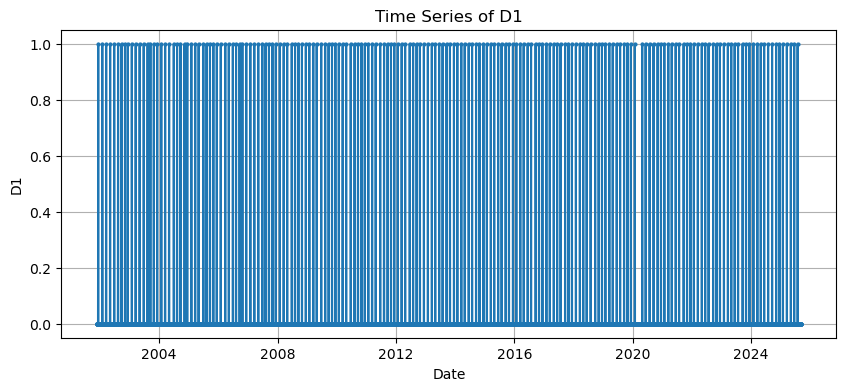

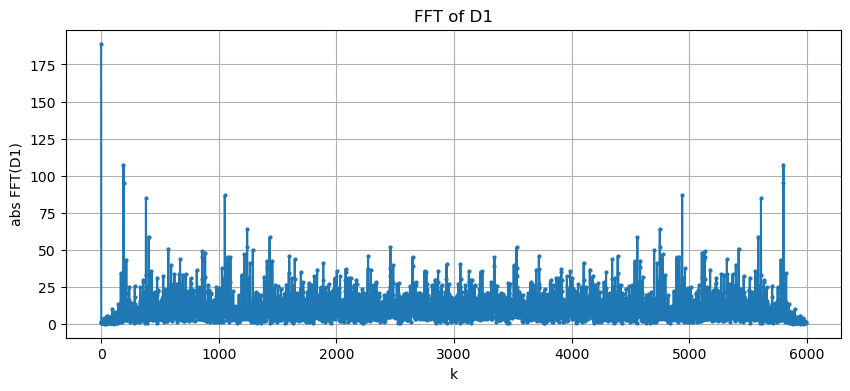

Top 10 frequencies for D1:
  k=0, abs FFT=188.99999999999997
  k=190, abs FFT=107.48251134002
  k=5800, abs FFT=107.48251134002
  k=191, abs FFT=95.23457506855993
  k=5799, abs FFT=95.23457506855993
  k=1051, abs FFT=86.9412226343355
  k=4939, abs FFT=86.94122263433549
  k=5609, abs FFT=84.66745210248659
  k=381, abs FFT=84.66745210248659
  k=4749, abs FFT=64.11741889144709


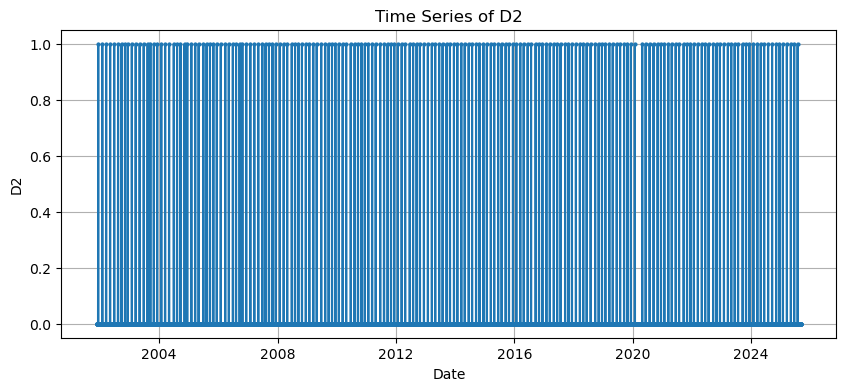

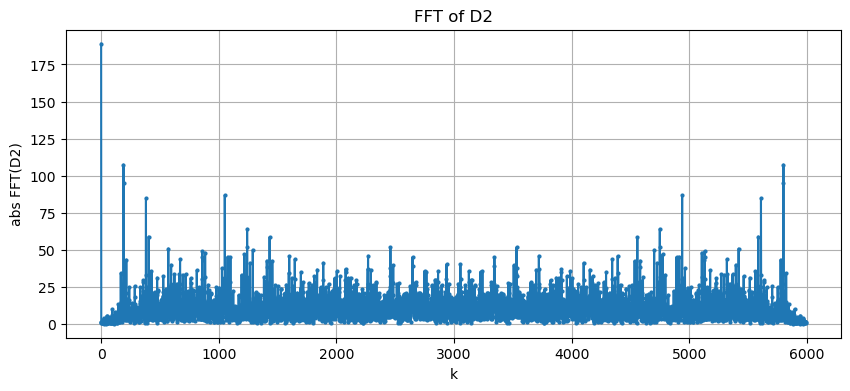

Top 10 frequencies for D2:
  k=0, abs FFT=188.99999999999997
  k=190, abs FFT=107.48251134002
  k=5800, abs FFT=107.48251134002
  k=191, abs FFT=95.23457506855993
  k=5799, abs FFT=95.23457506855993
  k=1051, abs FFT=86.9412226343355
  k=4939, abs FFT=86.94122263433549
  k=5609, abs FFT=84.66745210248659
  k=381, abs FFT=84.66745210248659
  k=4749, abs FFT=64.11741889144709


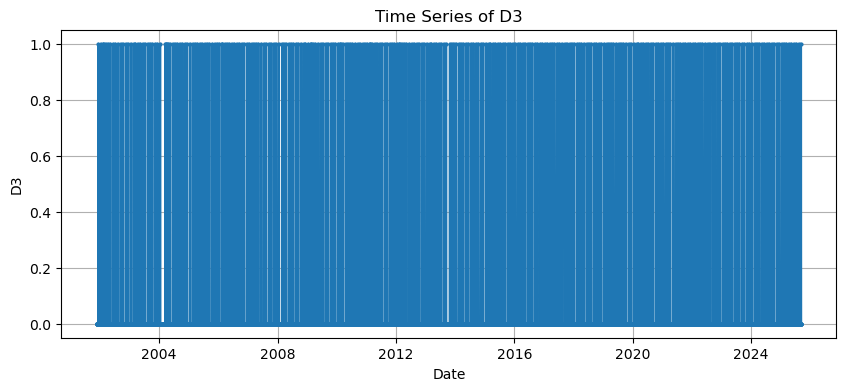

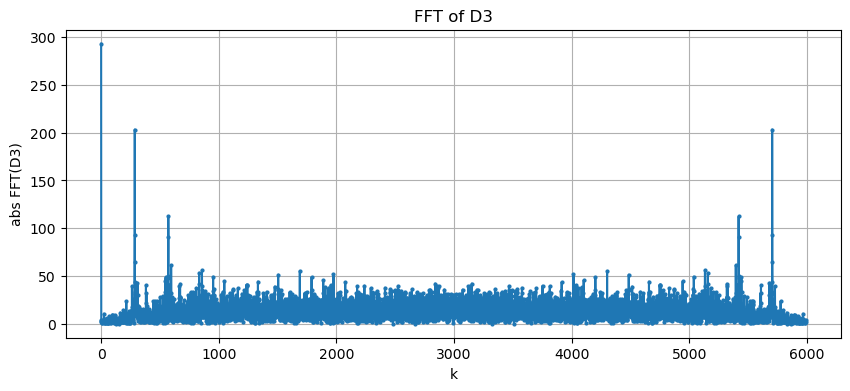

Top 10 frequencies for D3:
  k=0, abs FFT=293.0
  k=5704, abs FFT=203.28501688507563
  k=286, abs FFT=203.28501688507563
  k=5419, abs FFT=112.32841145857542
  k=571, abs FFT=112.32841145857542
  k=5705, abs FFT=92.56128867570987
  k=285, abs FFT=92.56128867570987
  k=572, abs FFT=90.65122958570667
  k=5418, abs FFT=90.65122958570666
  k=284, abs FFT=64.57620126115121


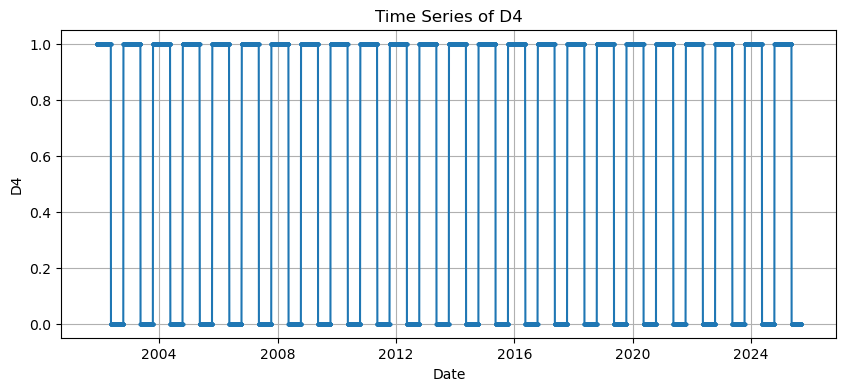

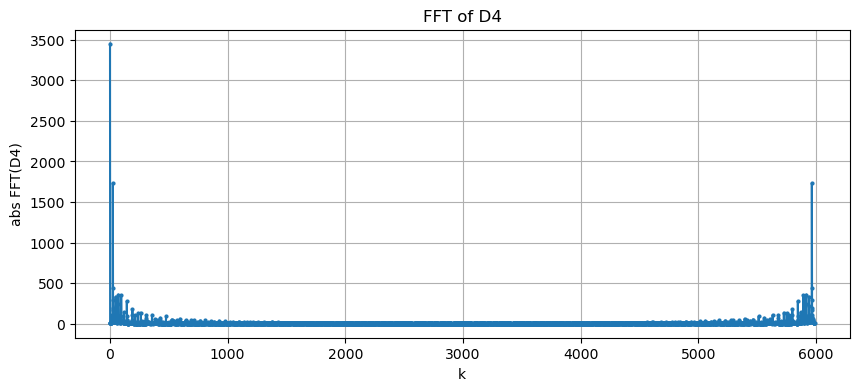

Top 10 frequencies for D4:
  k=0, abs FFT=3451.0
  k=5966, abs FFT=1735.8692821769484
  k=24, abs FFT=1735.8692821769482
  k=5967, abs FFT=434.941904009981
  k=23, abs FFT=434.9419040099809
  k=5919, abs FFT=360.2314302378987
  k=71, abs FFT=360.2314302378986
  k=5895, abs FFT=350.1458548066182
  k=95, abs FFT=350.14585480661816
  k=48, abs FFT=335.0823623092204


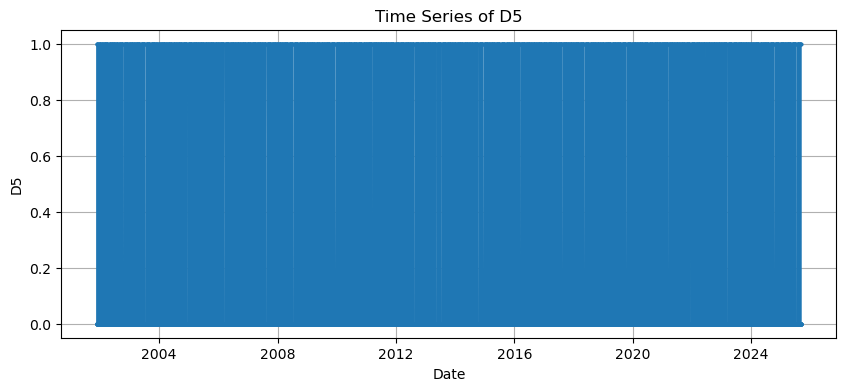

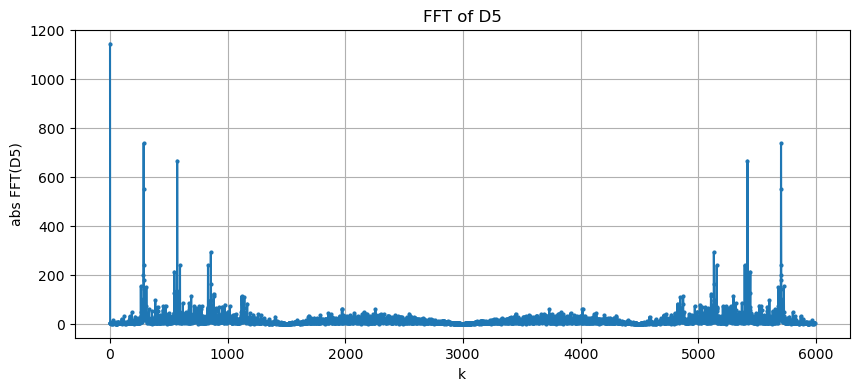

Top 10 frequencies for D5:
  k=0, abs FFT=1143.9999999999998
  k=5704, abs FFT=737.5418001853196
  k=286, abs FFT=737.5418001853195
  k=5419, abs FFT=666.4688569917344
  k=571, abs FFT=666.4688569917344
  k=285, abs FFT=552.3649586816279
  k=5705, abs FFT=552.3649586816279
  k=5133, abs FFT=293.23484106353175
  k=857, abs FFT=293.23484106353175
  k=5703, abs FFT=240.81420822979348


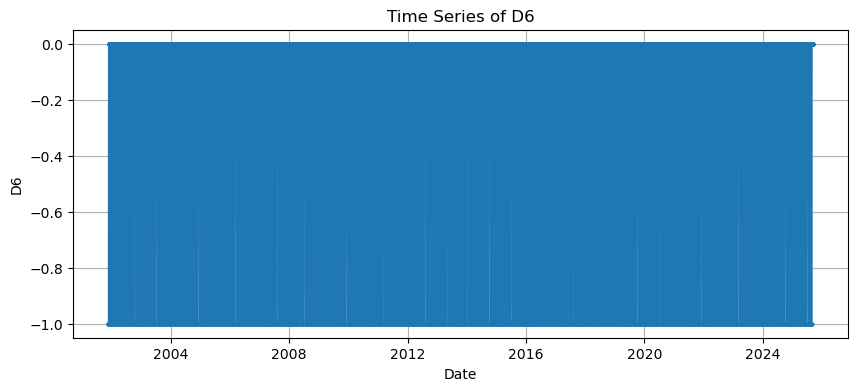

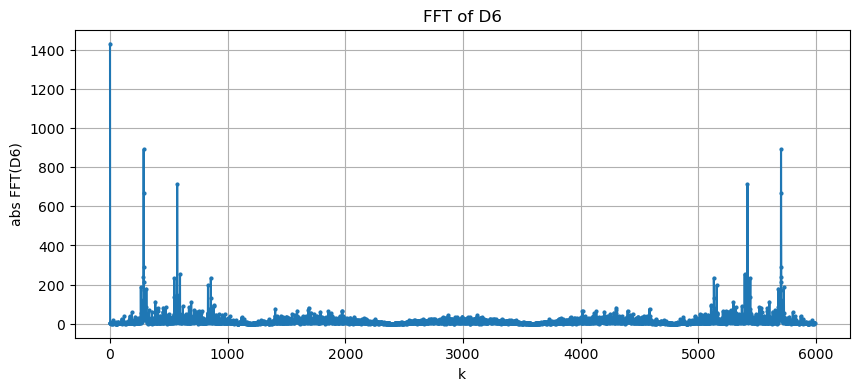

Top 10 frequencies for D6:
  k=0, abs FFT=1429.9999999999998
  k=286, abs FFT=890.3638727707904
  k=5704, abs FFT=890.3638727707903
  k=5419, abs FFT=713.7239863198064
  k=571, abs FFT=713.7239863198063
  k=285, abs FFT=666.9849692268363
  k=5705, abs FFT=666.9849692268363
  k=5703, abs FFT=290.6387579088975
  k=287, abs FFT=290.6387579088975
  k=5395, abs FFT=252.12935610452928


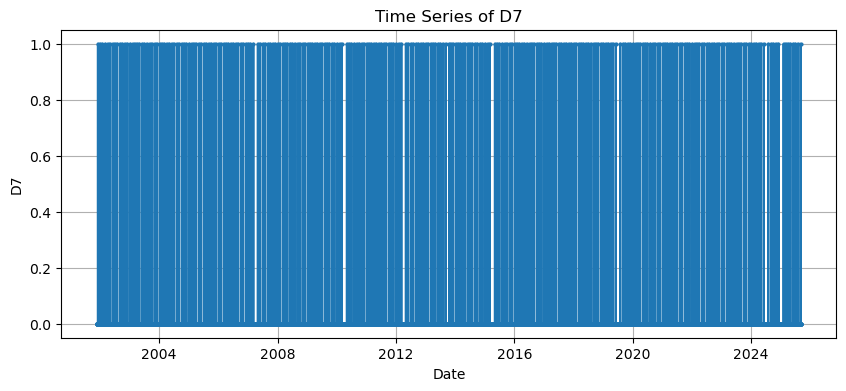

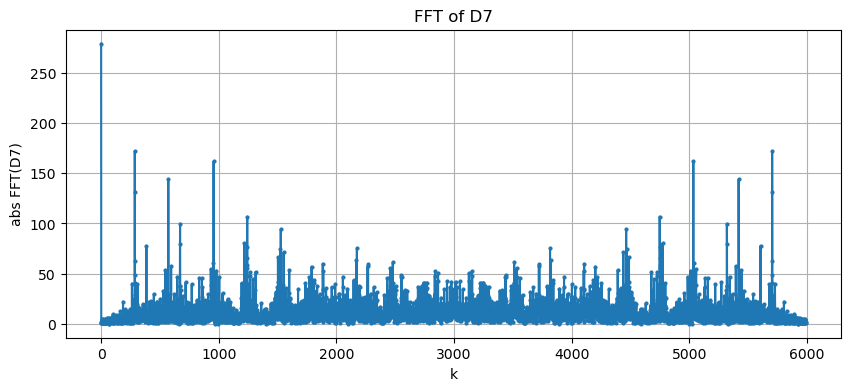

Top 10 frequencies for D7:
  k=0, abs FFT=278.99999999999994
  k=286, abs FFT=172.12153462151224
  k=5704, abs FFT=172.12153462151224
  k=5034, abs FFT=161.8169904445058
  k=956, abs FFT=161.81699044450576
  k=5419, abs FFT=143.94967931455437
  k=571, abs FFT=143.94967931455434
  k=285, abs FFT=130.8824409072538
  k=5705, abs FFT=130.88244090725377
  k=1242, abs FFT=106.74909493594335


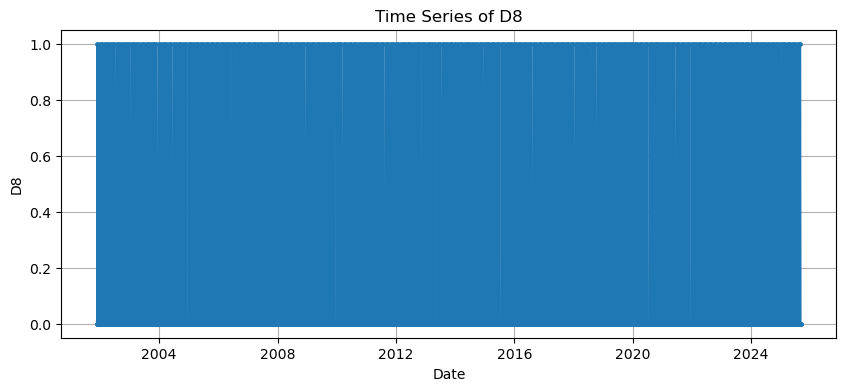

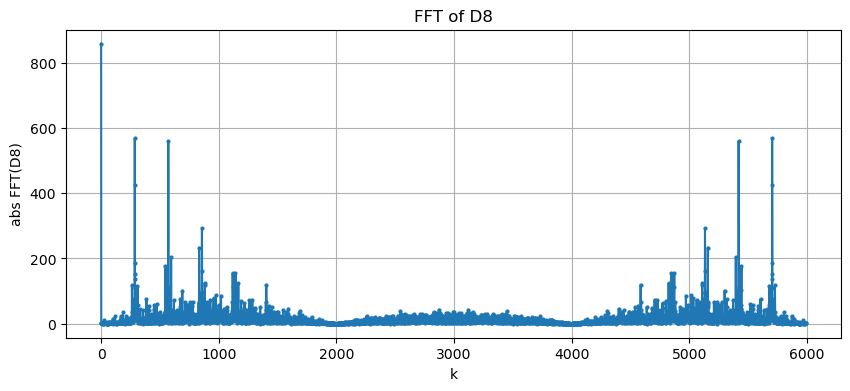

Top 10 frequencies for D8:
  k=0, abs FFT=858.0
  k=5704, abs FFT=568.1562944538575
  k=286, abs FFT=568.1562944538575
  k=571, abs FFT=559.8870605533673
  k=5419, abs FFT=559.8870605533673
  k=5705, abs FFT=425.42657996528885
  k=285, abs FFT=425.42657996528874
  k=5133, abs FFT=293.5514252146351
  k=857, abs FFT=293.551425214635
  k=5157, abs FFT=233.55003689658335


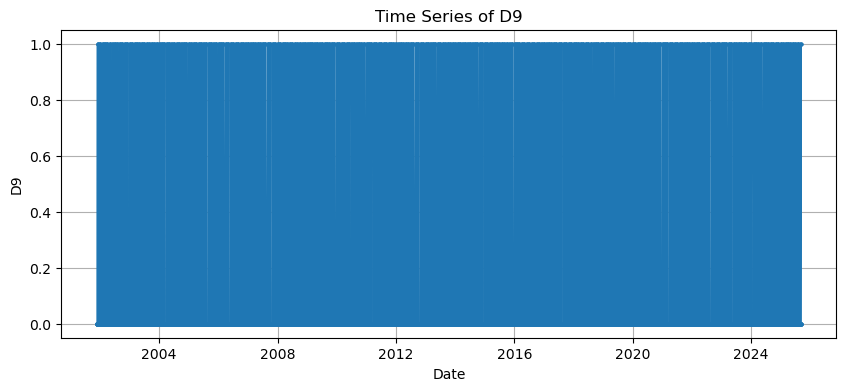

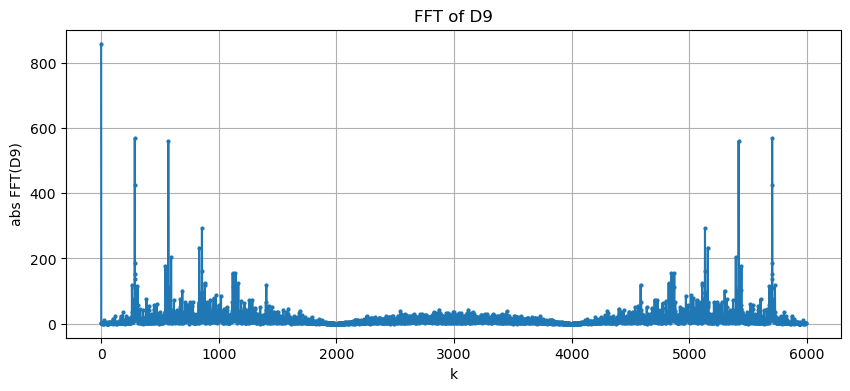

Top 10 frequencies for D9:
  k=0, abs FFT=857.9999999999998
  k=286, abs FFT=568.1562944538575
  k=5704, abs FFT=568.1562944538575
  k=571, abs FFT=559.8870605533675
  k=5419, abs FFT=559.8870605533673
  k=285, abs FFT=425.42657996528885
  k=5705, abs FFT=425.42657996528874
  k=857, abs FFT=293.55142521463506
  k=5133, abs FFT=293.55142521463506
  k=5157, abs FFT=233.5500368965834


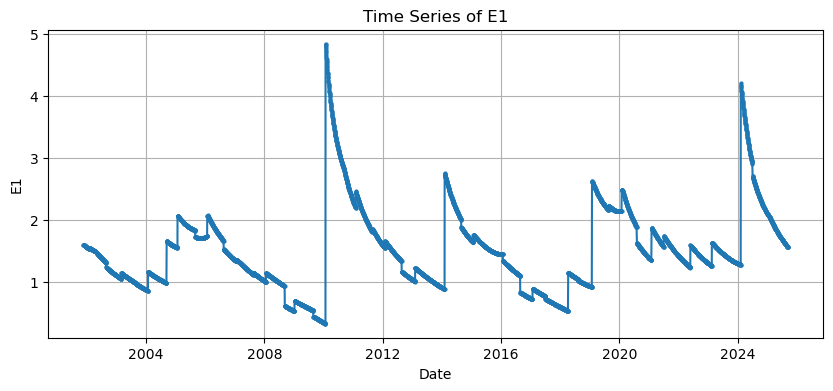

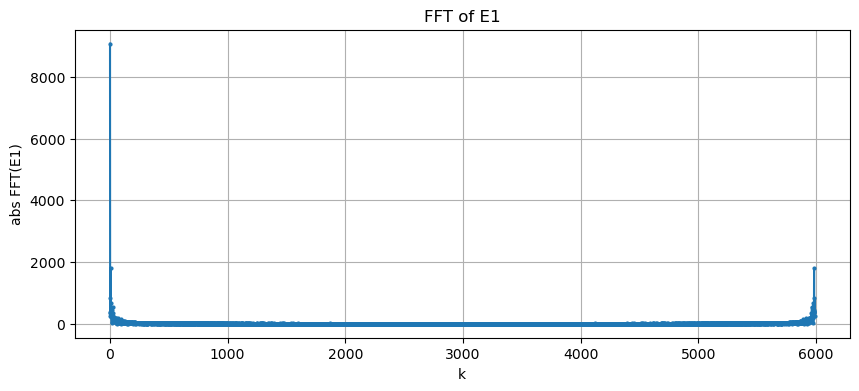

Top 10 frequencies for E1:
  k=0, abs FFT=9076.053192873282
  k=5, abs FFT=1800.3394279671397
  k=5985, abs FFT=1800.3394279671397
  k=2, abs FFT=843.2695227641735
  k=5988, abs FFT=843.2695227641734
  k=5980, abs FFT=658.6591015971517
  k=10, abs FFT=658.6591015971516
  k=24, abs FFT=537.8918965745038
  k=5966, abs FFT=537.8918965745038
  k=12, abs FFT=495.6147179328881


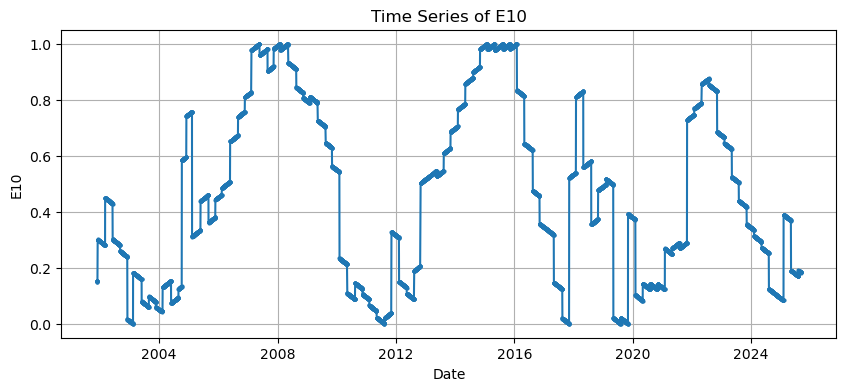

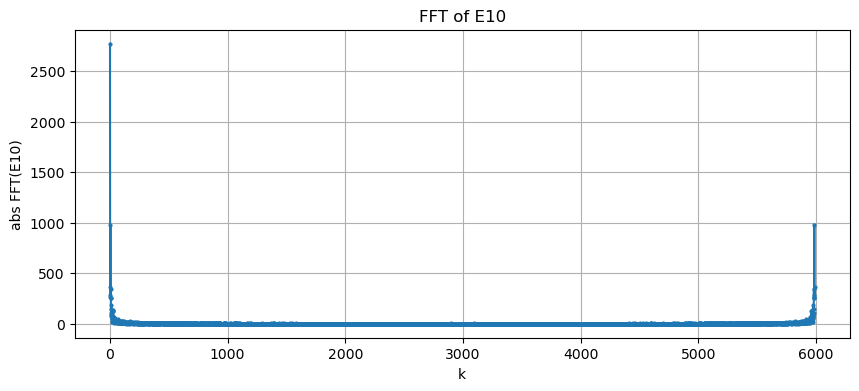

Top 10 frequencies for E10:
  k=0, abs FFT=2773.614748677248
  k=3, abs FFT=982.7106806242574
  k=5987, abs FFT=982.7106806242573
  k=1, abs FFT=364.3602148297828
  k=5989, abs FFT=364.3602148297827
  k=5983, abs FFT=346.78465803344966
  k=7, abs FFT=346.78465803344966
  k=4, abs FFT=288.67097611983894
  k=5986, abs FFT=288.67097611983877
  k=2, abs FFT=264.1191917237625


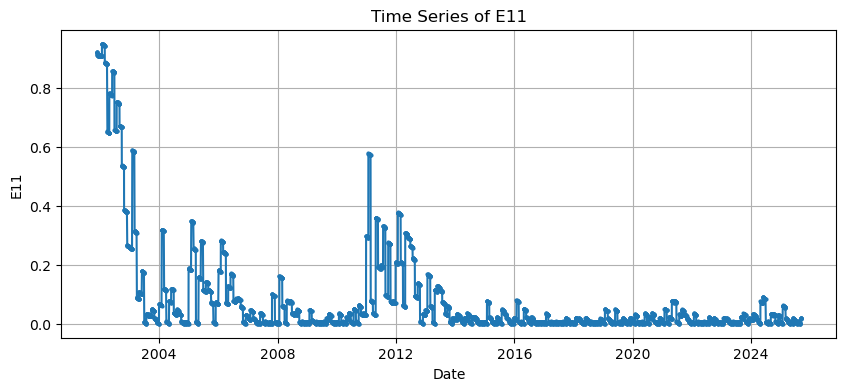

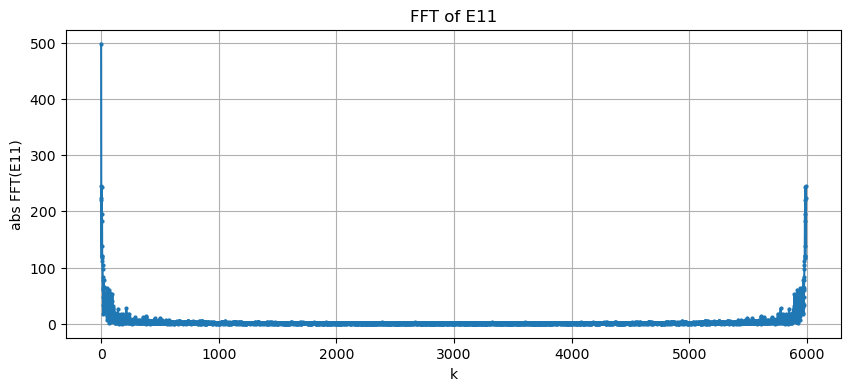

Top 10 frequencies for E11:
  k=0, abs FFT=498.33068783068774
  k=2, abs FFT=245.12996433086252
  k=5988, abs FFT=245.1299643308625
  k=5985, abs FFT=242.8105703288602
  k=5, abs FFT=242.81057032886017
  k=5989, abs FFT=223.10430131572969
  k=1, abs FFT=223.10430131572969
  k=5987, abs FFT=220.39220994936576
  k=3, abs FFT=220.39220994936576
  k=7, abs FFT=194.7419392139989


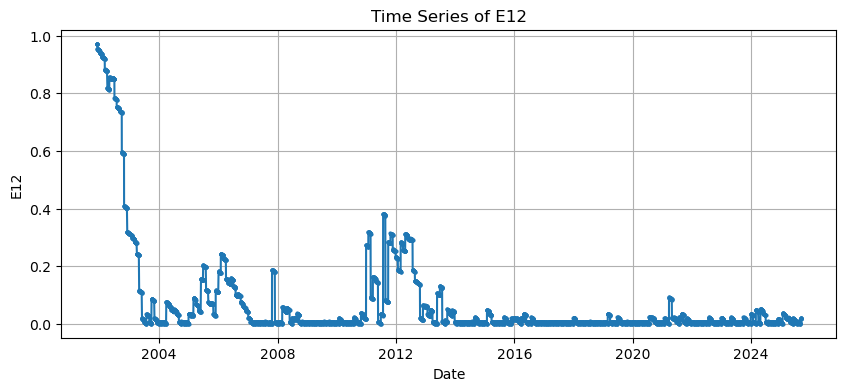

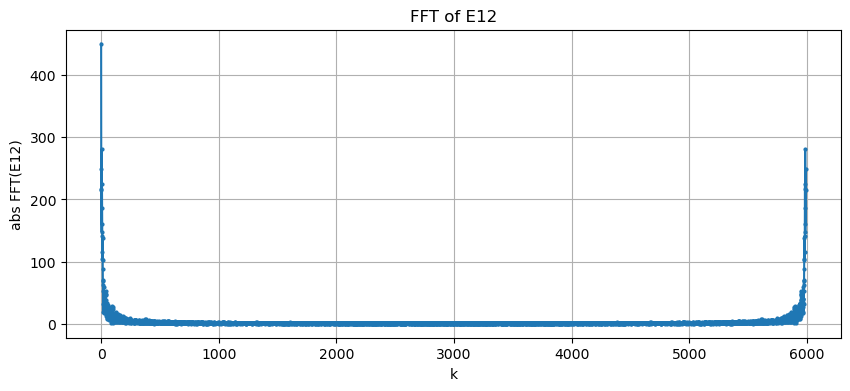

Top 10 frequencies for E12:
  k=0, abs FFT=450.45171957671954
  k=5, abs FFT=280.62590185038414
  k=5985, abs FFT=280.62590185038414
  k=5988, abs FFT=249.71520852482766
  k=2, abs FFT=249.71520852482766
  k=5983, abs FFT=224.75489305452132
  k=7, abs FFT=224.75489305452132
  k=5987, abs FFT=216.8062323524361
  k=3, abs FFT=216.8062323524361
  k=1, abs FFT=214.8337632088079


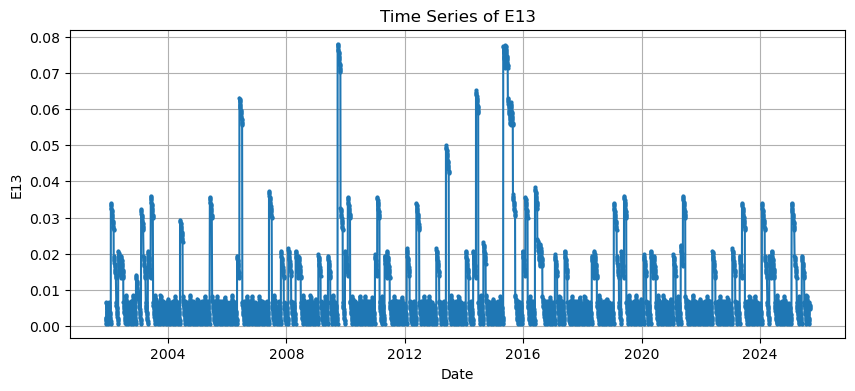

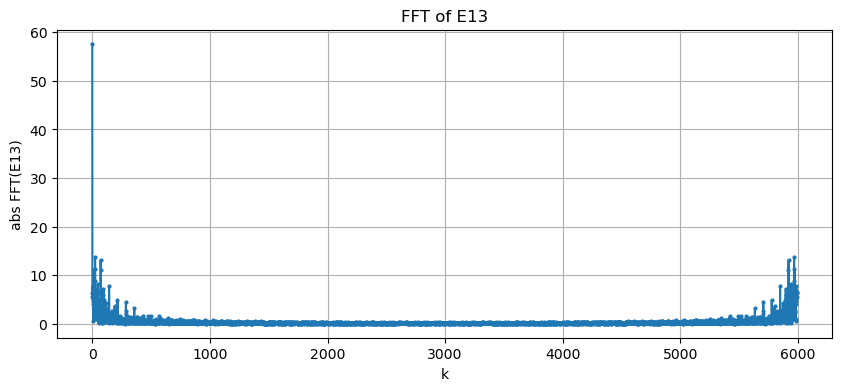

Top 10 frequencies for E13:
  k=0, abs FFT=57.634589947089935
  k=5966, abs FFT=13.644307291139766
  k=24, abs FFT=13.644307291139764
  k=5919, abs FFT=13.118949838466692
  k=71, abs FFT=13.118949838466692
  k=5969, abs FFT=11.339521549425818
  k=21, abs FFT=11.339521549425818
  k=5918, abs FFT=11.014436317479671
  k=72, abs FFT=11.014436317479671
  k=25, abs FFT=8.699645501713098


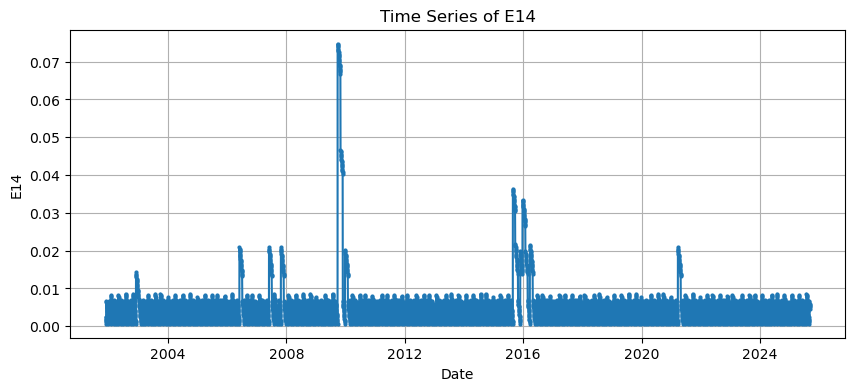

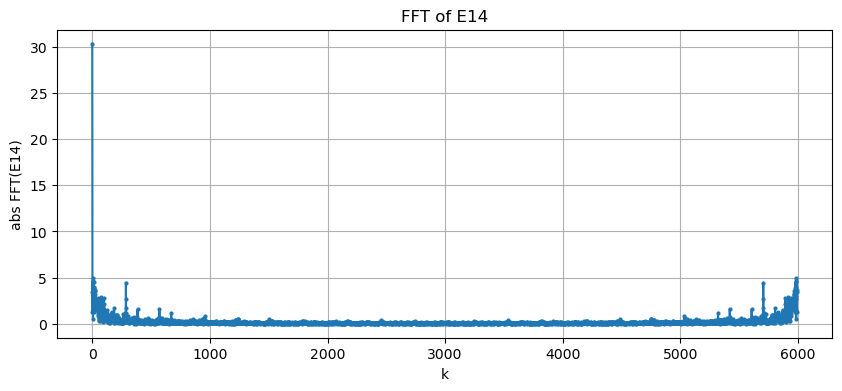

Top 10 frequencies for E14:
  k=0, abs FFT=30.347552910052904
  k=8, abs FFT=4.916353494946849
  k=5982, abs FFT=4.916353494946848
  k=4, abs FFT=4.617162310433336
  k=5986, abs FFT=4.617162310433336
  k=12, abs FFT=4.493865967384173
  k=5978, abs FFT=4.493865967384173
  k=286, abs FFT=4.454927120830229
  k=5704, abs FFT=4.454927120830229
  k=11, abs FFT=3.9947210863006846


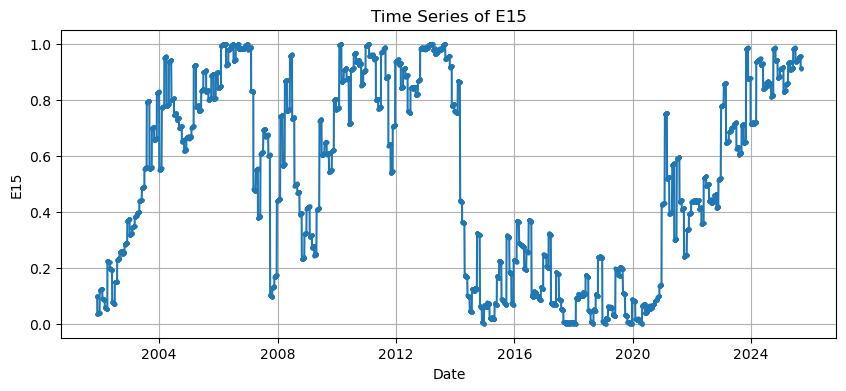

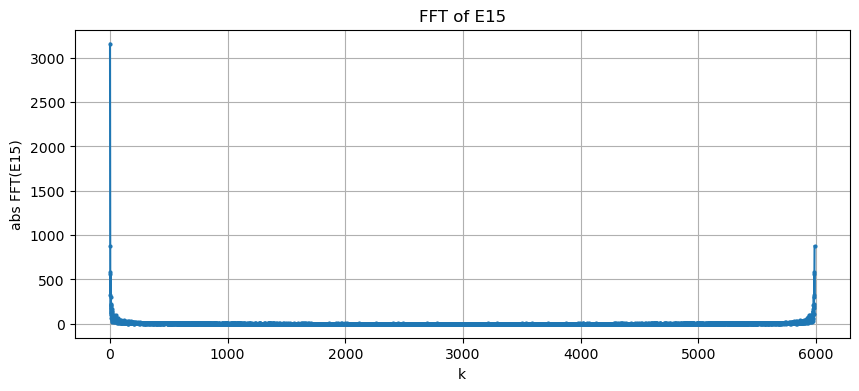

Top 10 frequencies for E15:
  k=0, abs FFT=3158.966931216931
  k=5989, abs FFT=875.884163060803
  k=1, abs FFT=875.8841630608028
  k=2, abs FFT=580.8389910977758
  k=5988, abs FFT=580.8389910977755
  k=5986, abs FFT=557.1480723479267
  k=4, abs FFT=557.1480723479266
  k=5987, abs FFT=321.3087830288156
  k=3, abs FFT=321.3087830288156
  k=5982, abs FFT=306.00897591933966


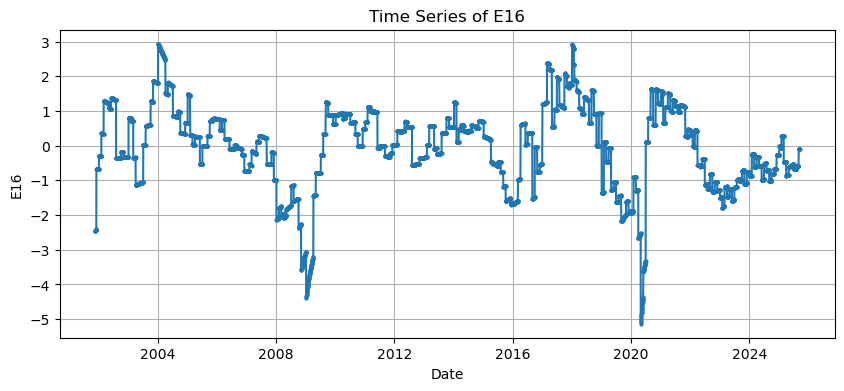

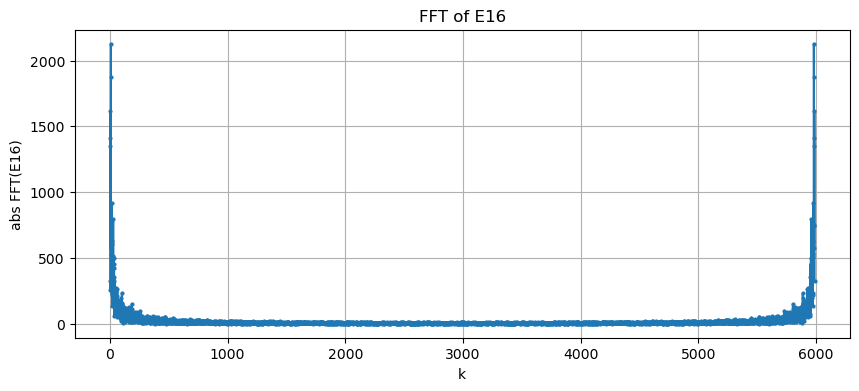

Top 10 frequencies for E16:
  k=5983, abs FFT=2128.2107597305726
  k=7, abs FFT=2128.2107597305726
  k=6, abs FFT=1874.9818527692241
  k=5984, abs FFT=1874.981852769224
  k=3, abs FFT=1618.6149074517473
  k=5987, abs FFT=1618.6149074517473
  k=5988, abs FFT=1414.2253304550943
  k=2, abs FFT=1414.225330455094
  k=5986, abs FFT=1348.4189331591754
  k=4, abs FFT=1348.4189331591754


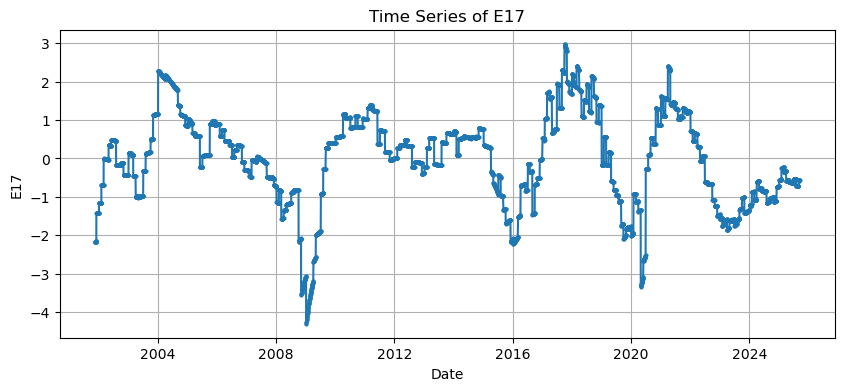

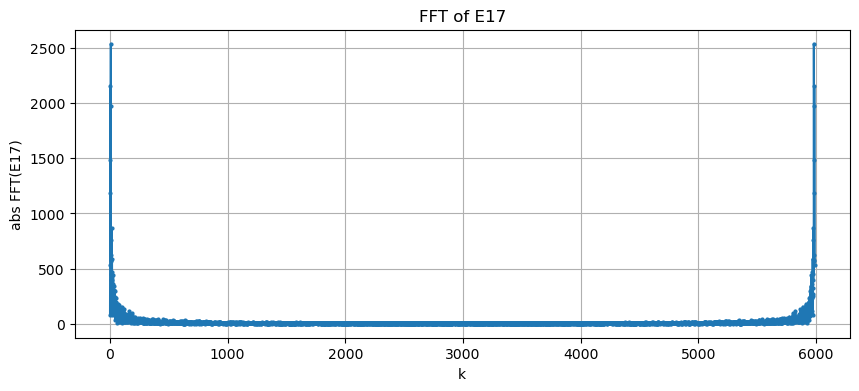

Top 10 frequencies for E17:
  k=7, abs FFT=2539.2349507120607
  k=5983, abs FFT=2539.2349507120603
  k=3, abs FFT=2159.784891470048
  k=5987, abs FFT=2159.7848914700476
  k=6, abs FFT=1977.5501199488247
  k=5984, abs FFT=1977.5501199488247
  k=5986, abs FFT=1488.7297400834668
  k=4, abs FFT=1488.7297400834666
  k=5988, abs FFT=1185.1276448525423
  k=2, abs FFT=1185.127644852542


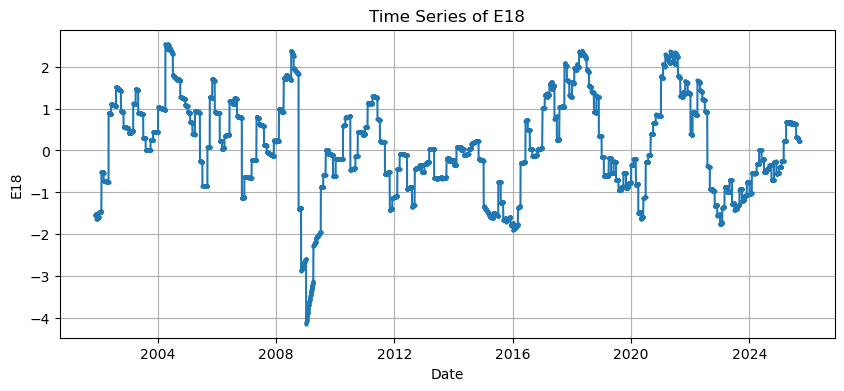

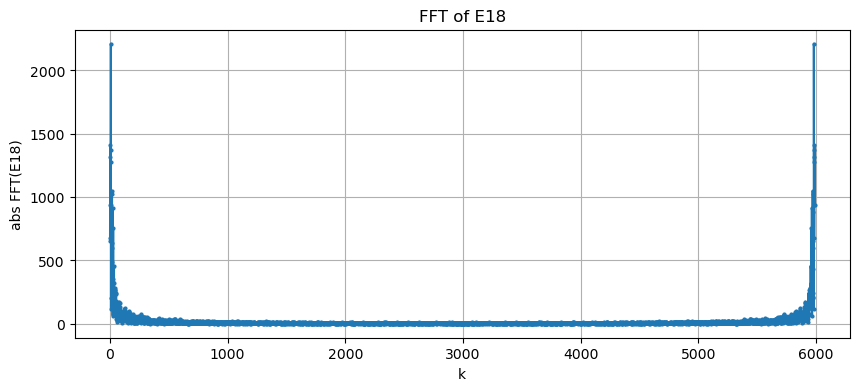

Top 10 frequencies for E18:
  k=5983, abs FFT=2211.430592561867
  k=7, abs FFT=2211.4305925618664
  k=2, abs FFT=1409.1201549144218
  k=5988, abs FFT=1409.1201549144218
  k=5985, abs FFT=1373.218183422946
  k=5, abs FFT=1373.218183422946
  k=3, abs FFT=1312.8953173262548
  k=5987, abs FFT=1312.8953173262546
  k=5984, abs FFT=1279.3240868473176
  k=6, abs FFT=1279.3240868473174


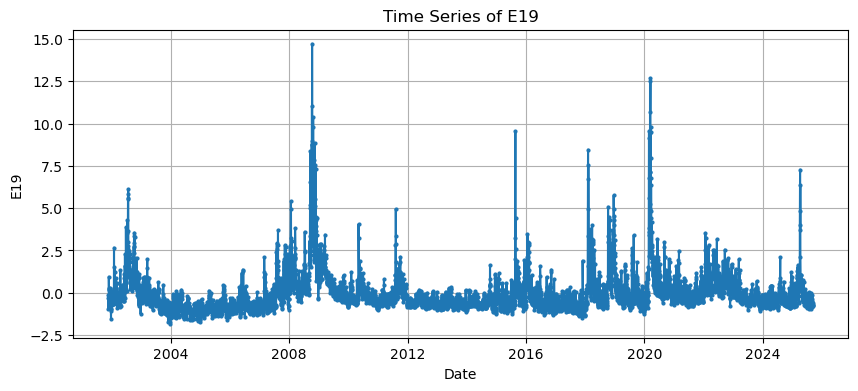

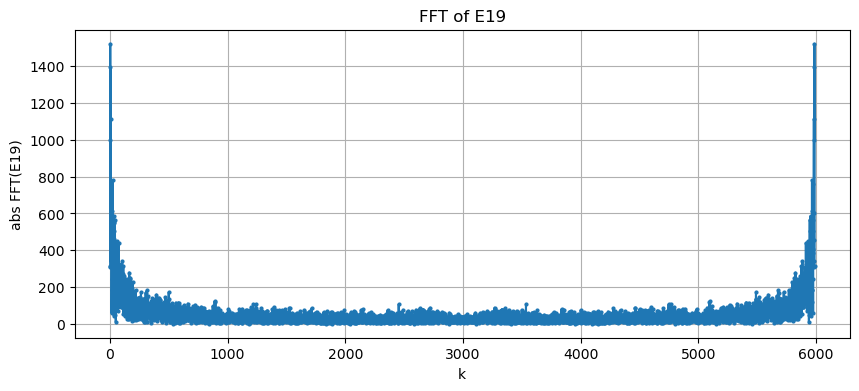

Top 10 frequencies for E19:
  k=5988, abs FFT=1522.5039015591917
  k=2, abs FFT=1522.5039015591915
  k=4, abs FFT=1394.3277617858337
  k=5986, abs FFT=1394.3277617858337
  k=7, abs FFT=1111.675758467248
  k=5983, abs FFT=1111.6757584672478
  k=3, abs FFT=1000.9294594549061
  k=5987, abs FFT=1000.929459454906
  k=23, abs FFT=782.6737490100456
  k=5967, abs FFT=782.6737490100455


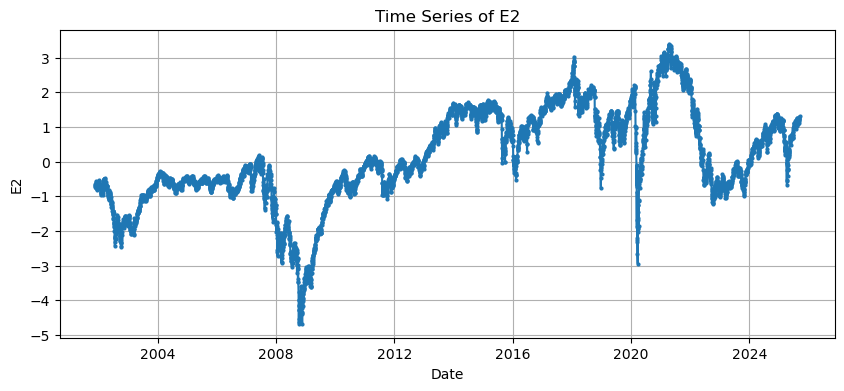

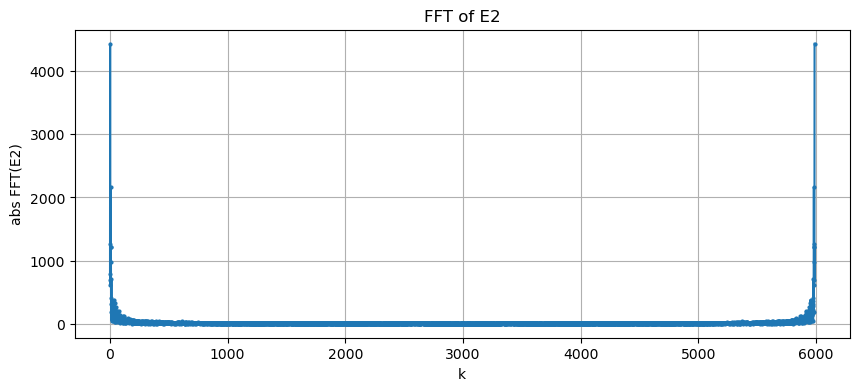

Top 10 frequencies for E2:
  k=1, abs FFT=4435.413352677736
  k=5989, abs FFT=4435.413352677736
  k=5983, abs FFT=2165.1338283261416
  k=7, abs FFT=2165.1338283261416
  k=5987, abs FFT=1260.5845471387527
  k=3, abs FFT=1260.5845471387524
  k=6, abs FFT=1212.3773031885557
  k=5984, abs FFT=1212.3773031885555
  k=5985, abs FFT=1208.3601179206637
  k=5, abs FFT=1208.3601179206635


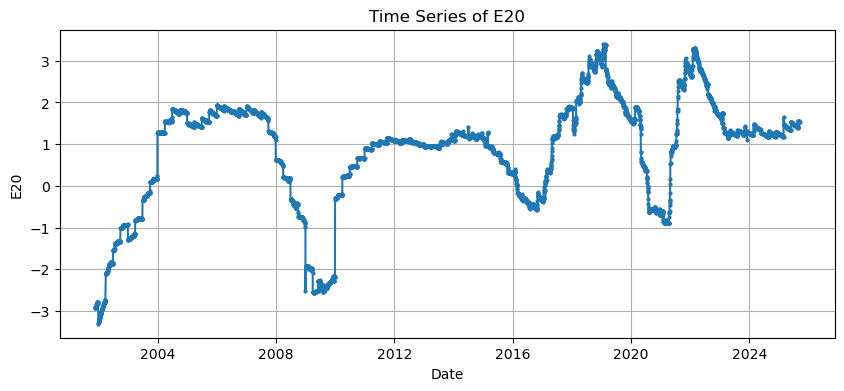

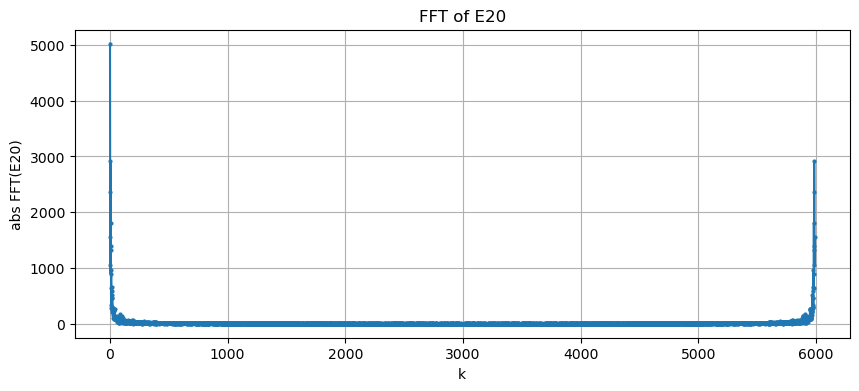

Top 10 frequencies for E20:
  k=0, abs FFT=5020.13198019282
  k=5986, abs FFT=2915.8392937033136
  k=4, abs FFT=2915.839293703313
  k=3, abs FFT=2369.569293812293
  k=5987, abs FFT=2369.569293812292
  k=7, abs FFT=1801.6187304225507
  k=5983, abs FFT=1801.6187304225502
  k=1, abs FFT=1555.3643317878664
  k=5989, abs FFT=1555.3643317878661
  k=6, abs FFT=1388.467162256686


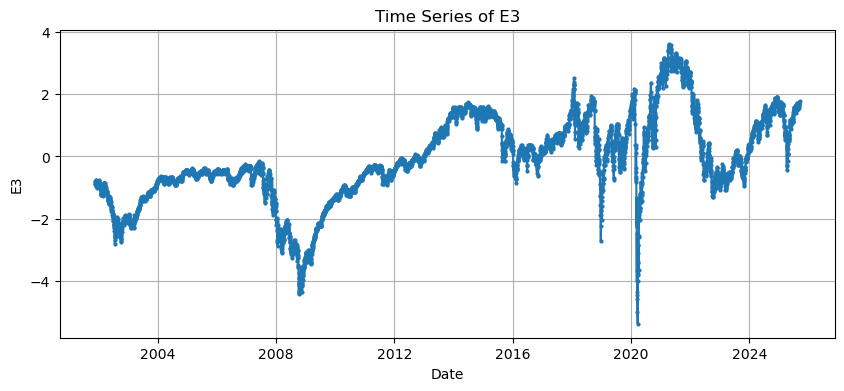

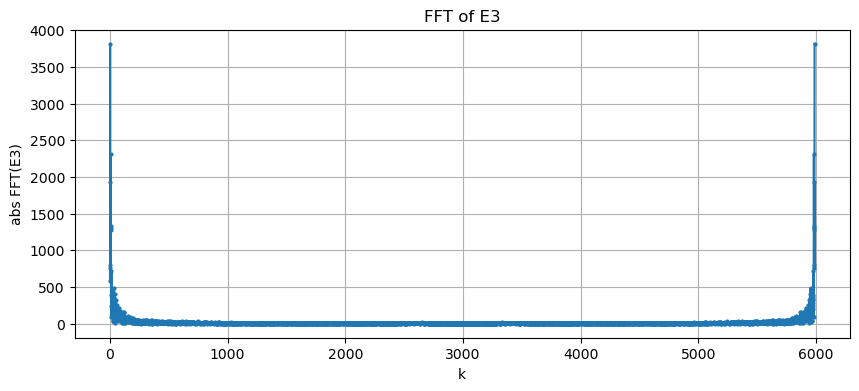

Top 10 frequencies for E3:
  k=1, abs FFT=3814.6968261419092
  k=5989, abs FFT=3814.6968261419092
  k=7, abs FFT=2306.4753633900978
  k=5983, abs FFT=2306.4753633900973
  k=5987, abs FFT=1934.0034307471658
  k=3, abs FFT=1934.0034307471658
  k=5985, abs FFT=1331.7531598695266
  k=5, abs FFT=1331.7531598695266
  k=6, abs FFT=1301.8595614530423
  k=5984, abs FFT=1301.859561453042


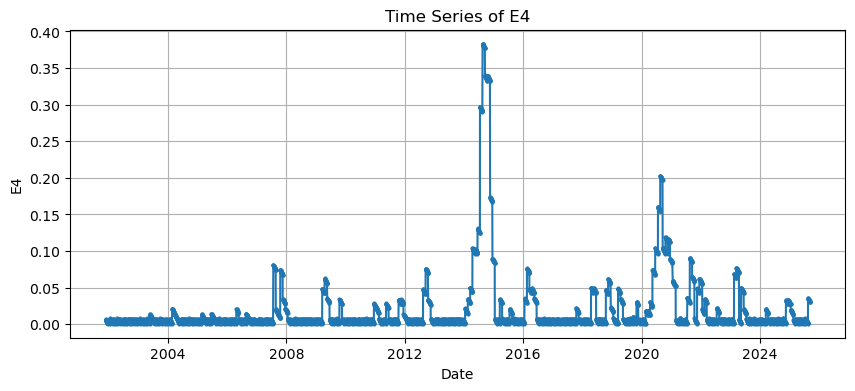

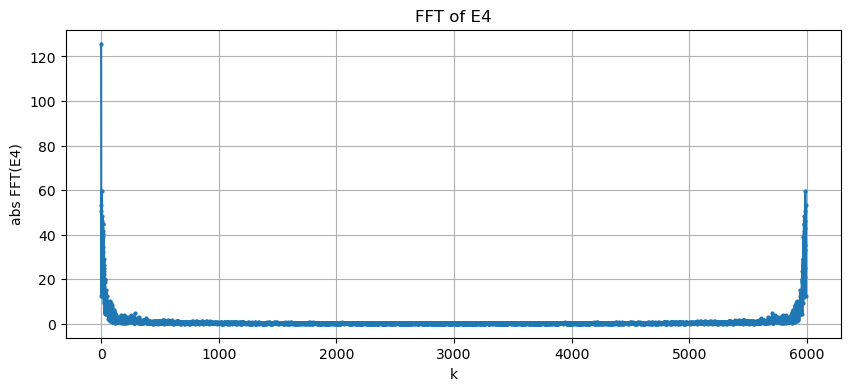

Top 10 frequencies for E4:
  k=0, abs FFT=125.69246031746029
  k=5986, abs FFT=59.35898769341236
  k=4, abs FFT=59.35898769341236
  k=5989, abs FFT=53.11088238302768
  k=1, abs FFT=53.11088238302767
  k=3, abs FFT=50.477790310295234
  k=5987, abs FFT=50.47779031029523
  k=5979, abs FFT=48.53769114303611
  k=11, abs FFT=48.537691143036106
  k=8, abs FFT=46.25021212693897


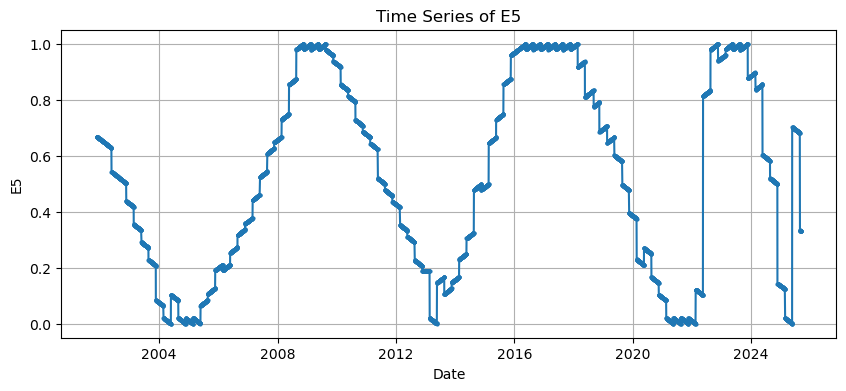

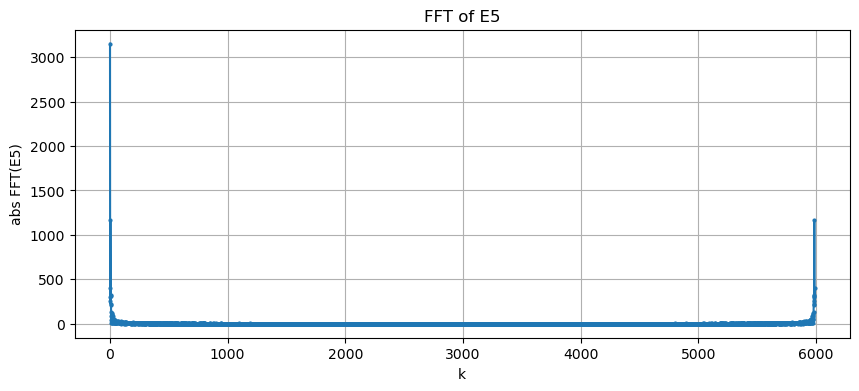

Top 10 frequencies for E5:
  k=0, abs FFT=3151.1673280423274
  k=5987, abs FFT=1165.754767615694
  k=3, abs FFT=1165.754767615694
  k=1, abs FFT=402.91817363459387
  k=5989, abs FFT=402.9181736345938
  k=7, abs FFT=317.66227957098135
  k=5983, abs FFT=317.66227957098124
  k=5984, abs FFT=309.8142670013475
  k=6, abs FFT=309.8142670013474
  k=5986, abs FFT=302.2399235030023


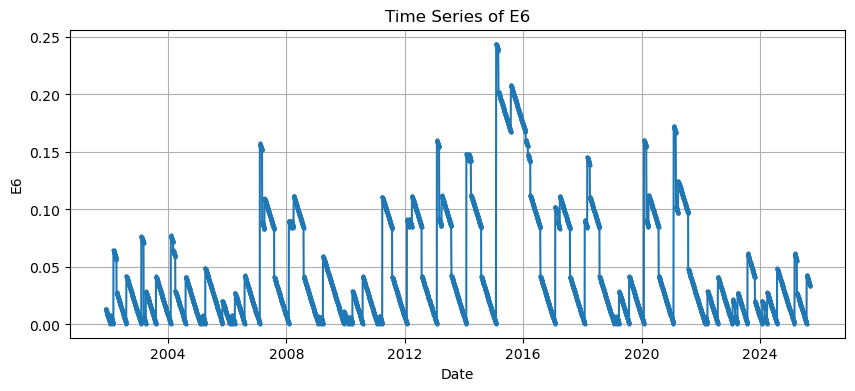

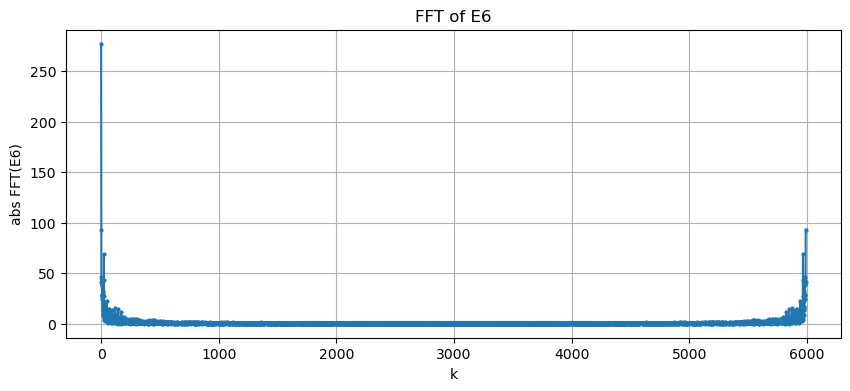

Top 10 frequencies for E6:
  k=0, abs FFT=277.23875661375655
  k=1, abs FFT=93.15537857811444
  k=5989, abs FFT=93.15537857811441
  k=5966, abs FFT=69.32645110763175
  k=24, abs FFT=69.32645110763174
  k=3, abs FFT=46.12149805398047
  k=5987, abs FFT=46.12149805398046
  k=23, abs FFT=43.728662645528225
  k=5967, abs FFT=43.72866264552822
  k=5981, abs FFT=42.56186398003205


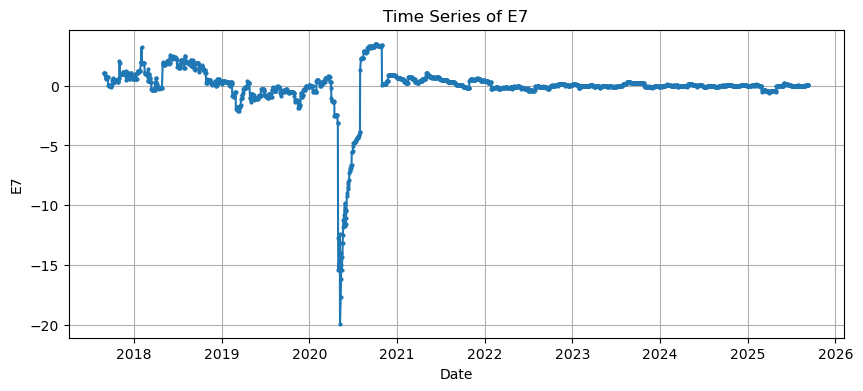

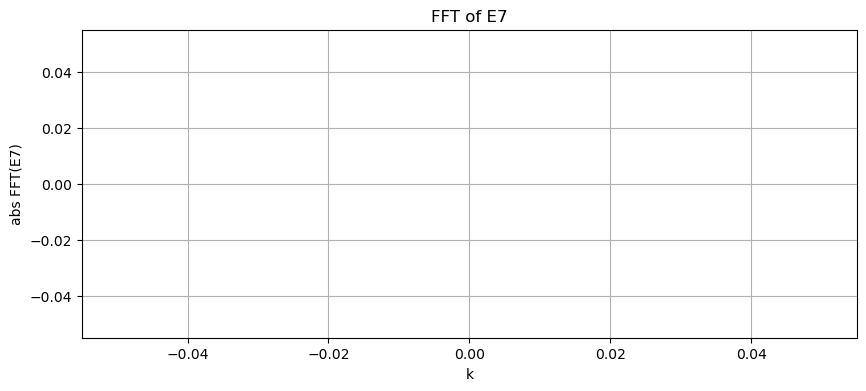

Top 10 frequencies for E7:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


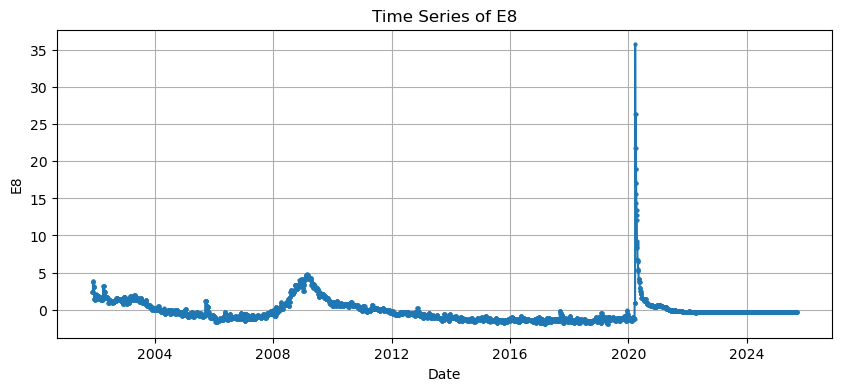

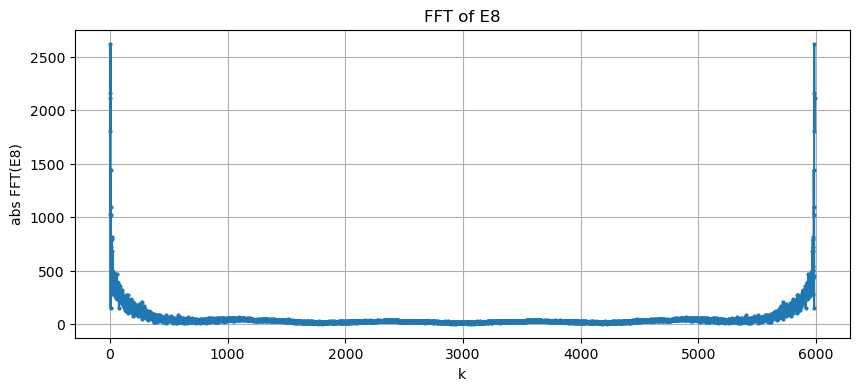

Top 10 frequencies for E8:
  k=4, abs FFT=2623.070380214872
  k=5986, abs FFT=2623.0703802148714
  k=5988, abs FFT=2165.5372821860733
  k=2, abs FFT=2165.5372821860724
  k=1, abs FFT=2111.962985917933
  k=5989, abs FFT=2111.9629859179327
  k=5987, abs FFT=1806.4967016730614
  k=3, abs FFT=1806.4967016730611
  k=8, abs FFT=1438.7349550913923
  k=5982, abs FFT=1438.7349550913923


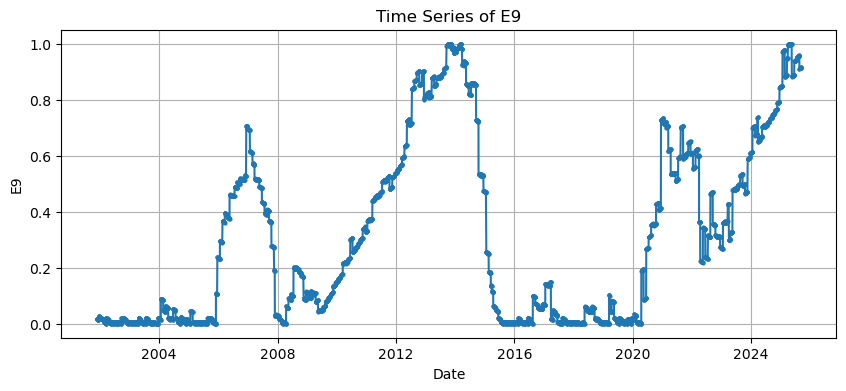

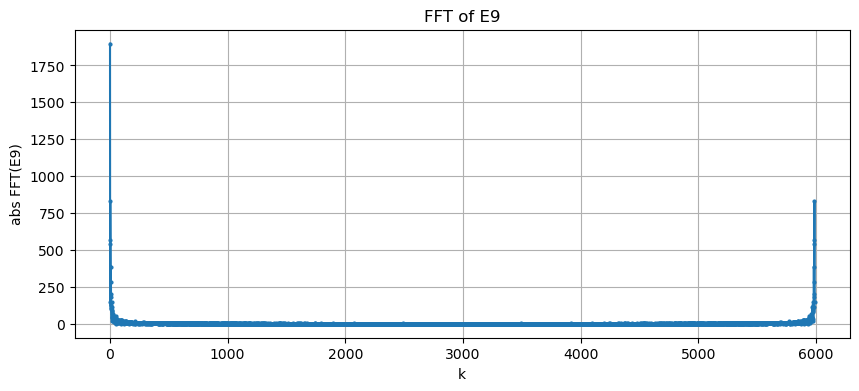

Top 10 frequencies for E9:
  k=0, abs FFT=1897.545304232804
  k=2, abs FFT=831.9873568145381
  k=5988, abs FFT=831.9873568145381
  k=3, abs FFT=569.1825180096318
  k=5987, abs FFT=569.1825180096318
  k=5986, abs FFT=542.0012401576073
  k=4, abs FFT=542.0012401576073
  k=7, abs FFT=387.3348689483787
  k=5983, abs FFT=387.3348689483786
  k=5984, abs FFT=285.10223042538365


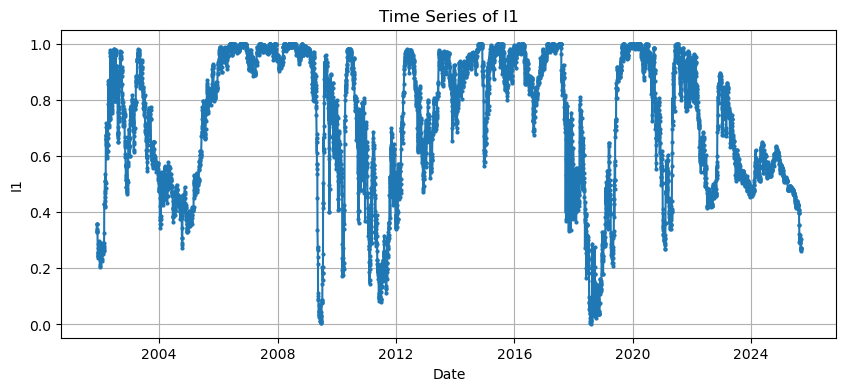

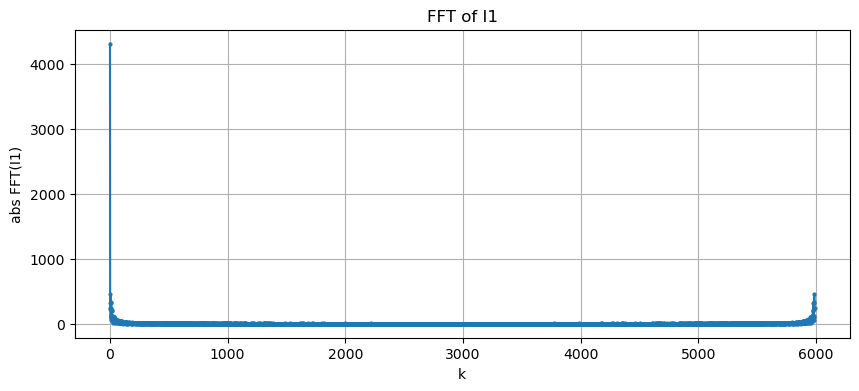

Top 10 frequencies for I1:
  k=0, abs FFT=4316.366071428571
  k=5987, abs FFT=452.61334069528016
  k=3, abs FFT=452.6133406952801
  k=7, abs FFT=339.5779616859374
  k=5983, abs FFT=339.57796168593734
  k=4, abs FFT=326.31368513071726
  k=5986, abs FFT=326.31368513071726
  k=10, abs FFT=322.1048601592948
  k=5980, abs FFT=322.10486015929473
  k=5985, abs FFT=246.85519462024624


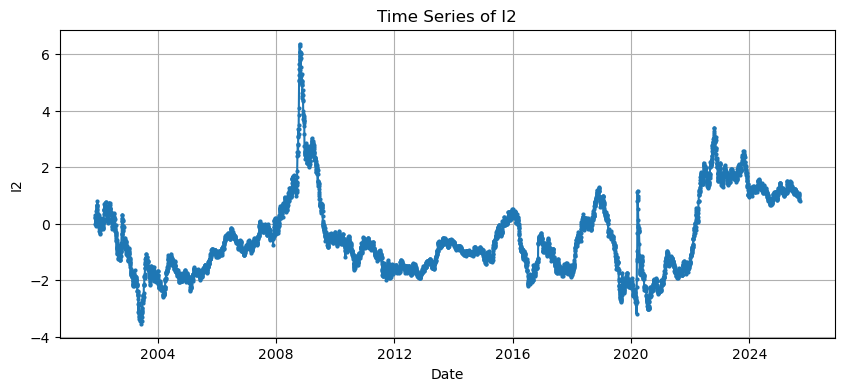

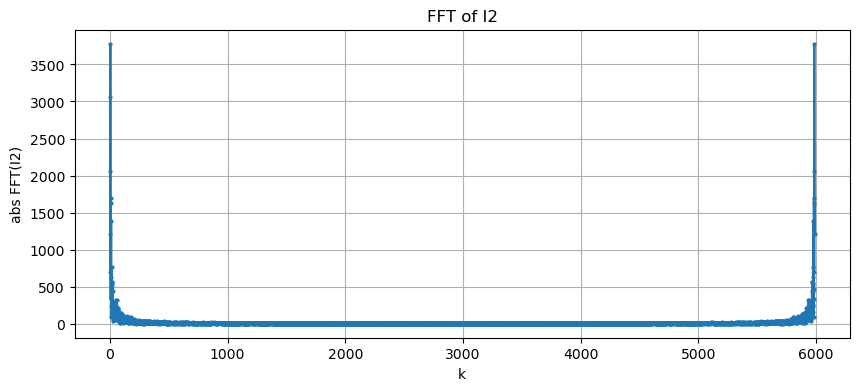

Top 10 frequencies for I2:
  k=3, abs FFT=3779.7792070411815
  k=5987, abs FFT=3779.779207041181
  k=0, abs FFT=3056.772152511555
  k=5988, abs FFT=2059.3373321863946
  k=2, abs FFT=2059.3373321863946
  k=5983, abs FFT=1697.64892436142
  k=7, abs FFT=1697.6489243614199
  k=5, abs FFT=1634.5844222330684
  k=5985, abs FFT=1634.5844222330682
  k=10, abs FFT=1383.0942935642875


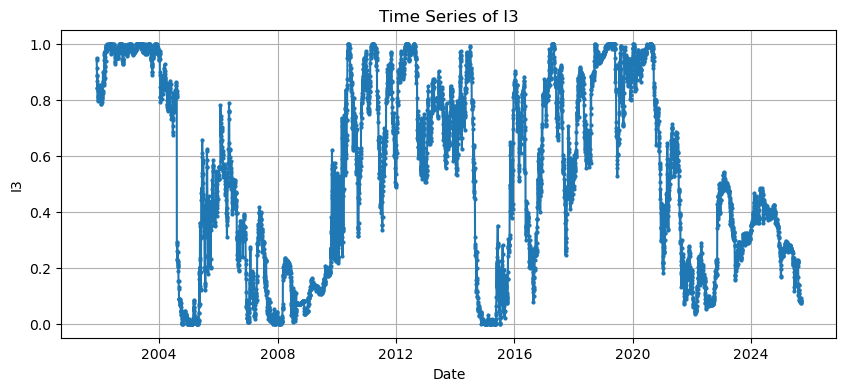

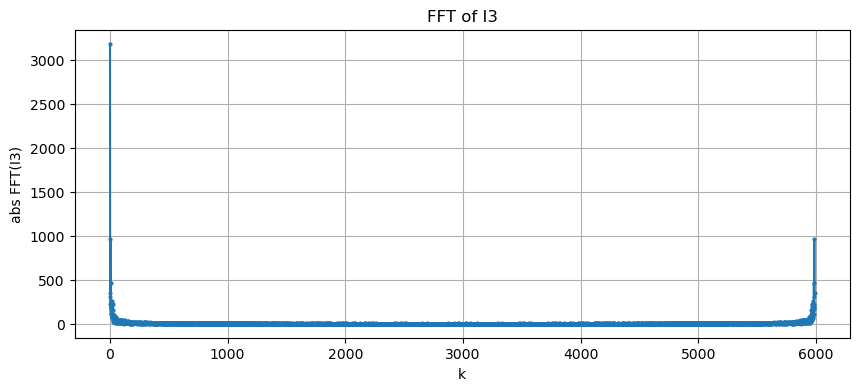

Top 10 frequencies for I3:
  k=0, abs FFT=3187.98115079365
  k=3, abs FFT=962.6538293633487
  k=5987, abs FFT=962.6538293633484
  k=7, abs FFT=459.7109321852068
  k=5983, abs FFT=459.71093218520673
  k=5989, abs FFT=344.5486979065606
  k=1, abs FFT=344.5486979065605
  k=2, abs FFT=299.90159713159466
  k=5988, abs FFT=299.90159713159454
  k=14, abs FFT=258.79356173714916


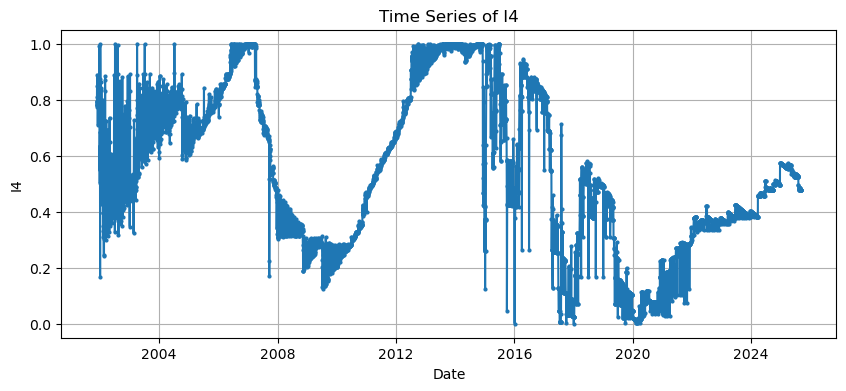

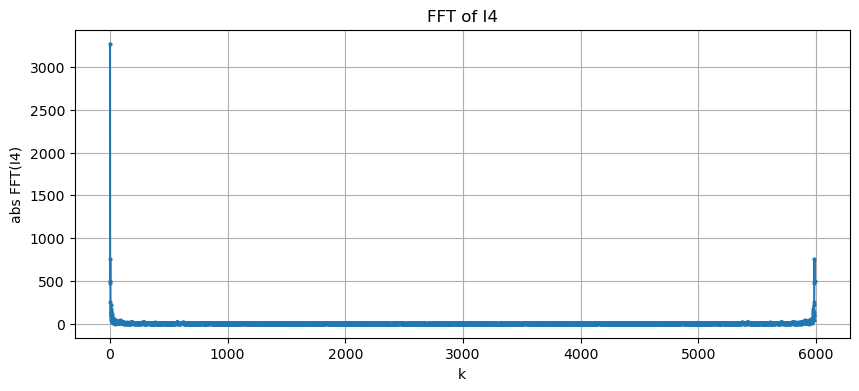

Top 10 frequencies for I4:
  k=0, abs FFT=3270.669642857142
  k=2, abs FFT=753.2744780212557
  k=5988, abs FFT=753.2744780212557
  k=1, abs FFT=493.4703763874759
  k=5989, abs FFT=493.47037638747577
  k=3, abs FFT=478.58478430342836
  k=5987, abs FFT=478.5847843034283
  k=5986, abs FFT=255.43635884232242
  k=4, abs FFT=255.4363588423224
  k=5982, abs FFT=214.0601182370625


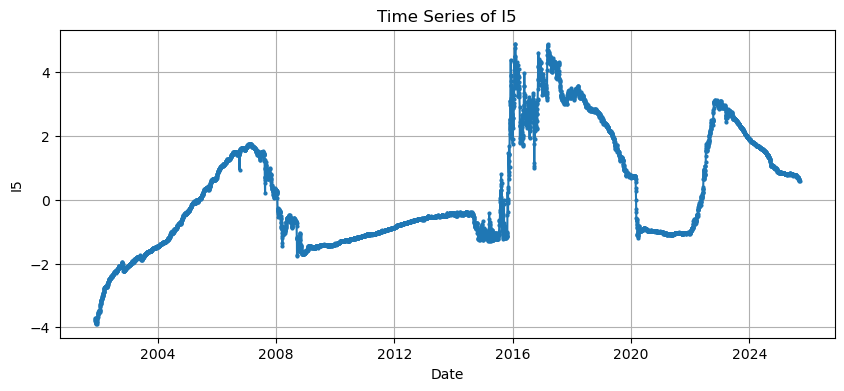

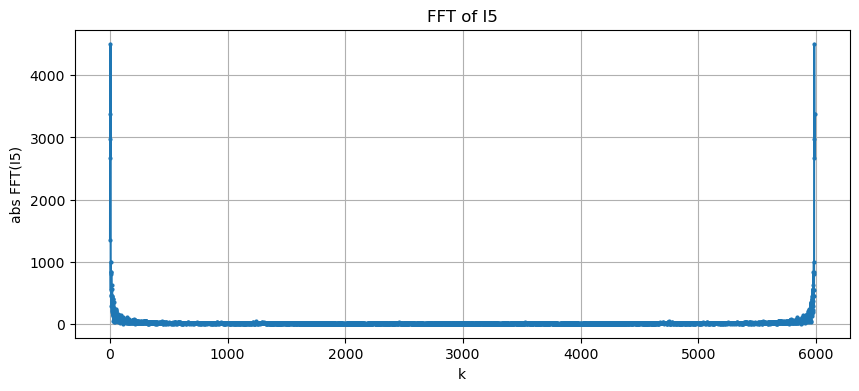

Top 10 frequencies for I5:
  k=4, abs FFT=4508.6824445118555
  k=5986, abs FFT=4508.682444511854
  k=1, abs FFT=3382.1503097722784
  k=5989, abs FFT=3382.150309772278
  k=5987, abs FFT=2967.0979107752532
  k=3, abs FFT=2967.097910775253
  k=2, abs FFT=2668.316279005953
  k=5988, abs FFT=2668.3162790059528
  k=0, abs FFT=1351.8288815818373
  k=7, abs FFT=1000.8928286156513


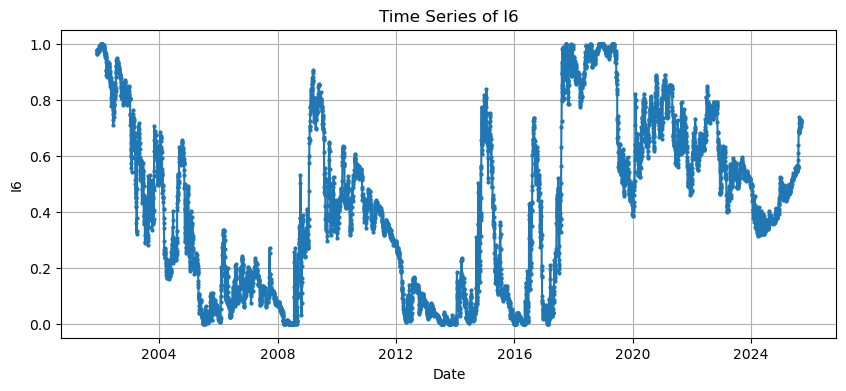

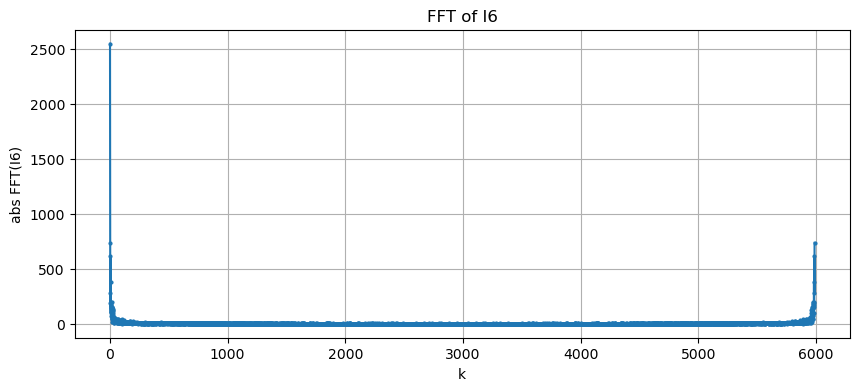

Top 10 frequencies for I6:
  k=0, abs FFT=2550.341931216931
  k=5989, abs FFT=737.0960711832477
  k=1, abs FFT=737.0960711832477
  k=3, abs FFT=617.9789840598538
  k=5987, abs FFT=617.9789840598538
  k=6, abs FFT=382.8879449383359
  k=5984, abs FFT=382.88794493833586
  k=5988, abs FFT=281.7620456534995
  k=2, abs FFT=281.7620456534994
  k=9, abs FFT=202.26388996091097


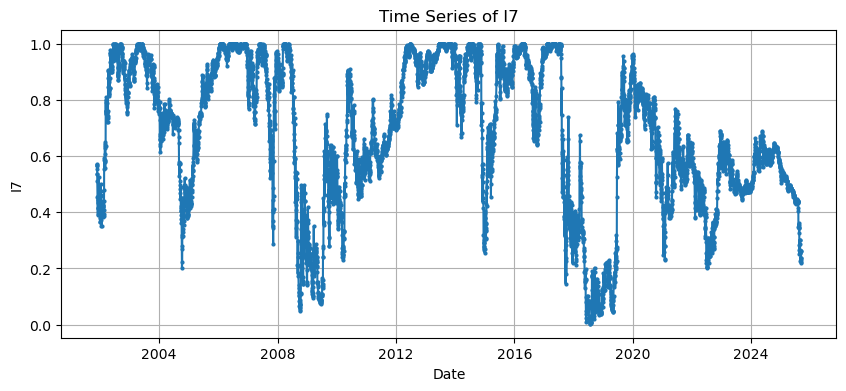

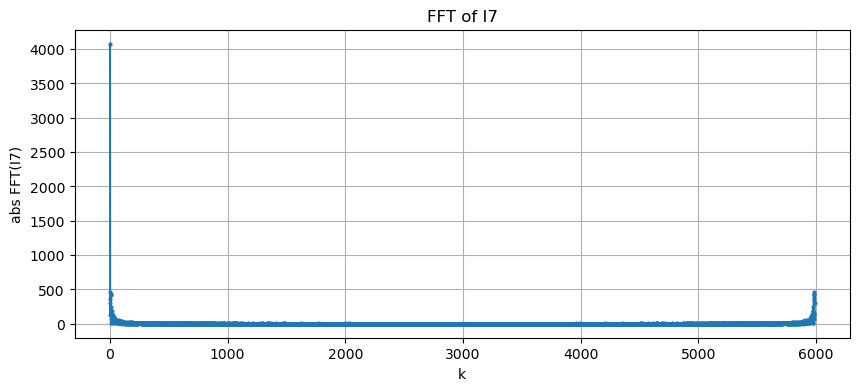

Top 10 frequencies for I7:
  k=0, abs FFT=4077.8776455026446
  k=2, abs FFT=464.1665695337572
  k=5988, abs FFT=464.166569533757
  k=5983, abs FFT=433.8395628268863
  k=7, abs FFT=433.8395628268863
  k=5, abs FFT=418.5112677218588
  k=5985, abs FFT=418.5112677218588
  k=5987, abs FFT=360.37953184034336
  k=3, abs FFT=360.37953184034336
  k=1, abs FFT=307.16023838716393


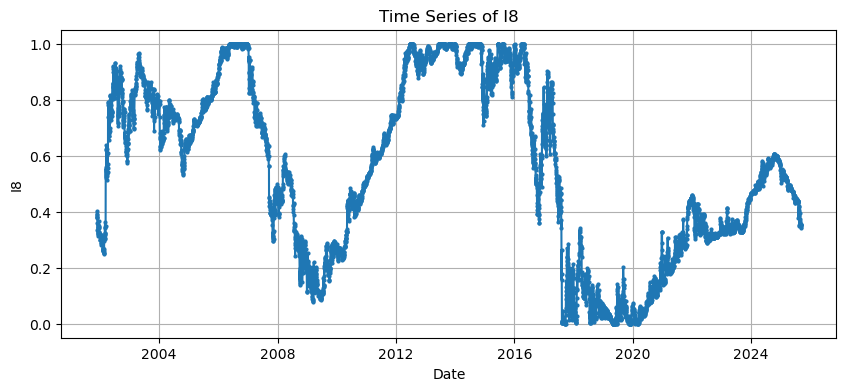

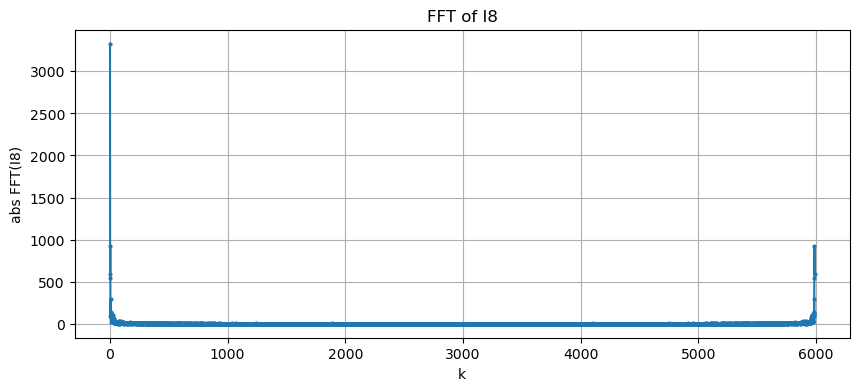

Top 10 frequencies for I8:
  k=0, abs FFT=3328.7615740740735
  k=5988, abs FFT=925.2976426538119
  k=2, abs FFT=925.2976426538117
  k=1, abs FFT=596.4960751426175
  k=5989, abs FFT=596.4960751426174
  k=5987, abs FFT=540.5742058185198
  k=3, abs FFT=540.5742058185198
  k=5985, abs FFT=295.0225040235621
  k=5, abs FFT=295.0225040235621
  k=5981, abs FFT=134.31914641376832


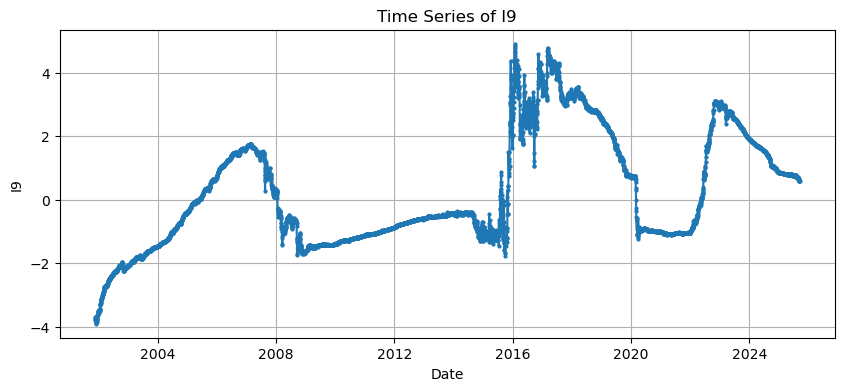

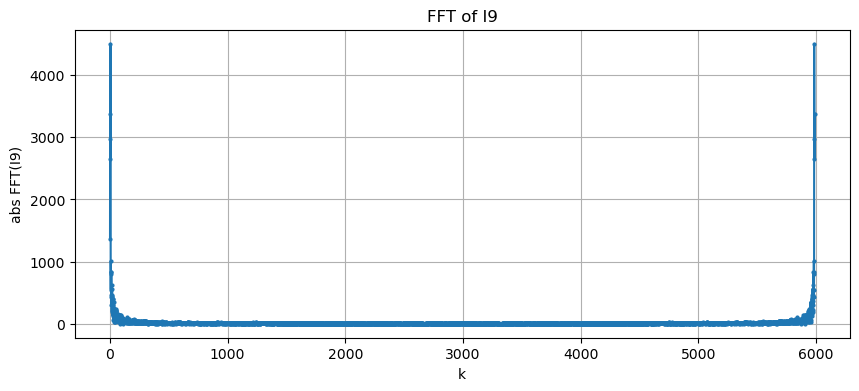

Top 10 frequencies for I9:
  k=5986, abs FFT=4507.070185494005
  k=4, abs FFT=4507.070185494004
  k=5989, abs FFT=3379.001830352353
  k=1, abs FFT=3379.001830352352
  k=3, abs FFT=2969.605406024793
  k=5987, abs FFT=2969.6054060247925
  k=2, abs FFT=2658.6443614109467
  k=5988, abs FFT=2658.644361410946
  k=0, abs FFT=1358.3126993705732
  k=7, abs FFT=1010.246320798227


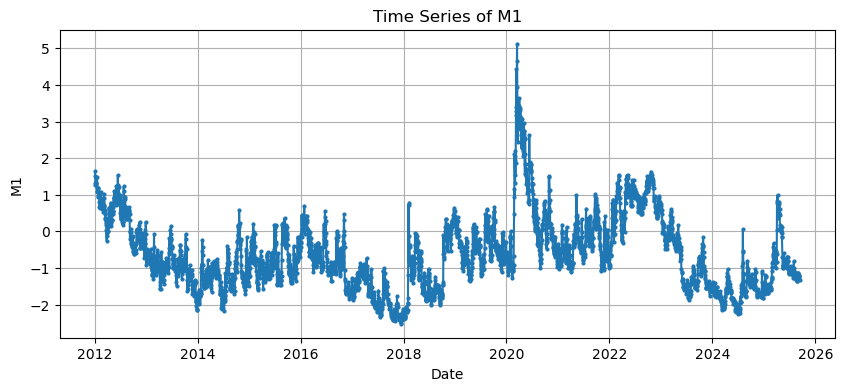

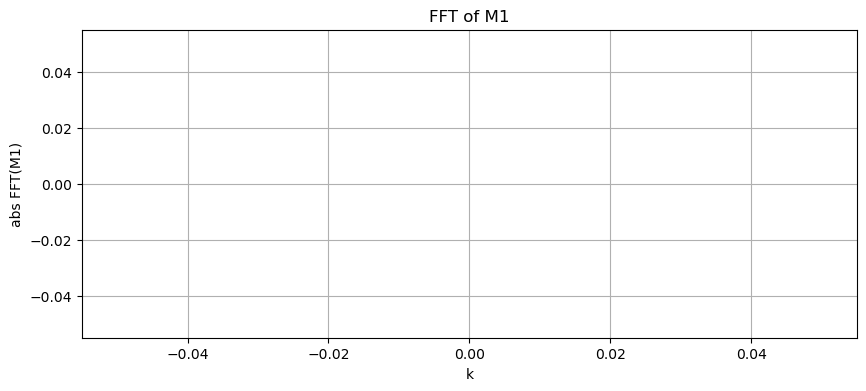

Top 10 frequencies for M1:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


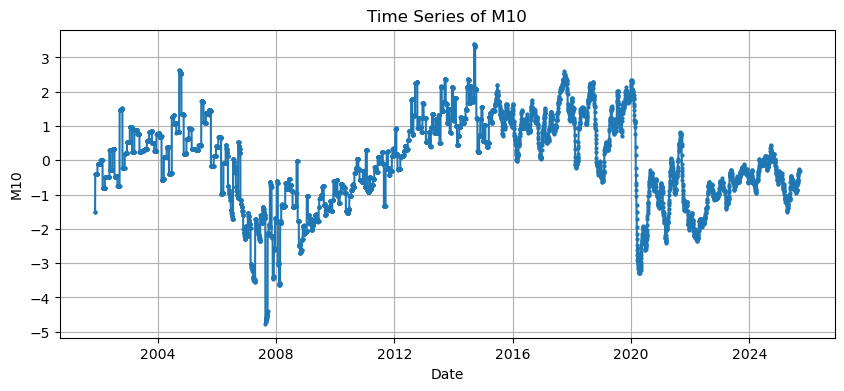

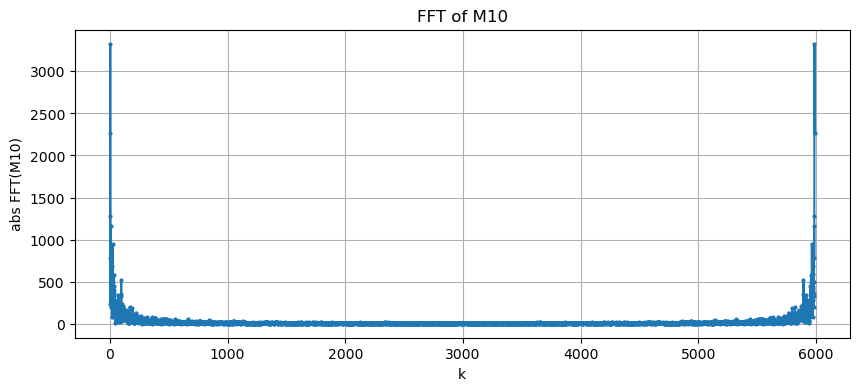

Top 10 frequencies for M10:
  k=2, abs FFT=3328.0331531846605
  k=5988, abs FFT=3328.03315318466
  k=1, abs FFT=2261.163320345786
  k=5989, abs FFT=2261.163320345786
  k=3, abs FFT=1281.017224709374
  k=5987, abs FFT=1281.0172247093737
  k=5985, abs FFT=1157.2740584372325
  k=5, abs FFT=1157.2740584372325
  k=24, abs FFT=949.4022435152273
  k=5966, abs FFT=949.402243515227


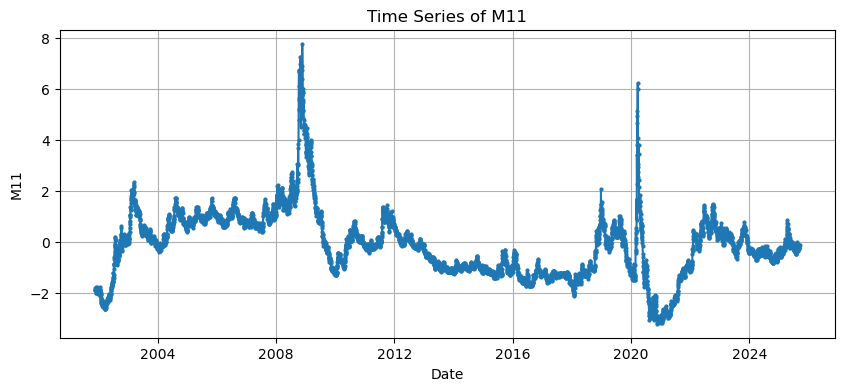

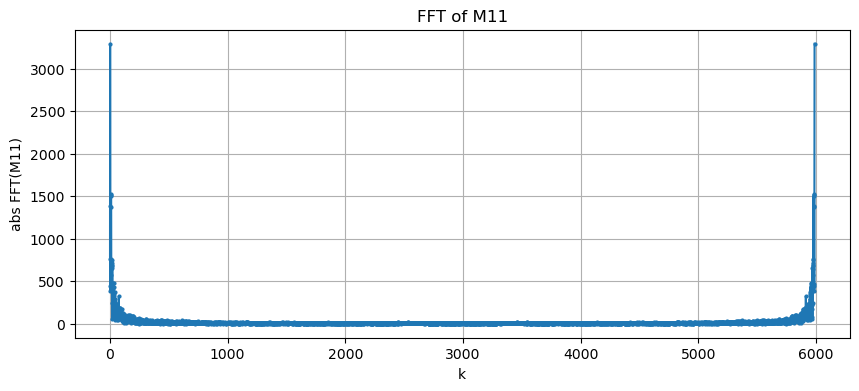

Top 10 frequencies for M11:
  k=1, abs FFT=3295.6015019713955
  k=5989, abs FFT=3295.601501971395
  k=5983, abs FFT=1523.143170484404
  k=7, abs FFT=1523.143170484404
  k=5, abs FFT=1520.2893440793098
  k=5985, abs FFT=1520.2893440793096
  k=9, abs FFT=1499.5037154699644
  k=5981, abs FFT=1499.503715469964
  k=2, abs FFT=1386.894283555767
  k=5988, abs FFT=1386.894283555767


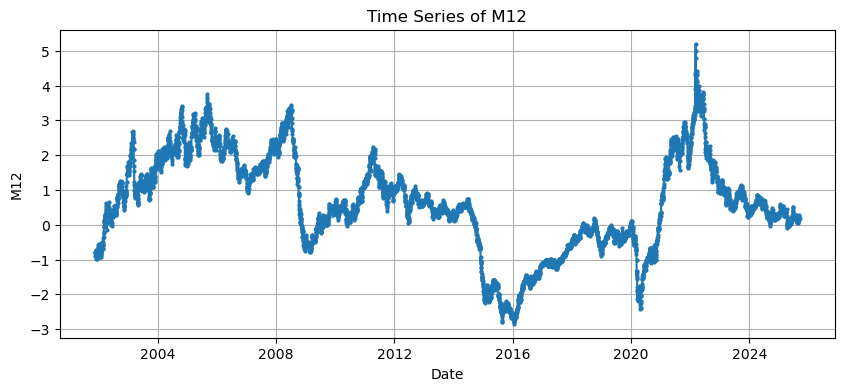

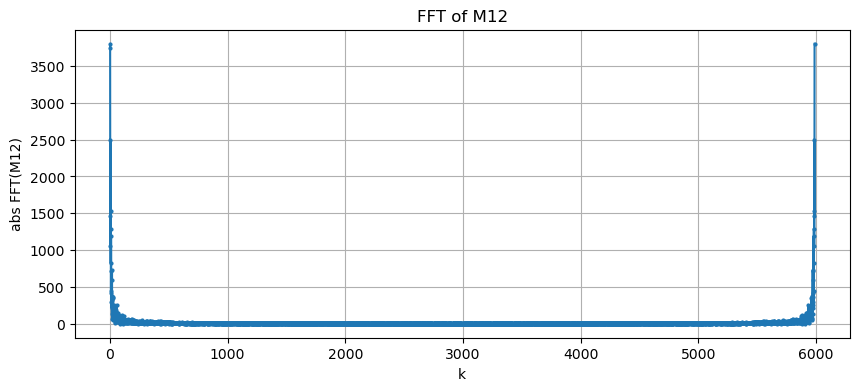

Top 10 frequencies for M12:
  k=5989, abs FFT=3801.2461377251616
  k=1, abs FFT=3801.2461377251616
  k=0, abs FFT=3736.7589526610673
  k=3, abs FFT=2500.1777723947675
  k=5987, abs FFT=2500.177772394767
  k=5, abs FFT=1524.404539912628
  k=5985, abs FFT=1524.404539912628
  k=2, abs FFT=1456.7142512458863
  k=5988, abs FFT=1456.714251245886
  k=7, abs FFT=1291.4924507772823


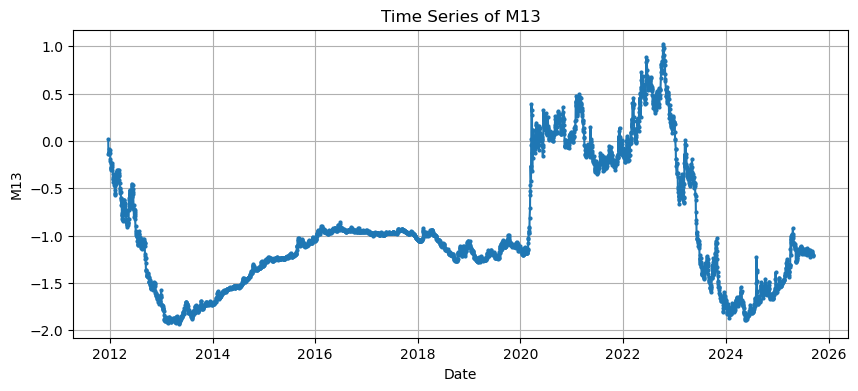

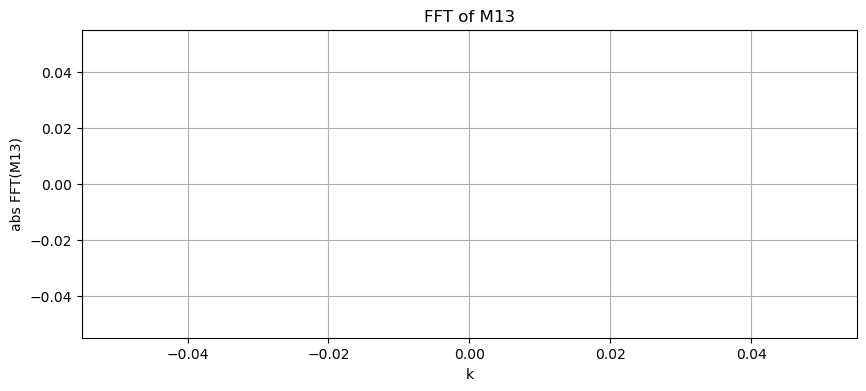

Top 10 frequencies for M13:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


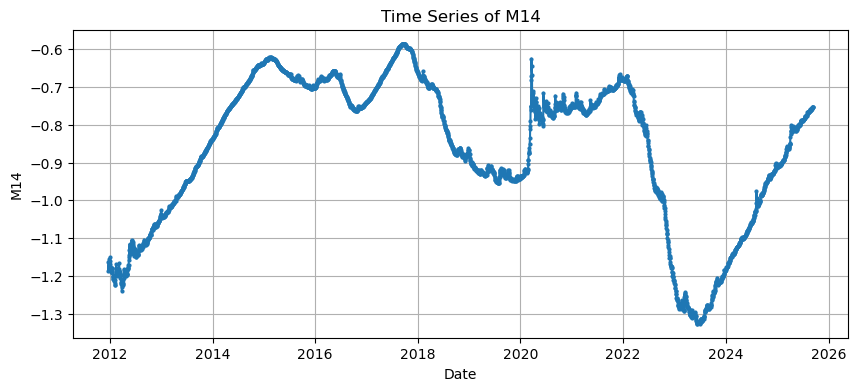

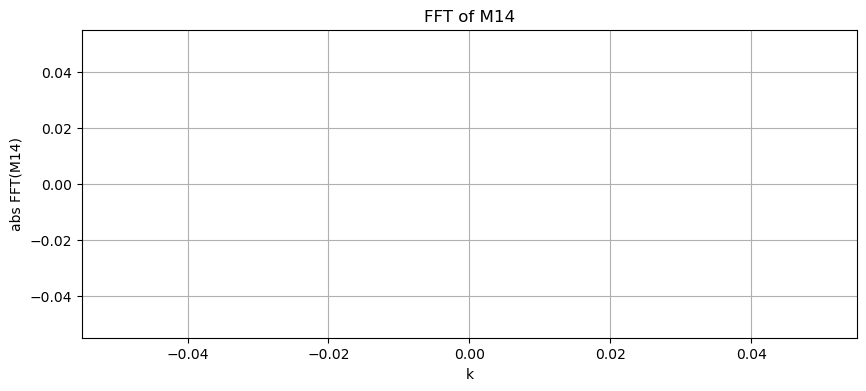

Top 10 frequencies for M14:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


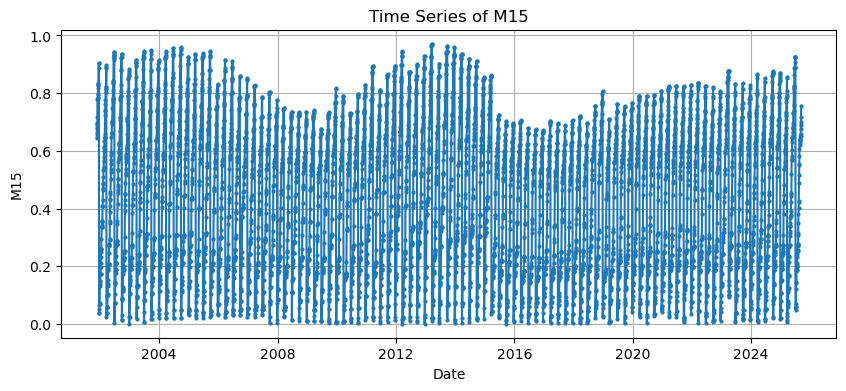

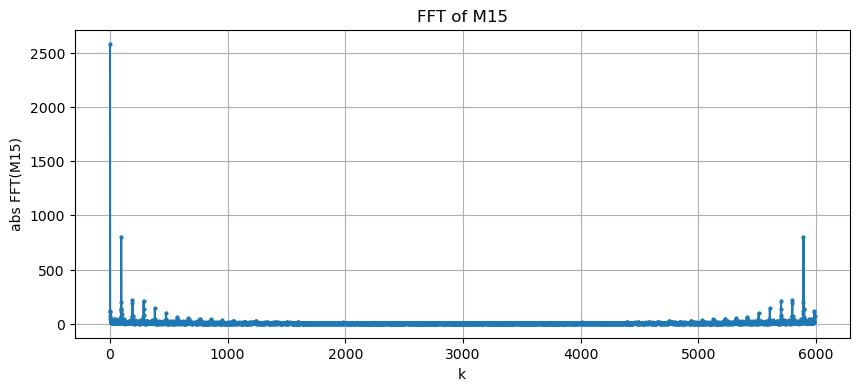

Top 10 frequencies for M15:
  k=0, abs FFT=2584.0869708994705
  k=95, abs FFT=803.8309648522551
  k=5895, abs FFT=803.8309648522551
  k=5800, abs FFT=222.15329450084022
  k=190, abs FFT=222.15329450084022
  k=286, abs FFT=213.20465431942074
  k=5704, abs FFT=213.2046543194207
  k=96, abs FFT=202.16529969721844
  k=5894, abs FFT=202.16529969721836
  k=191, abs FFT=187.9500694625551


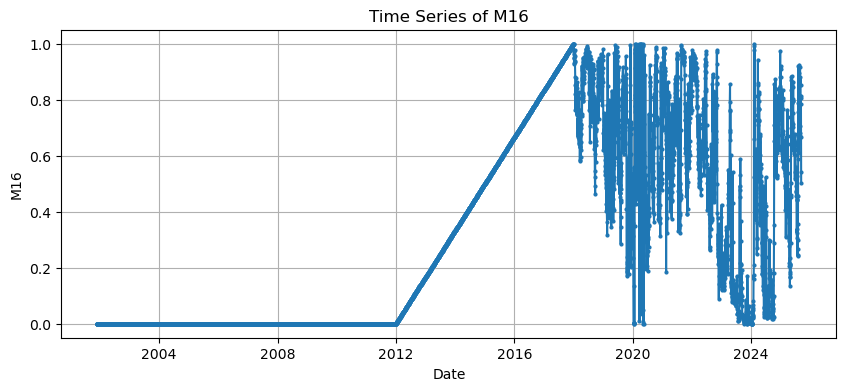

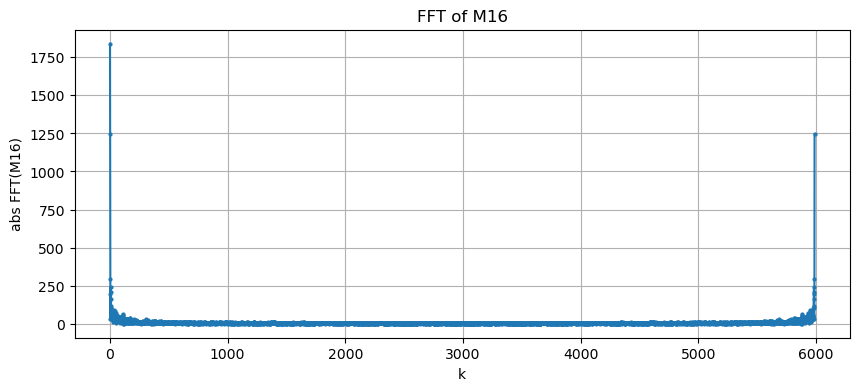

Top 10 frequencies for M16:
  k=0, abs FFT=1839.178571428571
  k=1, abs FFT=1246.5725817393768
  k=5989, abs FFT=1246.5725817393766
  k=2, abs FFT=293.2041187289779
  k=5988, abs FFT=293.20411872897785
  k=5984, abs FFT=240.18479261395282
  k=6, abs FFT=240.1847926139528
  k=7, abs FFT=208.4078000605568
  k=5983, abs FFT=208.4078000605568
  k=3, abs FFT=192.11617909551788


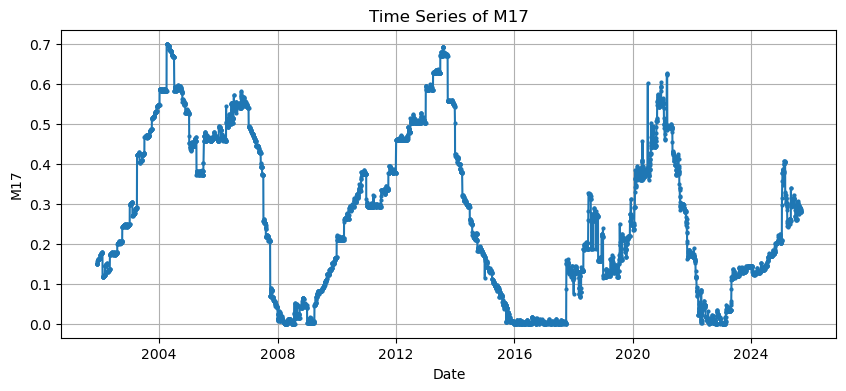

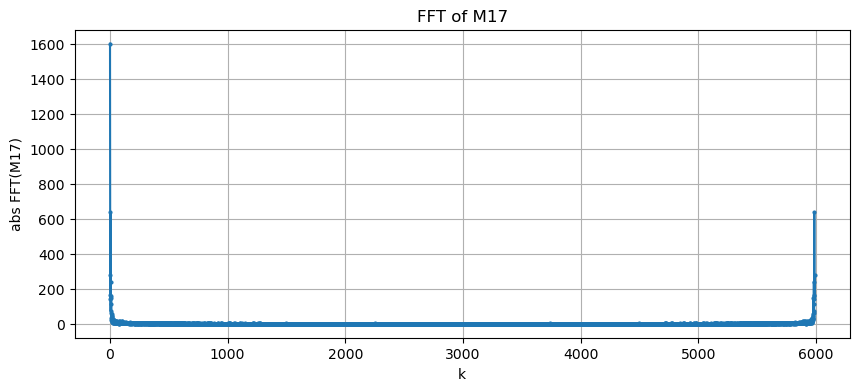

Top 10 frequencies for M17:
  k=0, abs FFT=1601.2886904761904
  k=5987, abs FFT=637.404689636247
  k=3, abs FFT=637.4046896362469
  k=1, abs FFT=278.79719153547785
  k=5989, abs FFT=278.7971915354778
  k=5983, abs FFT=240.28507823719883
  k=7, abs FFT=240.2850782371988
  k=5986, abs FFT=161.50417875376766
  k=4, abs FFT=161.5041787537676
  k=8, abs FFT=159.69144759580766


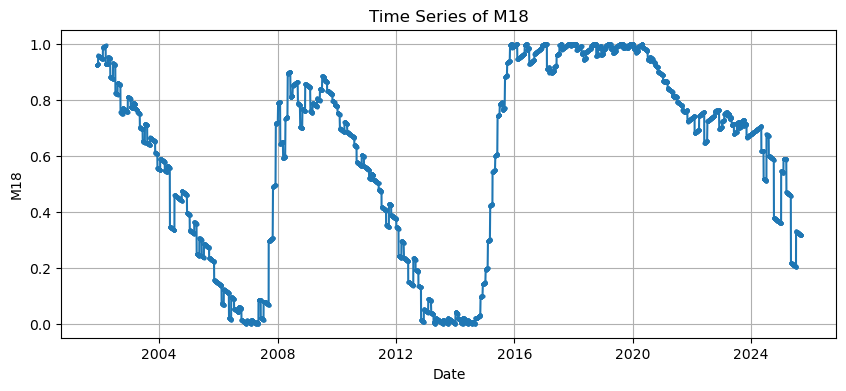

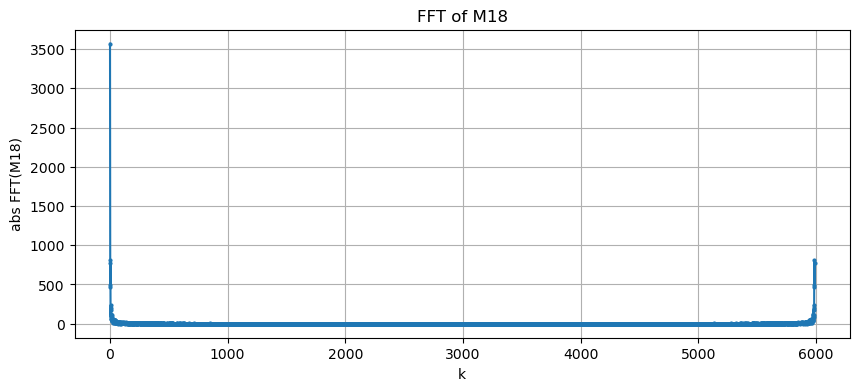

Top 10 frequencies for M18:
  k=0, abs FFT=3568.4847883597877
  k=3, abs FFT=807.8254995540201
  k=5987, abs FFT=807.8254995540195
  k=1, abs FFT=775.9237064816621
  k=5989, abs FFT=775.923706481662
  k=4, abs FFT=496.7012869729183
  k=5986, abs FFT=496.70128697291824
  k=2, abs FFT=466.3981966326996
  k=5988, abs FFT=466.39819663269947
  k=7, abs FFT=235.53315653685203


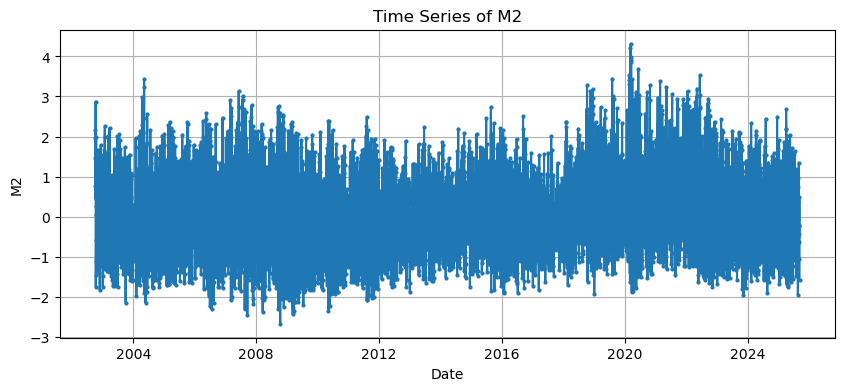

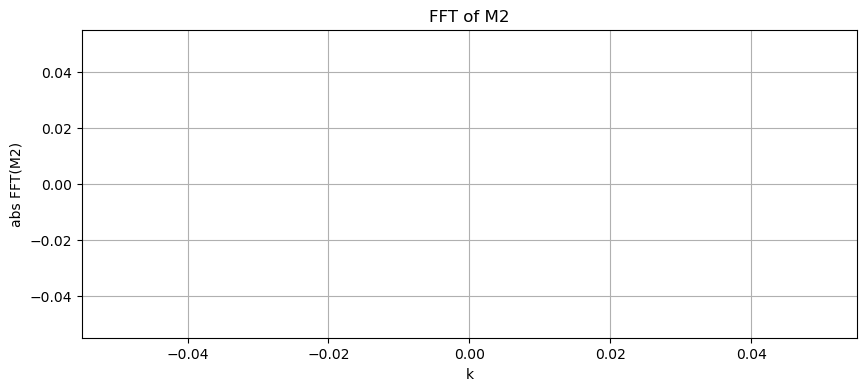

Top 10 frequencies for M2:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


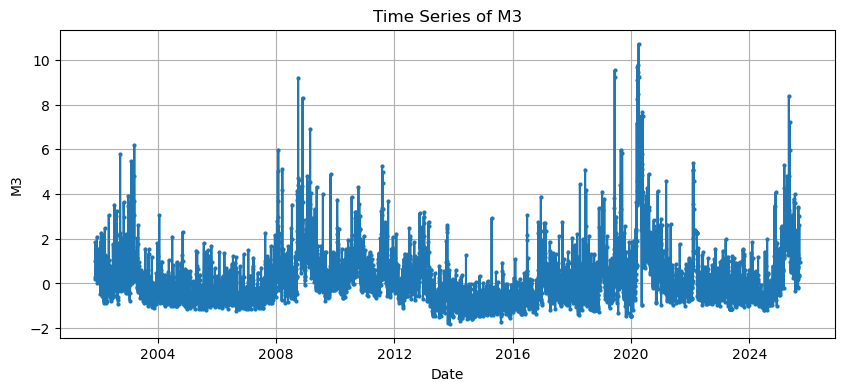

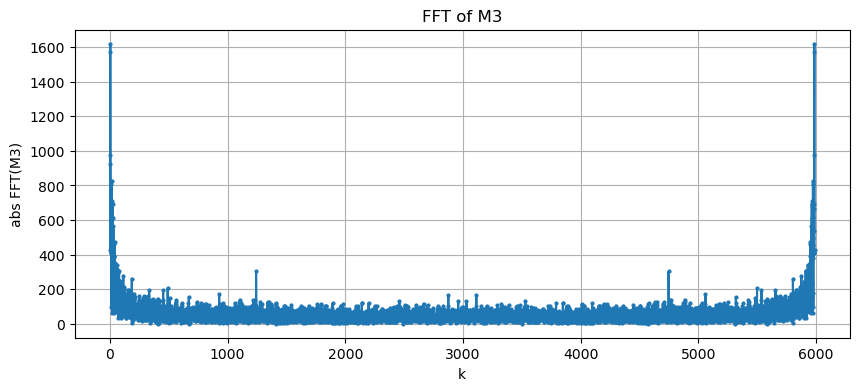

Top 10 frequencies for M3:
  k=3, abs FFT=1618.3387038774565
  k=5987, abs FFT=1618.3387038774565
  k=5988, abs FFT=1569.3974107558302
  k=2, abs FFT=1569.39741075583
  k=5986, abs FFT=973.5001300828859
  k=4, abs FFT=973.5001300828856
  k=0, abs FFT=921.5727870147787
  k=5975, abs FFT=827.5018568331866
  k=15, abs FFT=827.5018568331866
  k=5980, abs FFT=806.7208336631243


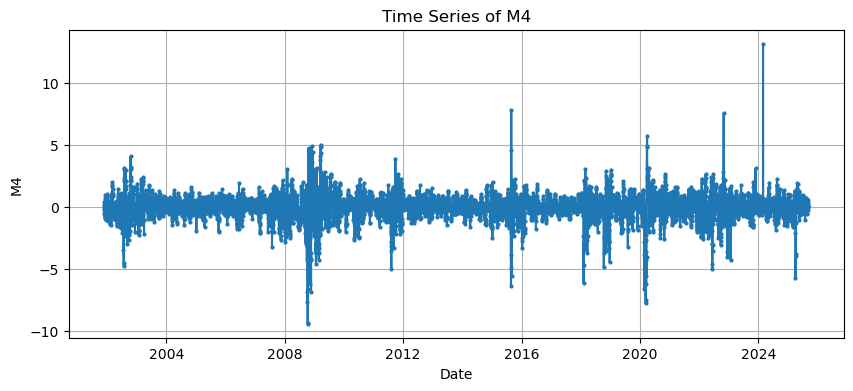

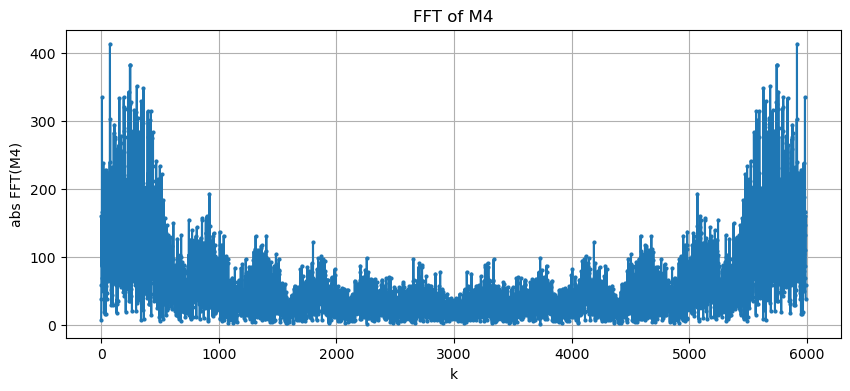

Top 10 frequencies for M4:
  k=5915, abs FFT=414.03298360118436
  k=75, abs FFT=414.0329836011843
  k=247, abs FFT=383.0034507910585
  k=5743, abs FFT=383.00345079105847
  k=245, abs FFT=382.8251133630149
  k=5745, abs FFT=382.8251133630148
  k=303, abs FFT=351.85224784169816
  k=5687, abs FFT=351.8522478416981
  k=5630, abs FFT=348.84695239806246
  k=360, abs FFT=348.8469523980624


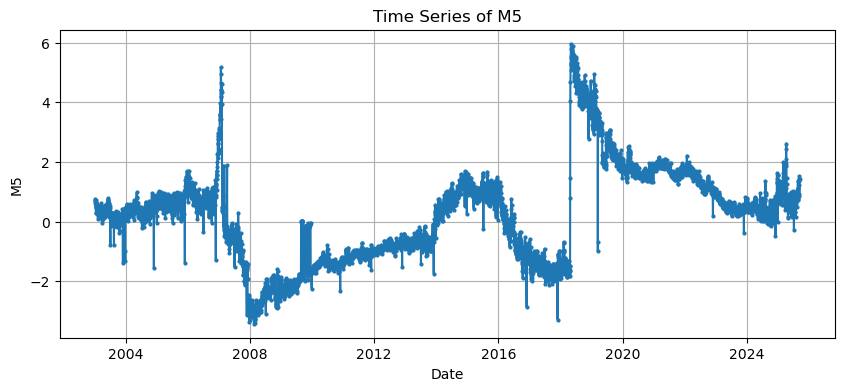

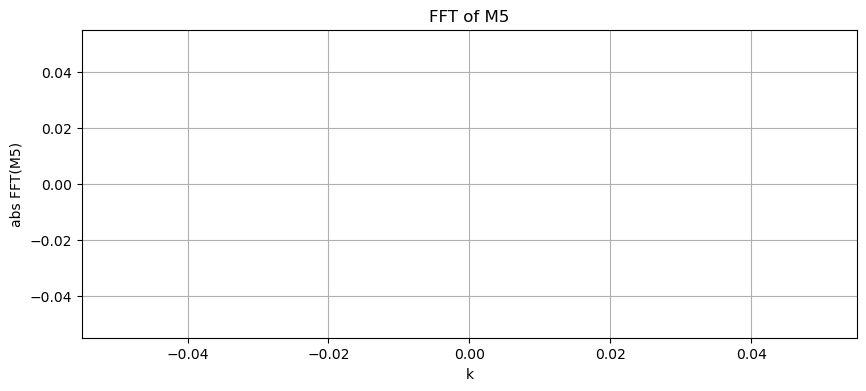

Top 10 frequencies for M5:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


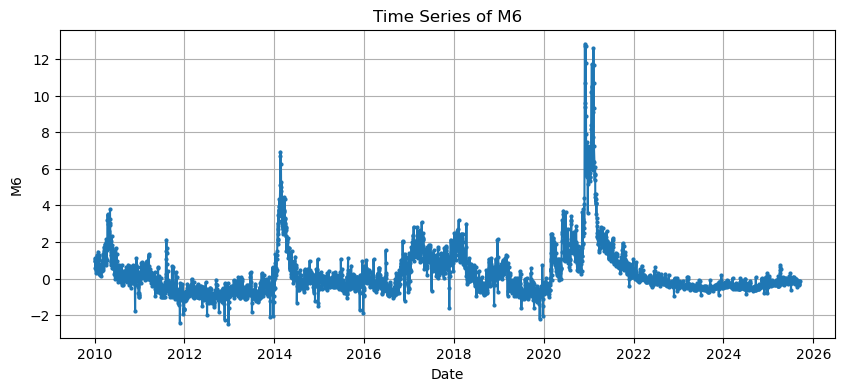

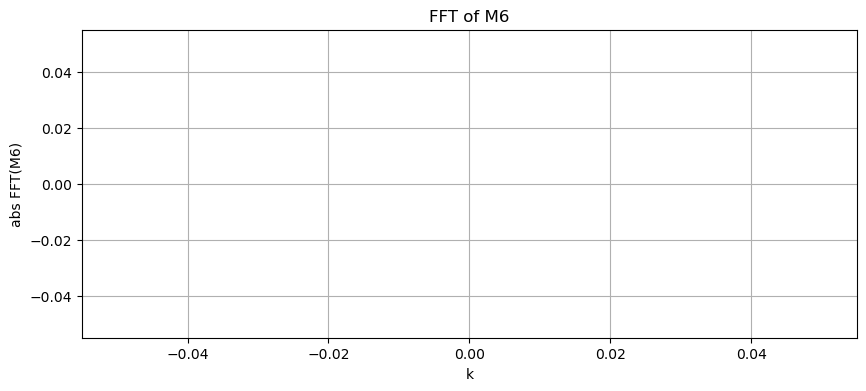

Top 10 frequencies for M6:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


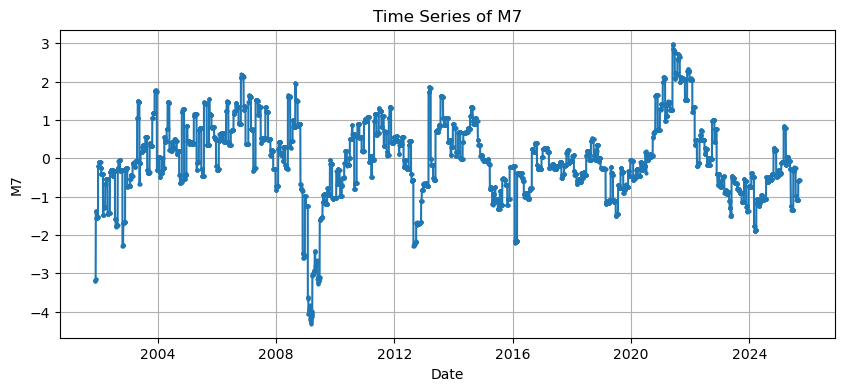

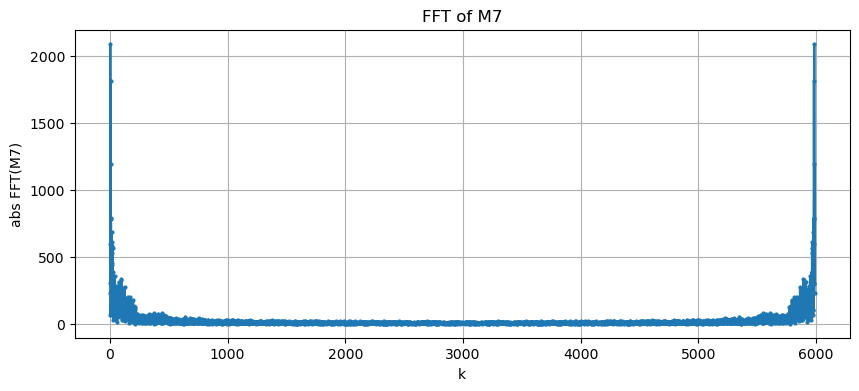

Top 10 frequencies for M7:
  k=3, abs FFT=2094.7266068441945
  k=5987, abs FFT=2094.726606844194
  k=7, abs FFT=1819.2665841157177
  k=5983, abs FFT=1819.2665841157175
  k=5, abs FFT=1194.1282771463125
  k=5985, abs FFT=1194.1282771463125
  k=5981, abs FFT=790.676855524789
  k=9, abs FFT=790.676855524789
  k=6, abs FFT=784.2694874084281
  k=5984, abs FFT=784.2694874084281


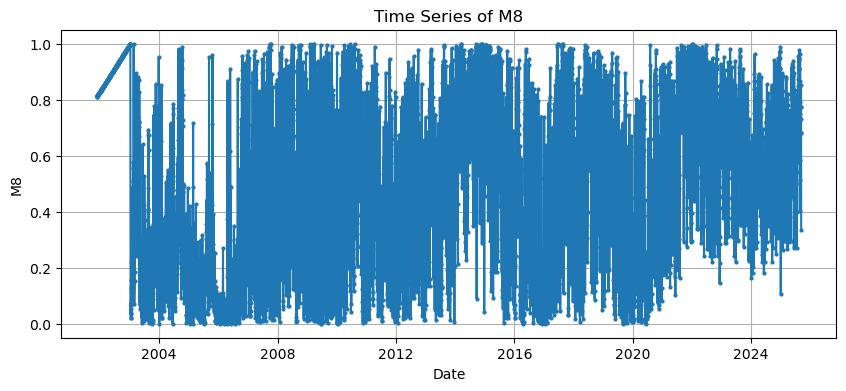

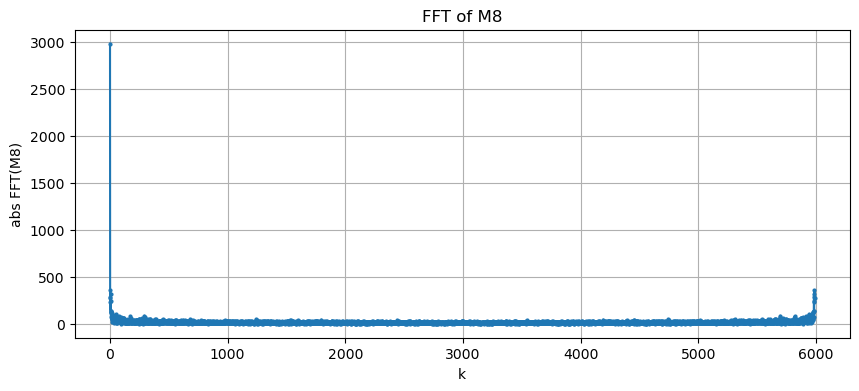

Top 10 frequencies for M8:
  k=0, abs FFT=2977.4775132275126
  k=2, abs FFT=356.7633919076518
  k=5988, abs FFT=356.76339190765174
  k=6, abs FFT=311.68235414750495
  k=5984, abs FFT=311.68235414750495
  k=4, abs FFT=286.568995382184
  k=5986, abs FFT=286.56899538218397
  k=5989, abs FFT=277.55885468001077
  k=1, abs FFT=277.5588546800106
  k=5983, abs FFT=246.0675346621988


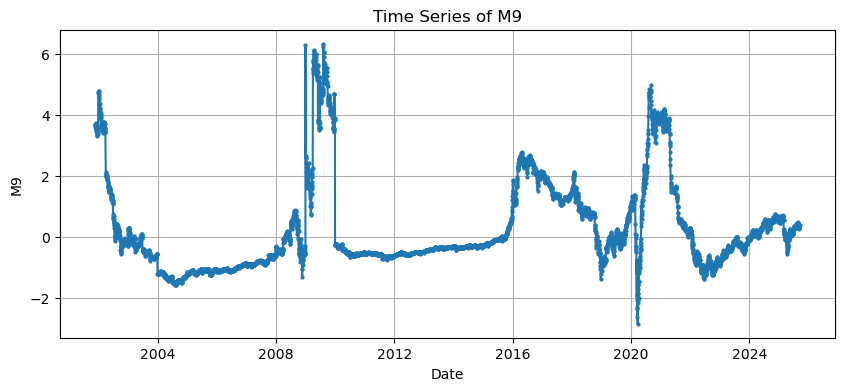

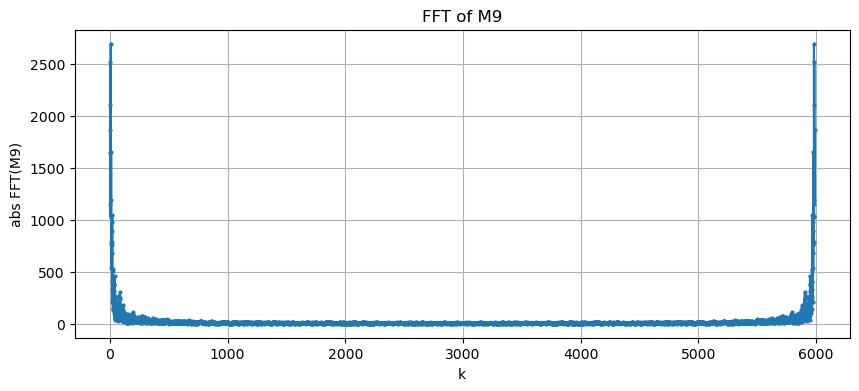

Top 10 frequencies for M9:
  k=6, abs FFT=2694.3332508706035
  k=5984, abs FFT=2694.333250870603
  k=3, abs FFT=2520.142370303681
  k=5987, abs FFT=2520.1423703036808
  k=5986, abs FFT=2106.9762908532707
  k=4, abs FFT=2106.9762908532703
  k=1, abs FFT=1864.1075897139574
  k=5989, abs FFT=1864.1075897139572
  k=5980, abs FFT=1654.771565273158
  k=10, abs FFT=1654.771565273158


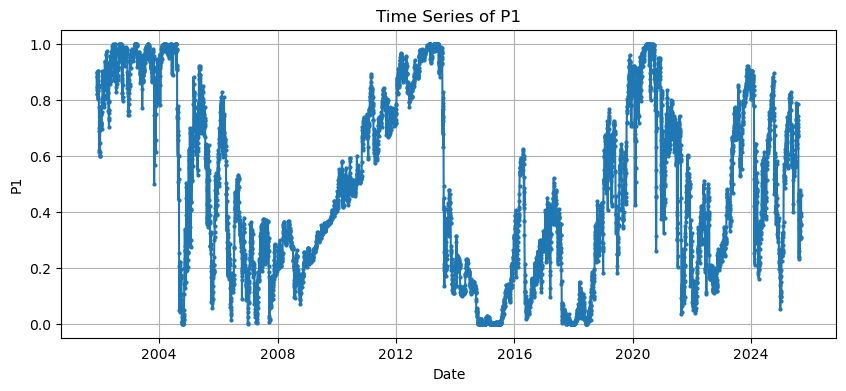

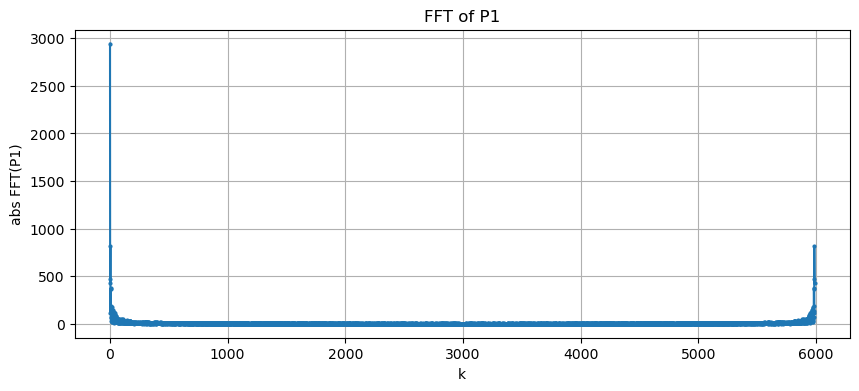

Top 10 frequencies for P1:
  k=0, abs FFT=2942.5201719576717
  k=5987, abs FFT=812.2211415470894
  k=3, abs FFT=812.2211415470891
  k=2, abs FFT=465.73642267876505
  k=5988, abs FFT=465.7364226787649
  k=5989, abs FFT=426.21386520800144
  k=1, abs FFT=426.21386520800144
  k=5983, abs FFT=372.3780056324921
  k=7, abs FFT=372.3780056324921
  k=5984, abs FFT=368.2484147190574


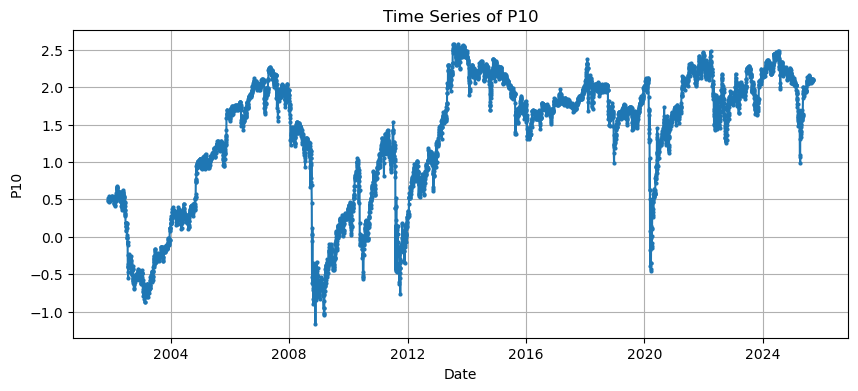

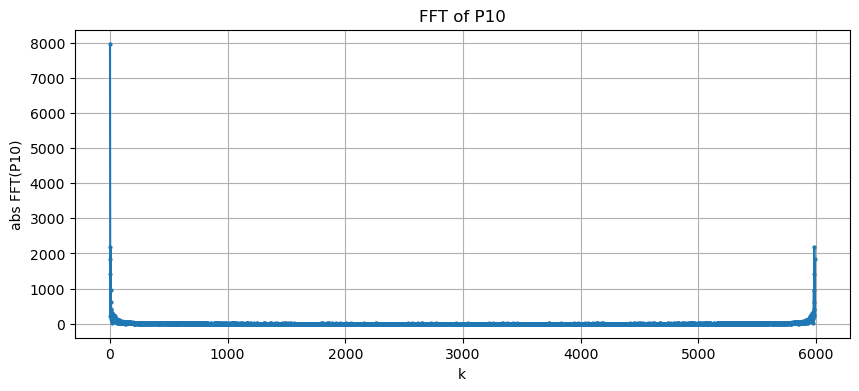

Top 10 frequencies for P10:
  k=0, abs FFT=7969.187945303693
  k=5987, abs FFT=2195.3811810579086
  k=3, abs FFT=2195.381181057908
  k=1, abs FFT=1829.8286267102412
  k=5989, abs FFT=1829.8286267102412
  k=5986, abs FFT=1419.0913092651385
  k=4, abs FFT=1419.0913092651385
  k=5983, abs FFT=972.3238569631399
  k=7, abs FFT=972.3238569631399
  k=5982, abs FFT=622.9177946768614


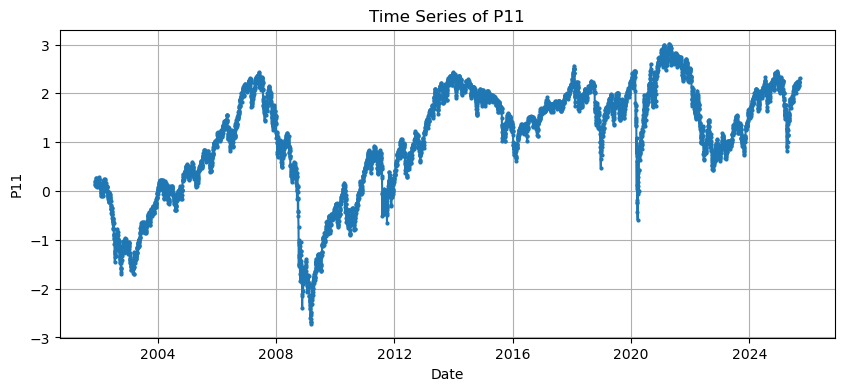

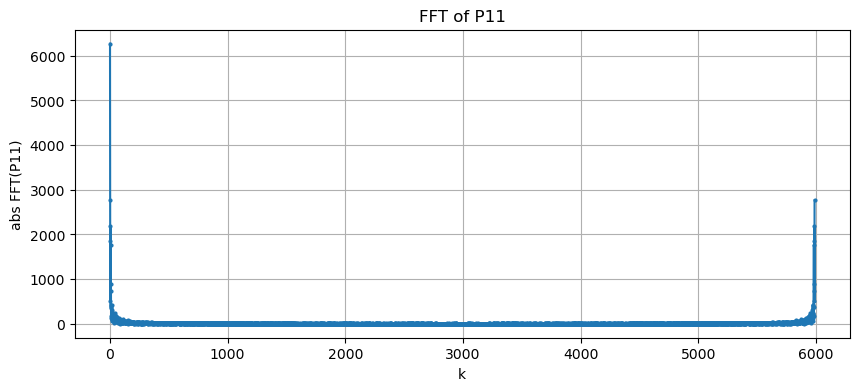

Top 10 frequencies for P11:
  k=0, abs FFT=6270.616801536318
  k=1, abs FFT=2764.414705264725
  k=5989, abs FFT=2764.4147052647245
  k=3, abs FFT=2178.1126842041854
  k=5987, abs FFT=2178.1126842041854
  k=4, abs FFT=1857.6192401836481
  k=5986, abs FFT=1857.619240183648
  k=5983, abs FFT=1758.4966200464644
  k=7, abs FFT=1758.4966200464644
  k=5985, abs FFT=892.4954192790921


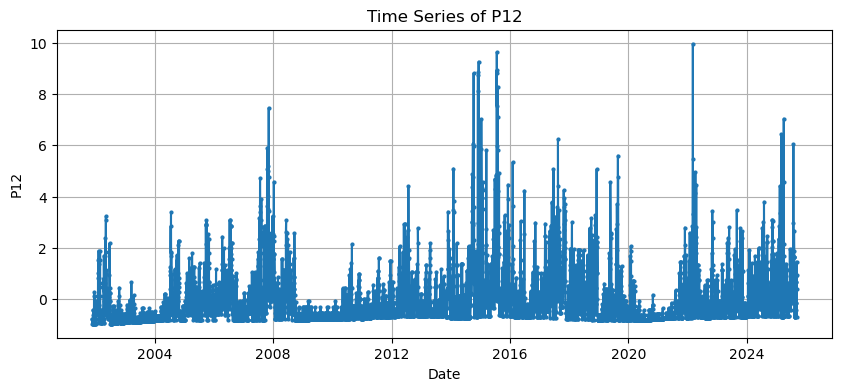

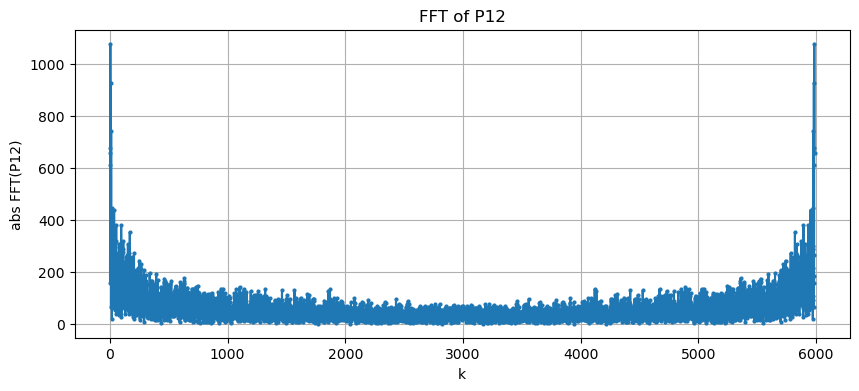

Top 10 frequencies for P12:
  k=5987, abs FFT=1076.3952991765507
  k=3, abs FFT=1076.3952991765507
  k=7, abs FFT=926.6273499274959
  k=5983, abs FFT=926.6273499274956
  k=10, abs FFT=742.1422385047525
  k=5980, abs FFT=742.1422385047524
  k=2, abs FFT=674.7823736723593
  k=5988, abs FFT=674.7823736723593
  k=1, abs FFT=656.5919689316707
  k=5989, abs FFT=656.5919689316705


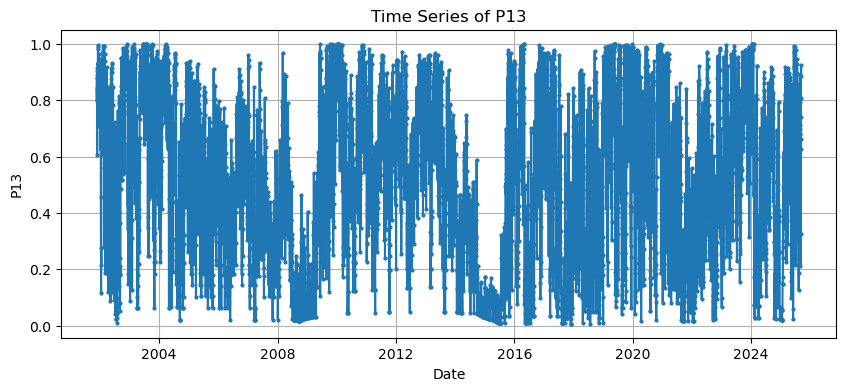

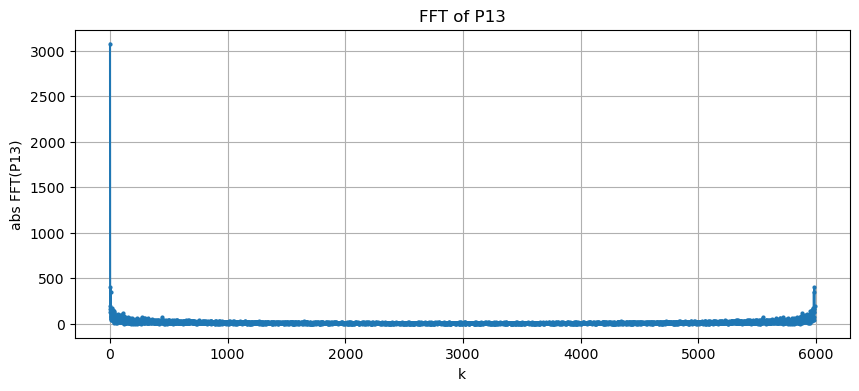

Top 10 frequencies for P13:
  k=0, abs FFT=3075.2268518518513
  k=3, abs FFT=398.43965913672383
  k=5987, abs FFT=398.4396591367238
  k=7, abs FFT=349.32969151246834
  k=5983, abs FFT=349.3296915124683
  k=5989, abs FFT=192.0156428125942
  k=1, abs FFT=192.01564281259414
  k=15, abs FFT=174.90700523187797
  k=5975, abs FFT=174.90700523187795
  k=5988, abs FFT=164.99465792209637


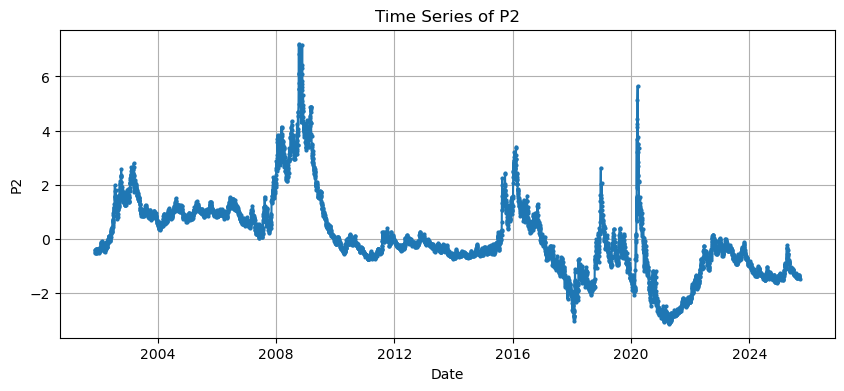

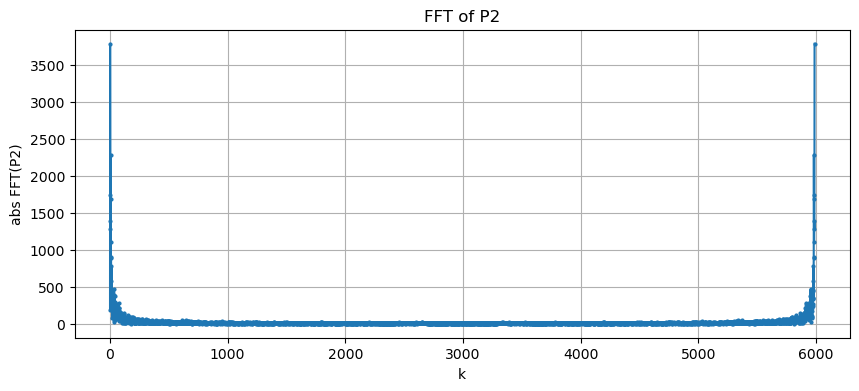

Top 10 frequencies for P2:
  k=5989, abs FFT=3782.2849279133297
  k=1, abs FFT=3782.2849279133293
  k=7, abs FFT=2282.3204716037694
  k=5983, abs FFT=2282.320471603769
  k=5988, abs FFT=1741.517516444211
  k=2, abs FFT=1741.5175164442105
  k=6, abs FFT=1684.6052067700052
  k=5984, abs FFT=1684.605206770005
  k=5986, abs FFT=1383.1644038951908
  k=4, abs FFT=1383.1644038951908


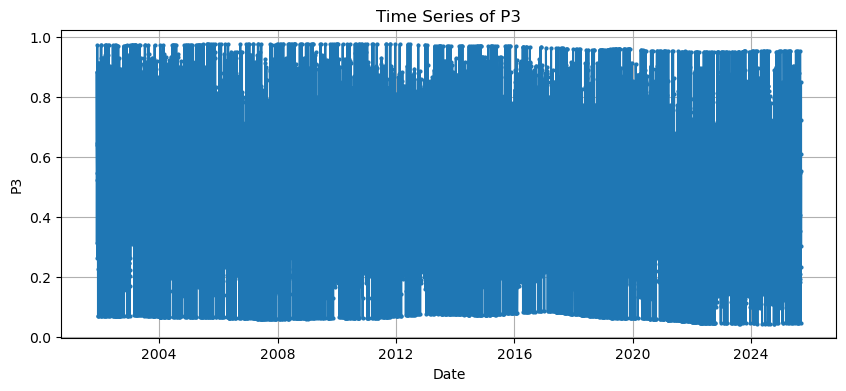

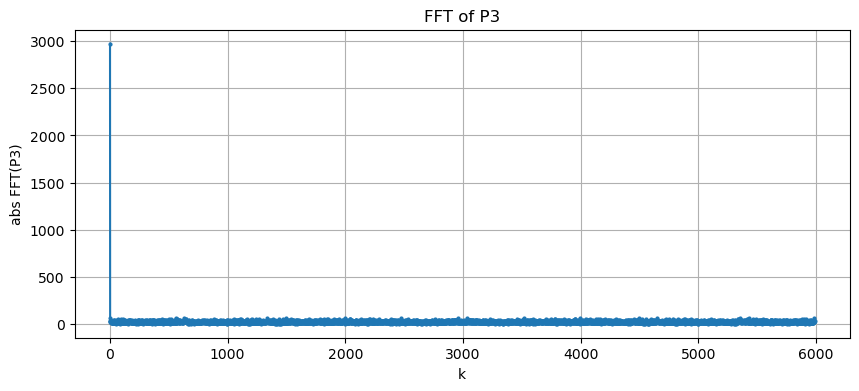

Top 10 frequencies for P3:
  k=0, abs FFT=2973.82208994709
  k=4653, abs FFT=60.85010949791979
  k=1337, abs FFT=60.85010949791973
  k=2, abs FFT=59.70487026645698
  k=5988, abs FFT=59.704870266456936
  k=5432, abs FFT=58.777459100822504
  k=558, abs FFT=58.77745910082248
  k=3034, abs FFT=58.364782882753474
  k=2956, abs FFT=58.36478288275346
  k=3996, abs FFT=57.03525316115573


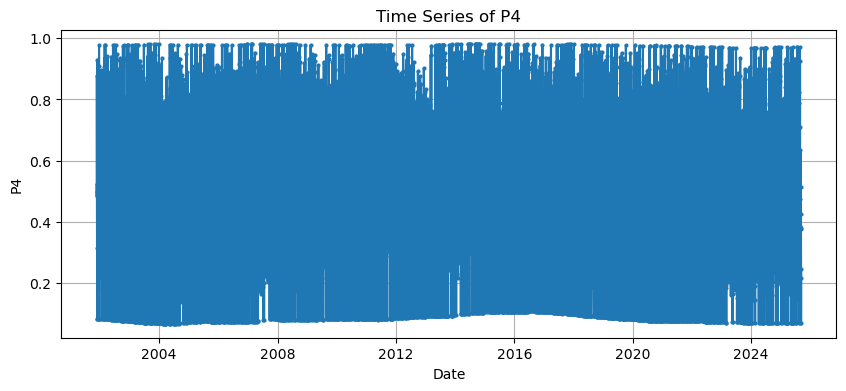

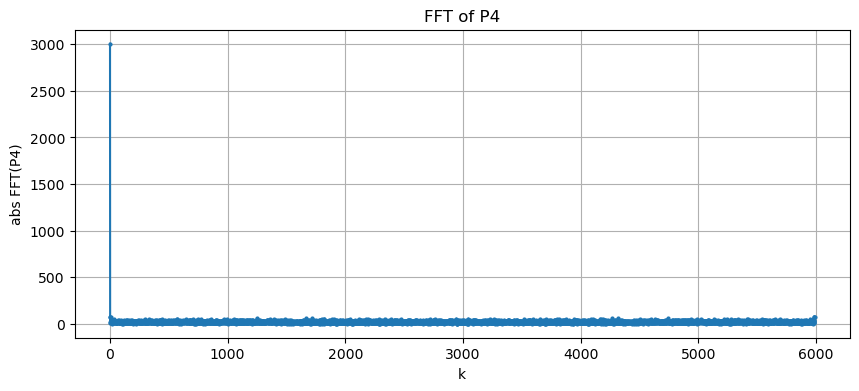

Top 10 frequencies for P4:
  k=0, abs FFT=3006.235449735449
  k=3, abs FFT=77.91876778935541
  k=5987, abs FFT=77.9187677893554
  k=1, abs FFT=75.88024285217335
  k=5989, abs FFT=75.8802428521733
  k=7, abs FFT=73.25848799100874
  k=5983, abs FFT=73.25848799100874
  k=4743, abs FFT=58.31971909686876
  k=1247, abs FFT=58.31971909686871
  k=4269, abs FFT=57.6679187820747


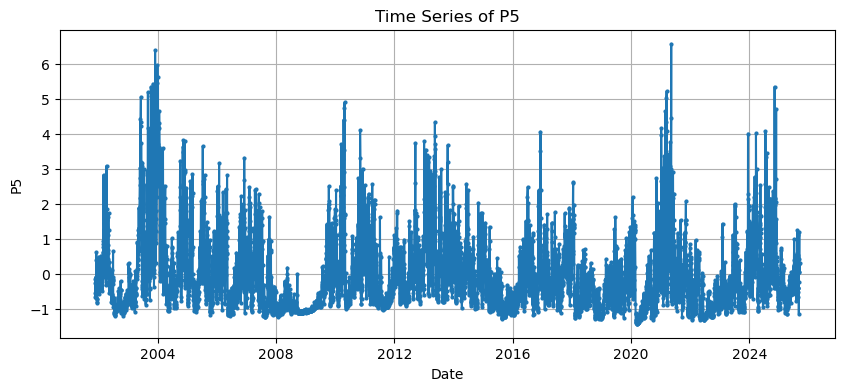

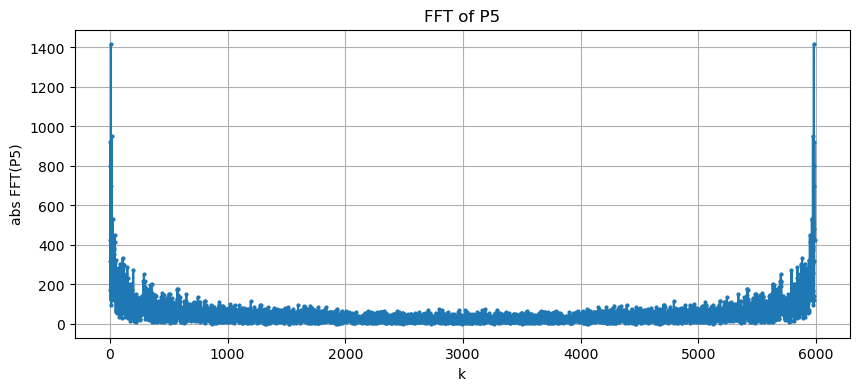

Top 10 frequencies for P5:
  k=5983, abs FFT=1418.7807968379066
  k=7, abs FFT=1418.7807968379066
  k=15, abs FFT=950.1775407372452
  k=5975, abs FFT=950.1775407372452
  k=3, abs FFT=923.3124192114656
  k=5987, abs FFT=923.3124192114653
  k=2, abs FFT=801.4677437716833
  k=5988, abs FFT=801.4677437716832
  k=8, abs FFT=698.9286391112885
  k=5982, abs FFT=698.9286391112885


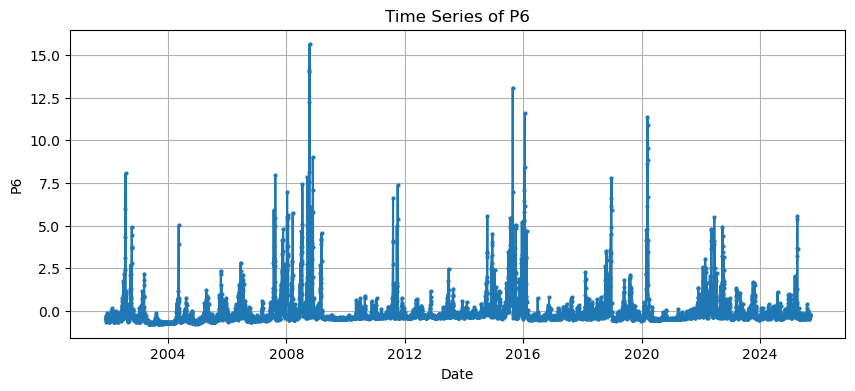

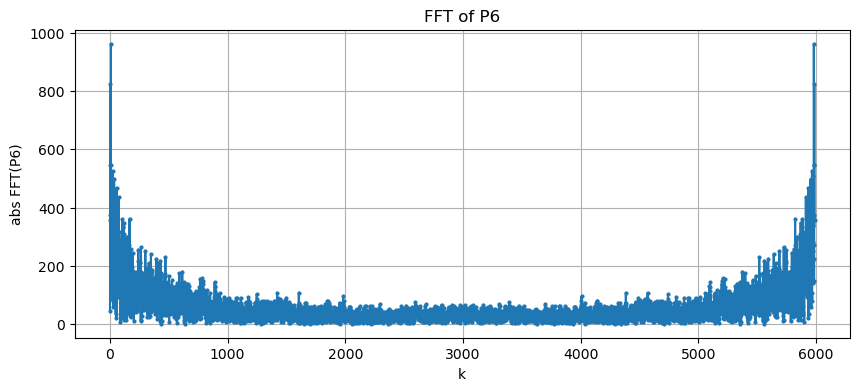

Top 10 frequencies for P6:
  k=7, abs FFT=962.7947701664359
  k=5983, abs FFT=962.7947701664358
  k=3, abs FFT=824.0040364884203
  k=5987, abs FFT=824.0040364884201
  k=6, abs FFT=546.3468906052143
  k=5984, abs FFT=546.3468906052142
  k=5986, abs FFT=544.9524930402162
  k=4, abs FFT=544.9524930402162
  k=23, abs FFT=526.4582318007963
  k=5967, abs FFT=526.4582318007962


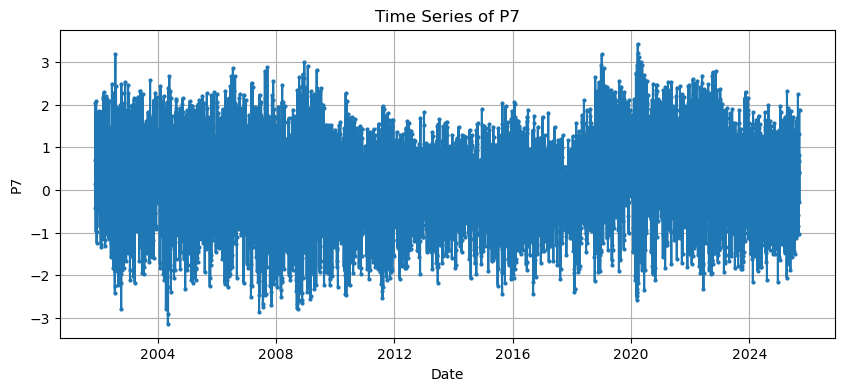

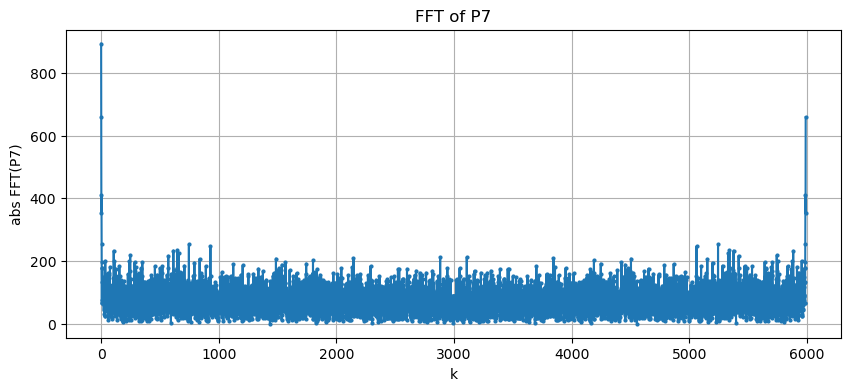

Top 10 frequencies for P7:
  k=0, abs FFT=892.4650666797811
  k=5989, abs FFT=658.4987312388756
  k=1, abs FFT=658.4987312388756
  k=3, abs FFT=409.6776925272436
  k=5987, abs FFT=409.6776925272435
  k=2, abs FFT=351.77113548101903
  k=5988, abs FFT=351.771135481019
  k=4, abs FFT=254.66640414738777
  k=5986, abs FFT=254.66640414738777
  k=5244, abs FFT=252.928752026553


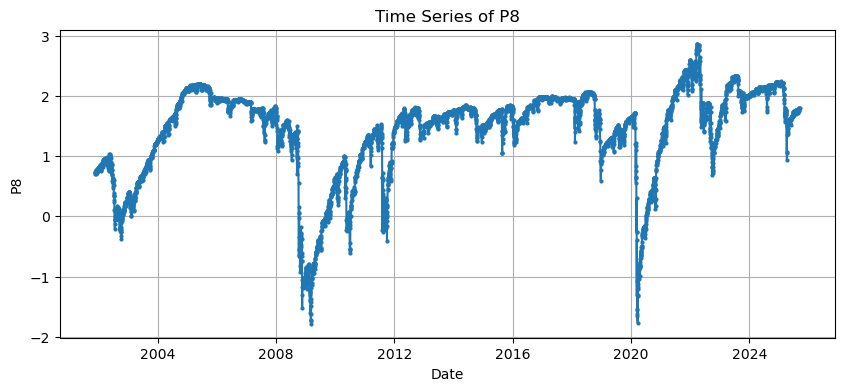

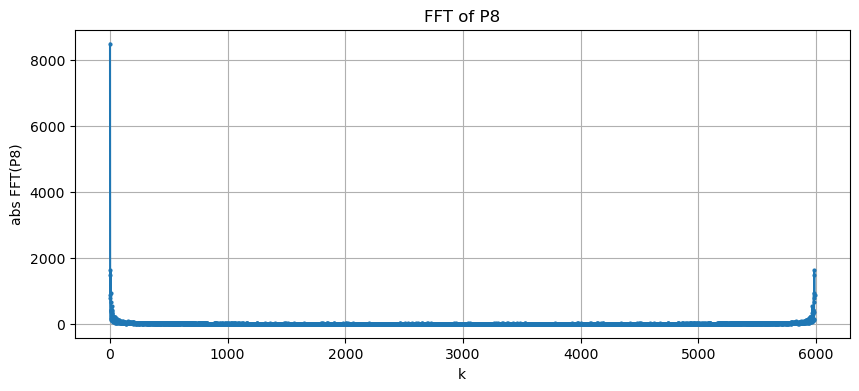

Top 10 frequencies for P8:
  k=0, abs FFT=8484.071896111585
  k=5986, abs FFT=1629.1941730869237
  k=4, abs FFT=1629.194173086923
  k=5987, abs FFT=1485.8178333465764
  k=3, abs FFT=1485.8178333465764
  k=7, abs FFT=934.8964574412356
  k=5983, abs FFT=934.8964574412356
  k=5989, abs FFT=883.7704666513677
  k=1, abs FFT=883.7704666513673
  k=2, abs FFT=772.3074176121522


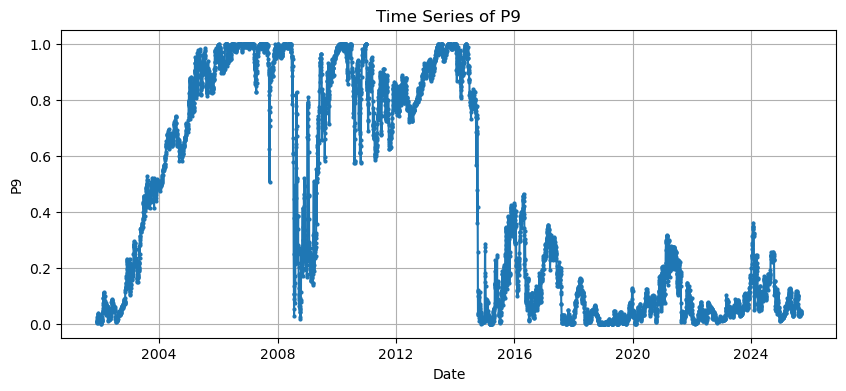

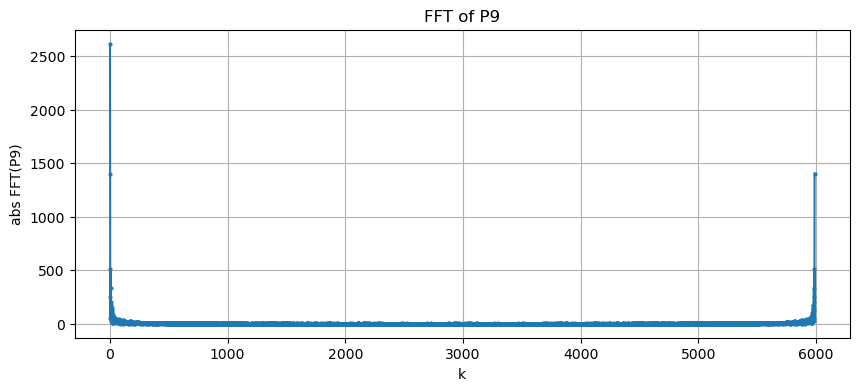

Top 10 frequencies for P9:
  k=0, abs FFT=2615.9494047619046
  k=1, abs FFT=1402.3770061040987
  k=5989, abs FFT=1402.3770061040984
  k=3, abs FFT=509.49607278434
  k=5987, abs FFT=509.49607278433984
  k=5983, abs FFT=334.9857782178095
  k=7, abs FFT=334.98577821780947
  k=5986, abs FFT=247.79875806377186
  k=4, abs FFT=247.7987580637718
  k=5982, abs FFT=199.11101393858792


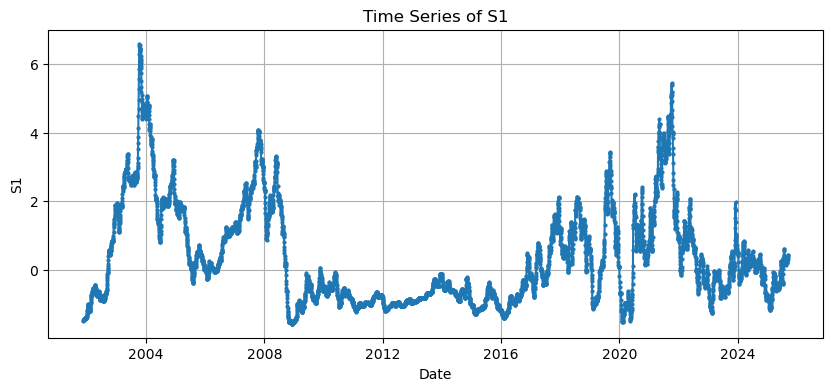

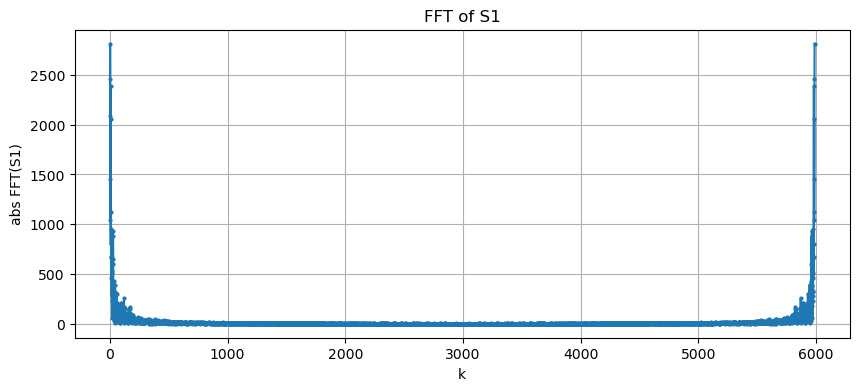

Top 10 frequencies for S1:
  k=1, abs FFT=2813.8487465431026
  k=5989, abs FFT=2813.848746543102
  k=2, abs FFT=2455.784539344231
  k=5988, abs FFT=2455.7845393442303
  k=7, abs FFT=2390.8405623229464
  k=5983, abs FFT=2390.840562322946
  k=0, abs FFT=2090.2386077689976
  k=5, abs FFT=2052.6913754430348
  k=5985, abs FFT=2052.6913754430348
  k=5987, abs FFT=1452.1123770934425


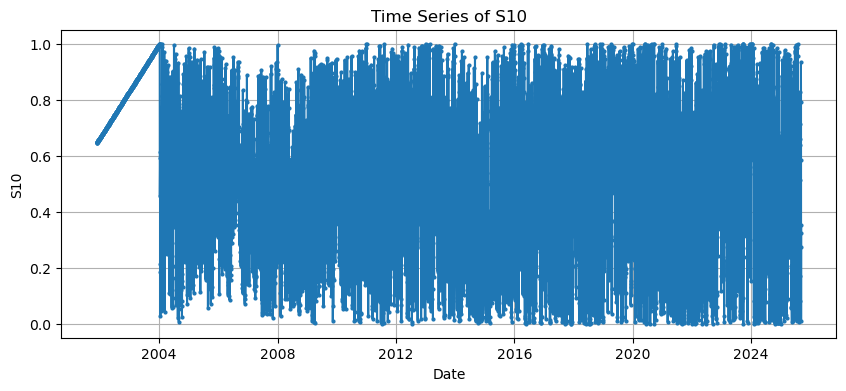

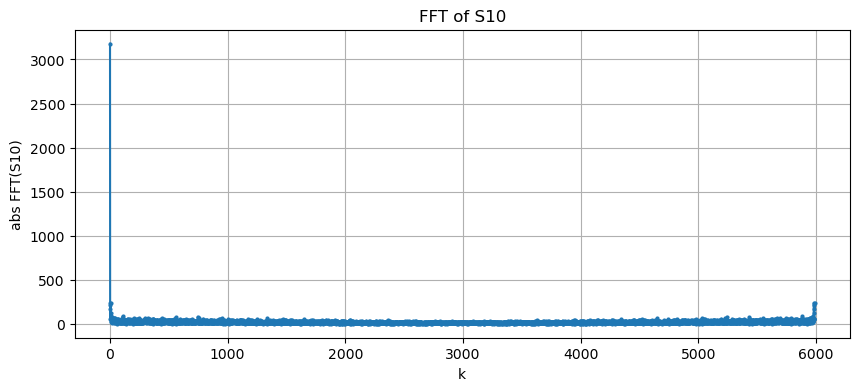

Top 10 frequencies for S10:
  k=0, abs FFT=3178.9596560846558
  k=5983, abs FFT=237.53178573897492
  k=7, abs FFT=237.53178573897492
  k=5989, abs FFT=229.9911501465283
  k=1, abs FFT=229.99115014652824
  k=3, abs FFT=215.280628044874
  k=5987, abs FFT=215.28062804487396
  k=2, abs FFT=168.0696972077088
  k=5988, abs FFT=168.06969720770877
  k=5984, abs FFT=119.5430623401398


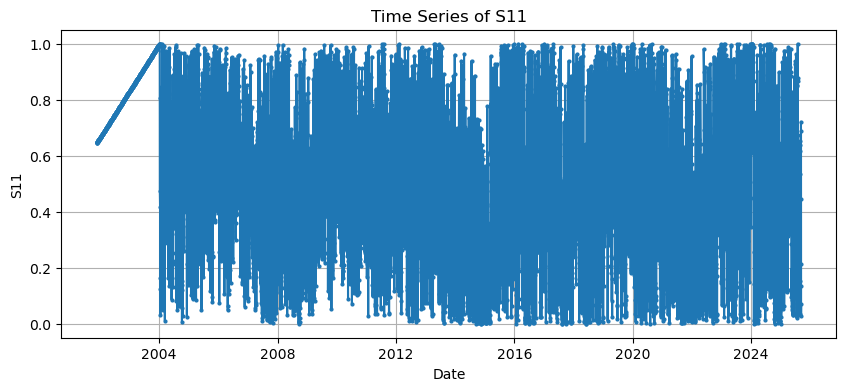

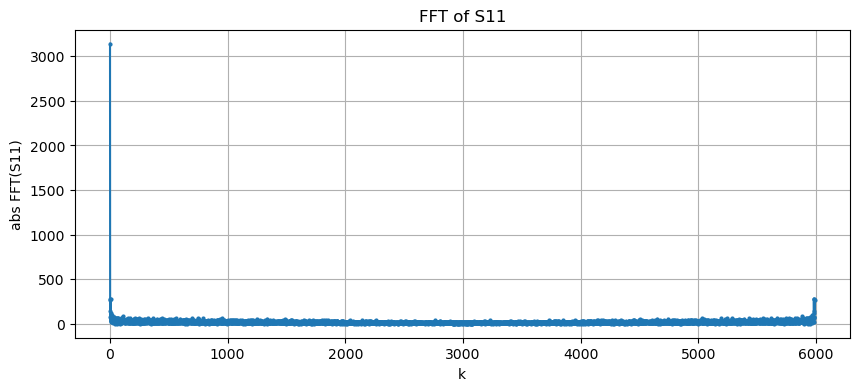

Top 10 frequencies for S11:
  k=0, abs FFT=3139.9920634920627
  k=7, abs FFT=281.9748609149839
  k=5983, abs FFT=281.9748609149838
  k=3, abs FFT=272.2201711804703
  k=5987, abs FFT=272.22017118047023
  k=1, abs FFT=260.84218370982666
  k=5989, abs FFT=260.84218370982666
  k=2, abs FFT=145.048267890607
  k=5988, abs FFT=145.04826789060695
  k=5984, abs FFT=119.4100351566929


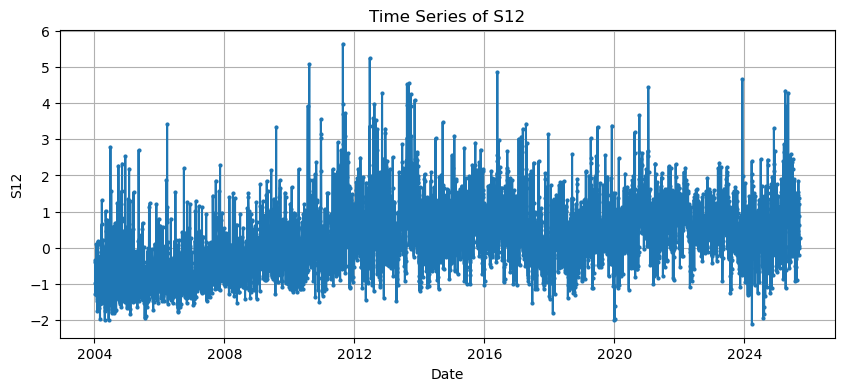

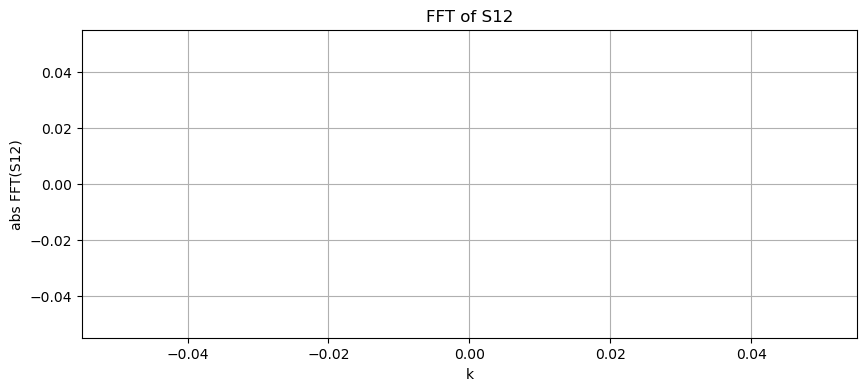

Top 10 frequencies for S12:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


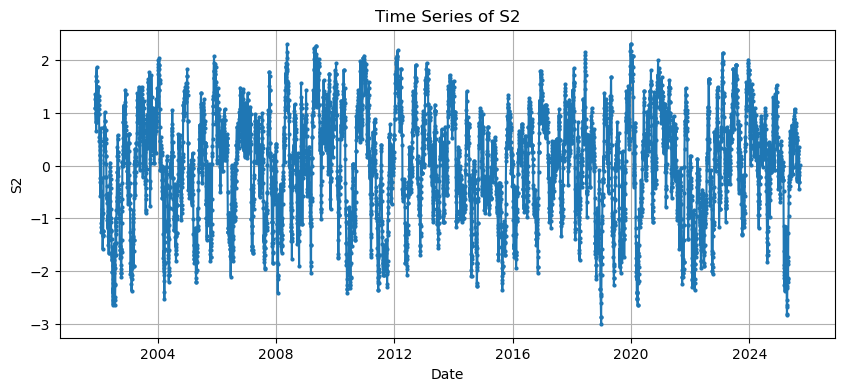

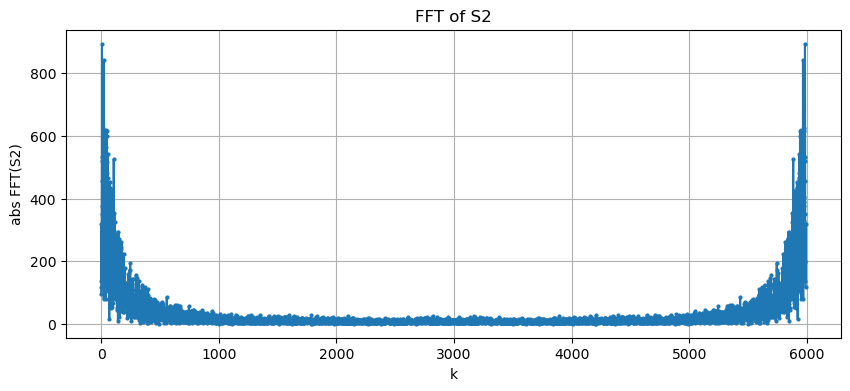

Top 10 frequencies for S2:
  k=5983, abs FFT=894.7670348164005
  k=7, abs FFT=894.7670348164004
  k=5966, abs FFT=842.767924578502
  k=24, abs FFT=842.767924578502
  k=16, abs FFT=626.4089128428418
  k=5974, abs FFT=626.4089128428416
  k=5946, abs FFT=618.4439347679303
  k=44, abs FFT=618.4439347679302
  k=49, abs FFT=617.2998431628835
  k=5941, abs FFT=617.2998431628835


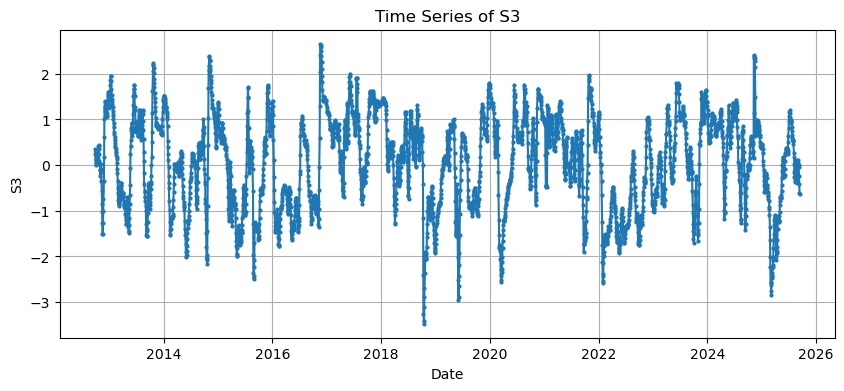

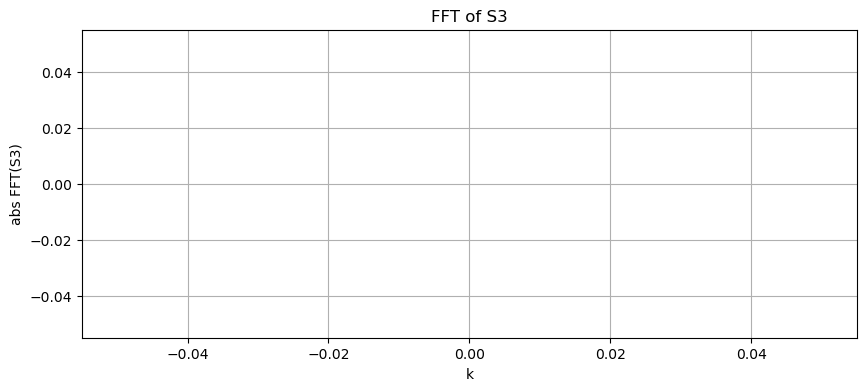

Top 10 frequencies for S3:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


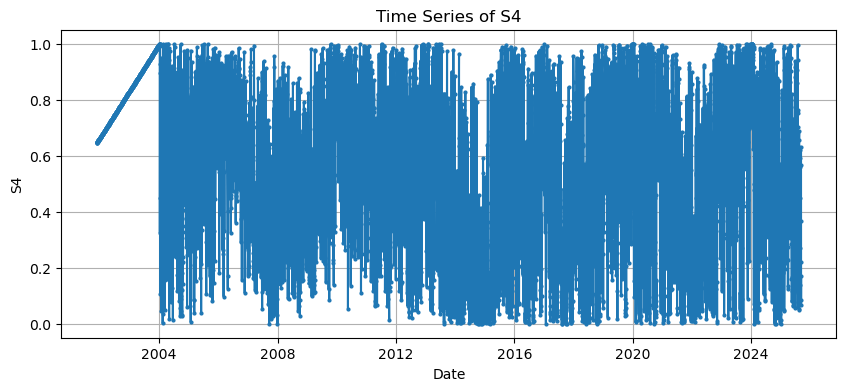

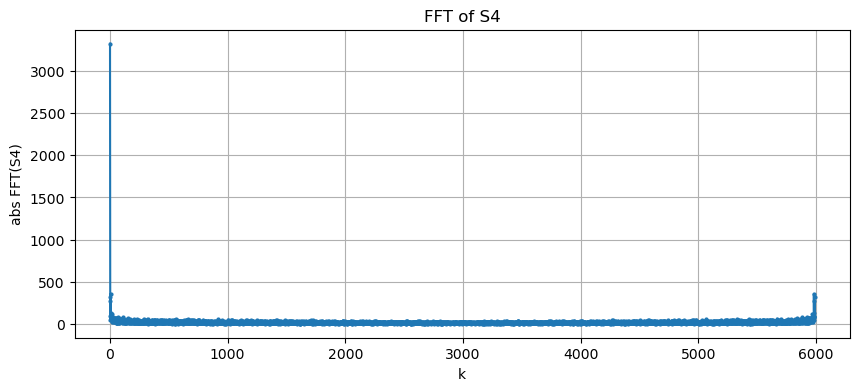

Top 10 frequencies for S4:
  k=0, abs FFT=3326.1299603174602
  k=5983, abs FFT=355.96200936541726
  k=7, abs FFT=355.9620093654172
  k=1, abs FFT=314.98944405398447
  k=5989, abs FFT=314.98944405398447
  k=5987, abs FFT=271.8171071129589
  k=3, abs FFT=271.8171071129589
  k=5984, abs FFT=132.70145849837925
  k=6, abs FFT=132.70145849837925
  k=20, abs FFT=114.3549972928216


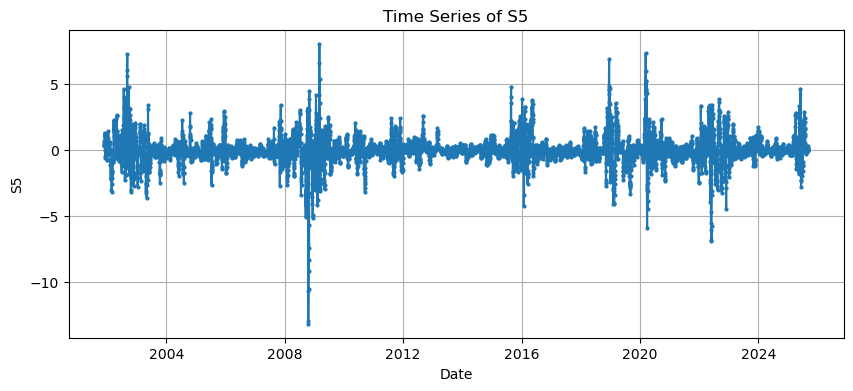

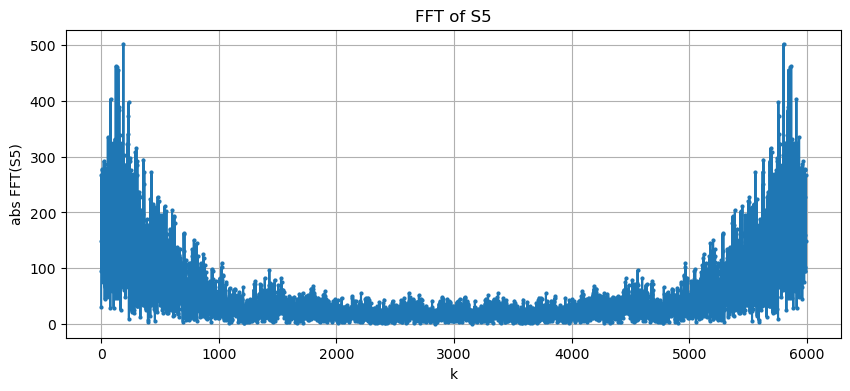

Top 10 frequencies for S5:
  k=5801, abs FFT=502.86800216045265
  k=189, abs FFT=502.8680021604526
  k=5866, abs FFT=462.4729574229269
  k=124, abs FFT=462.4729574229268
  k=5859, abs FFT=460.78830401471663
  k=131, abs FFT=460.78830401471646
  k=5843, abs FFT=456.4767378029317
  k=147, abs FFT=456.47673780293167
  k=80, abs FFT=403.8680696684625
  k=5910, abs FFT=403.86806966846245


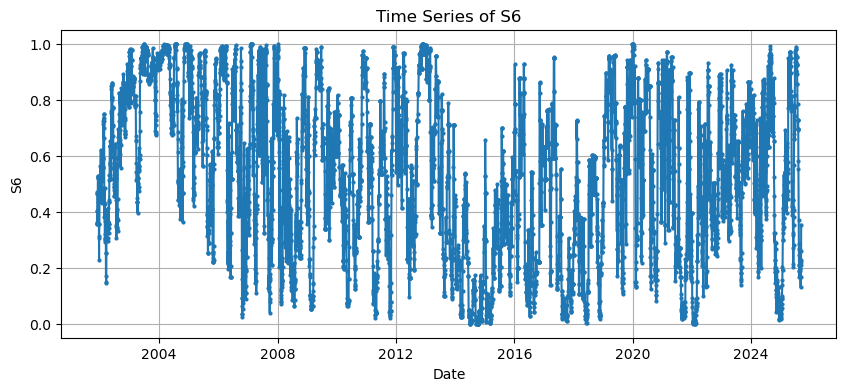

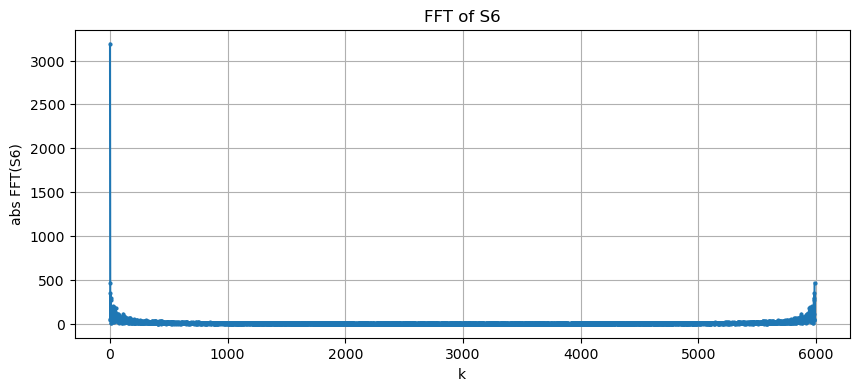

Top 10 frequencies for S6:
  k=0, abs FFT=3191.395833333333
  k=1, abs FFT=466.473427744156
  k=5989, abs FFT=466.473427744156
  k=3, abs FFT=350.93316169866335
  k=5987, abs FFT=350.93316169866335
  k=5983, abs FFT=291.81611429531245
  k=7, abs FFT=291.8161142953124
  k=5984, abs FFT=273.405178427315
  k=6, abs FFT=273.405178427315
  k=23, abs FFT=199.3624670164377


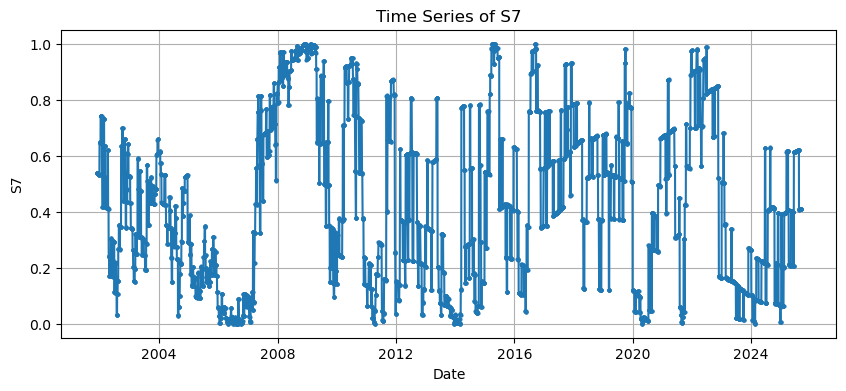

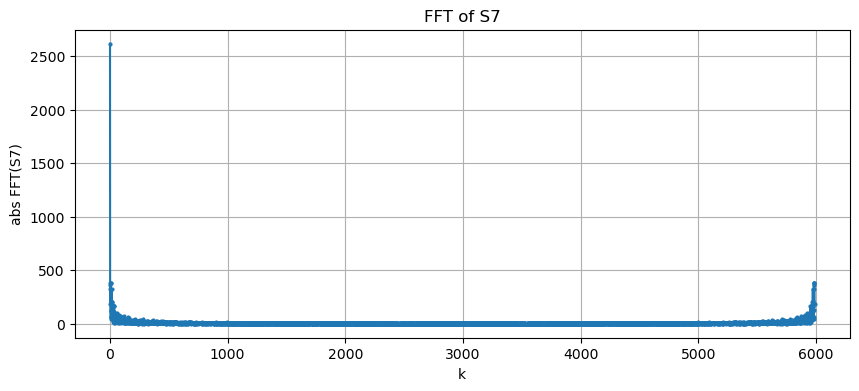

Top 10 frequencies for S7:
  k=0, abs FFT=2614.330357142857
  k=7, abs FFT=384.7842648824615
  k=5983, abs FFT=384.7842648824615
  k=5987, abs FFT=383.086693575392
  k=3, abs FFT=383.086693575392
  k=5, abs FFT=377.7224321338584
  k=5985, abs FFT=377.7224321338583
  k=4, abs FFT=365.65683724365374
  k=5986, abs FFT=365.65683724365374
  k=5988, abs FFT=326.53608479158476


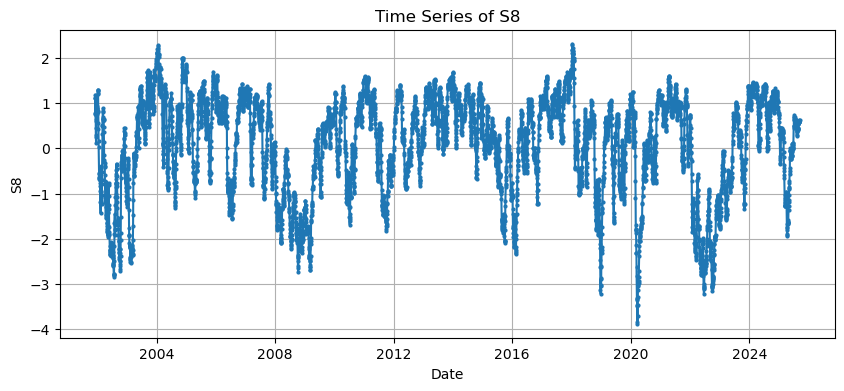

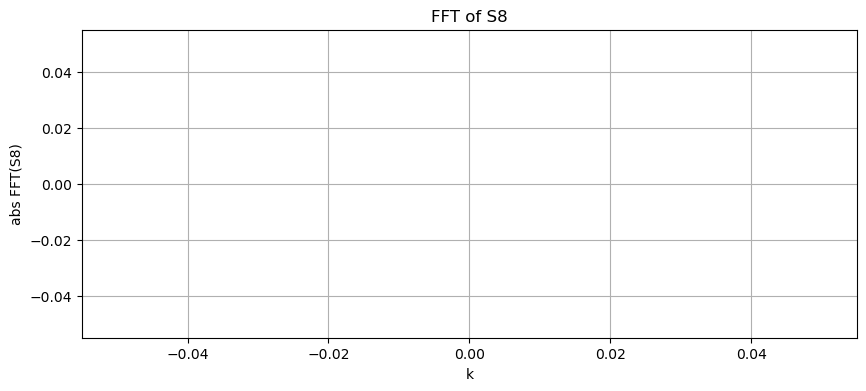

Top 10 frequencies for S8:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


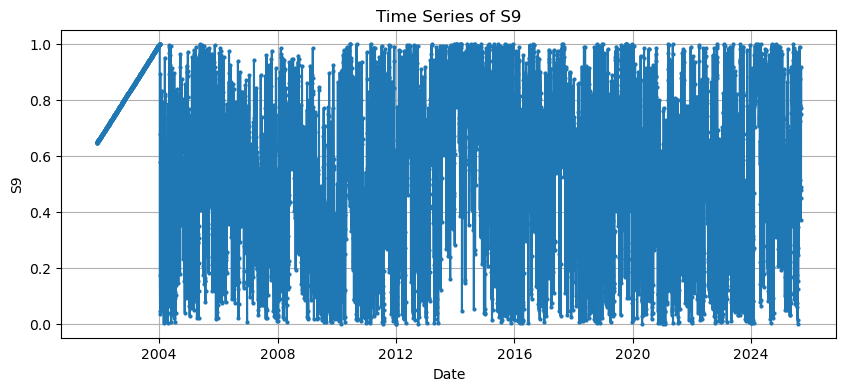

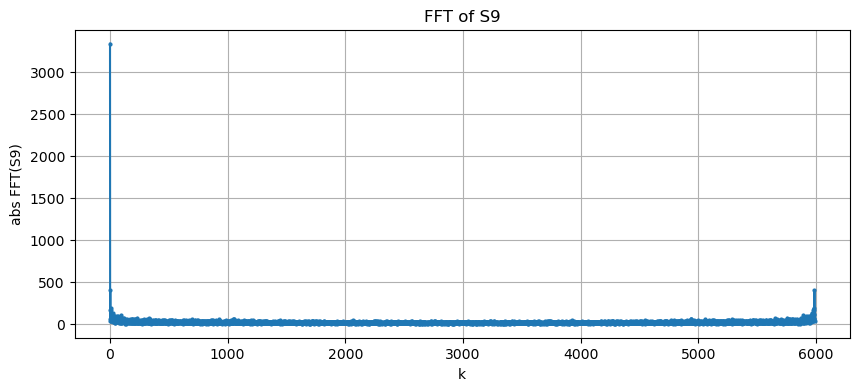

Top 10 frequencies for S9:
  k=0, abs FFT=3330.8260582010575
  k=2, abs FFT=396.2119454056826
  k=5988, abs FFT=396.21194540568257
  k=5981, abs FFT=183.4442112556423
  k=9, abs FFT=183.44421125564227
  k=4, abs FFT=160.3577346078684
  k=5986, abs FFT=160.3577346078684
  k=5980, abs FFT=158.39638512780076
  k=10, abs FFT=158.39638512780073
  k=24, abs FFT=130.22462240144378


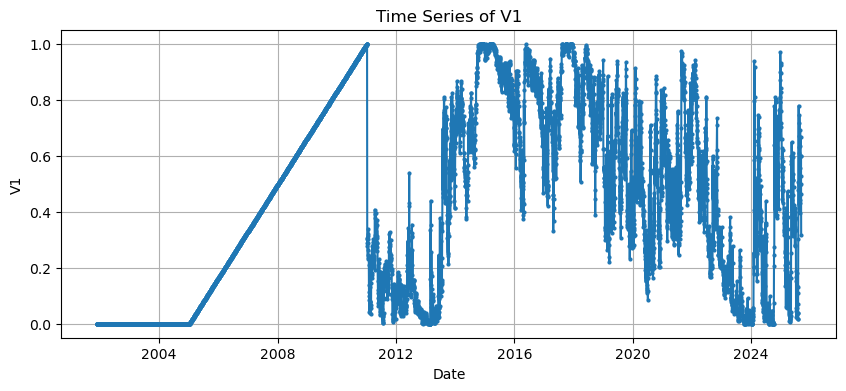

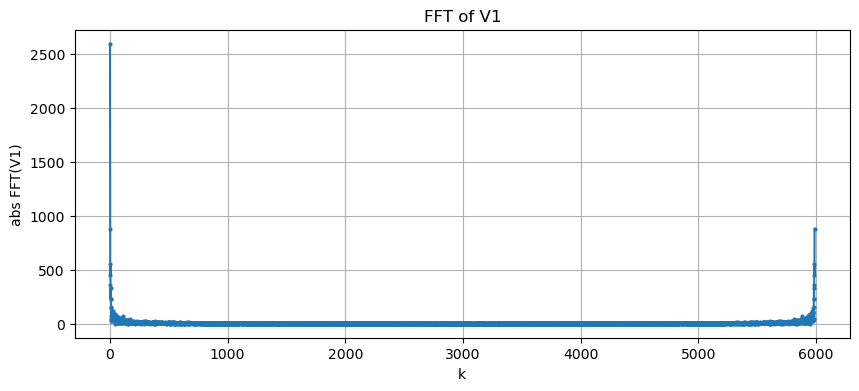

Top 10 frequencies for V1:
  k=0, abs FFT=2598.4325396825393
  k=5989, abs FFT=880.4927462539579
  k=1, abs FFT=880.4927462539578
  k=3, abs FFT=555.8156412533424
  k=5987, abs FFT=555.8156412533424
  k=2, abs FFT=449.6549970367754
  k=5988, abs FFT=449.6549970367753
  k=4, abs FFT=357.98655803747886
  k=5986, abs FFT=357.9865580374788
  k=6, abs FFT=327.3153425132844


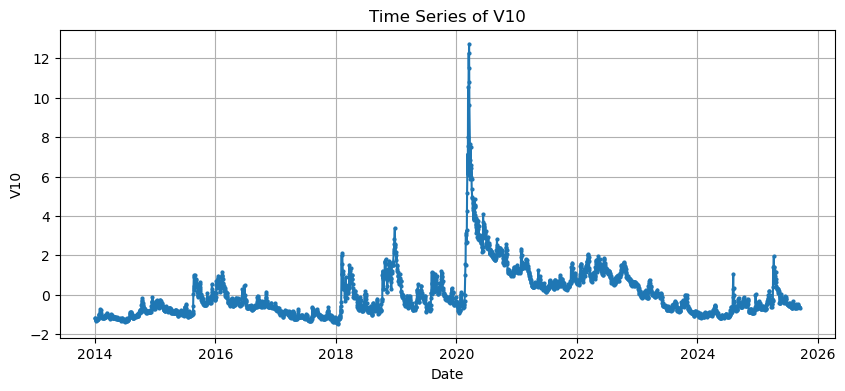

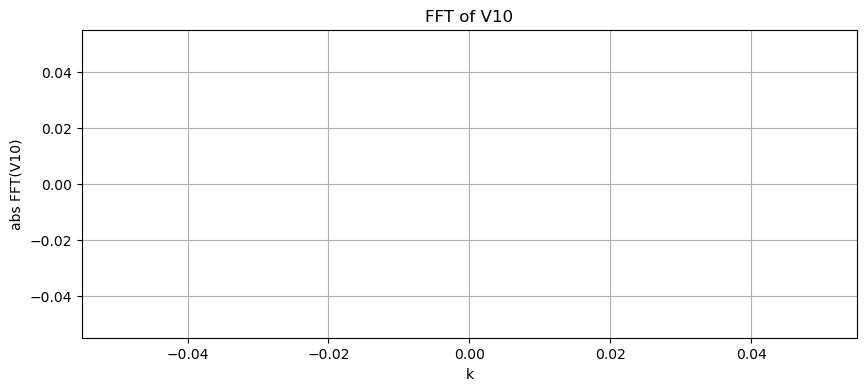

Top 10 frequencies for V10:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


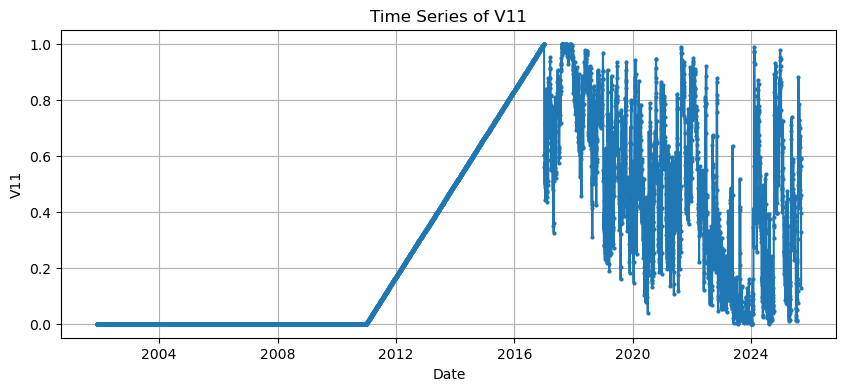

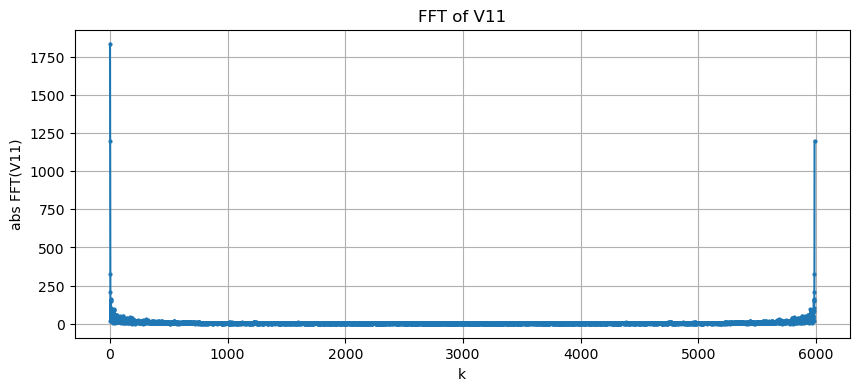

Top 10 frequencies for V11:
  k=0, abs FFT=1835.8528439153438
  k=1, abs FFT=1198.699030201183
  k=5989, abs FFT=1198.6990302011827
  k=2, abs FFT=326.38166607900473
  k=5988, abs FFT=326.3816660790047
  k=3, abs FFT=209.75054913507952
  k=5987, abs FFT=209.7505491350795
  k=5982, abs FFT=159.03775081660177
  k=8, abs FFT=159.03775081660174
  k=6, abs FFT=154.53612666088998


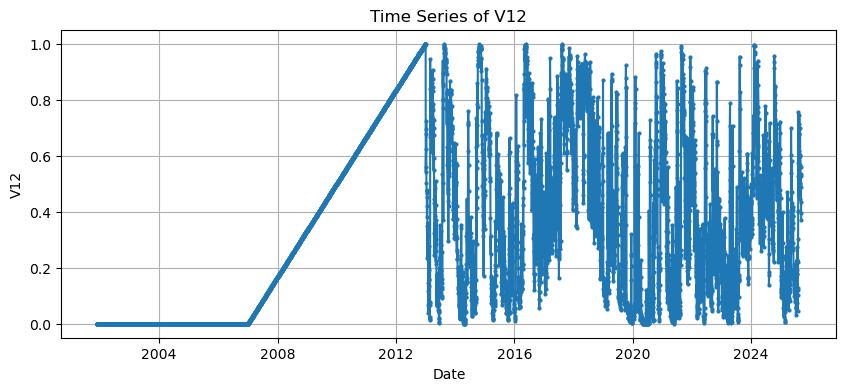

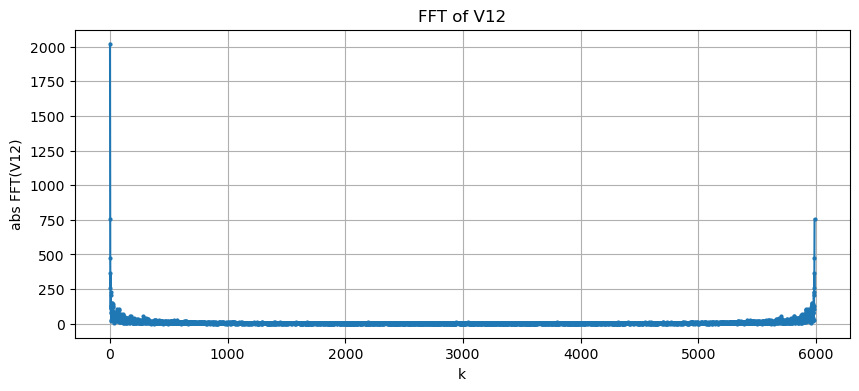

Top 10 frequencies for V12:
  k=0, abs FFT=2020.6269841269839
  k=1, abs FFT=752.7889520320508
  k=5989, abs FFT=752.7889520320507
  k=5988, abs FFT=472.75596401586654
  k=2, abs FFT=472.7559640158665
  k=5986, abs FFT=363.37414028268586
  k=4, abs FFT=363.3741402826858
  k=5987, abs FFT=260.69434836574055
  k=3, abs FFT=260.69434836574055
  k=8, abs FFT=228.95389782551743


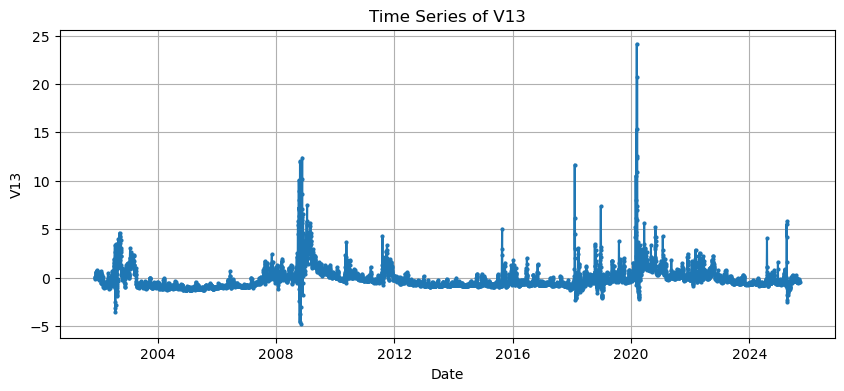

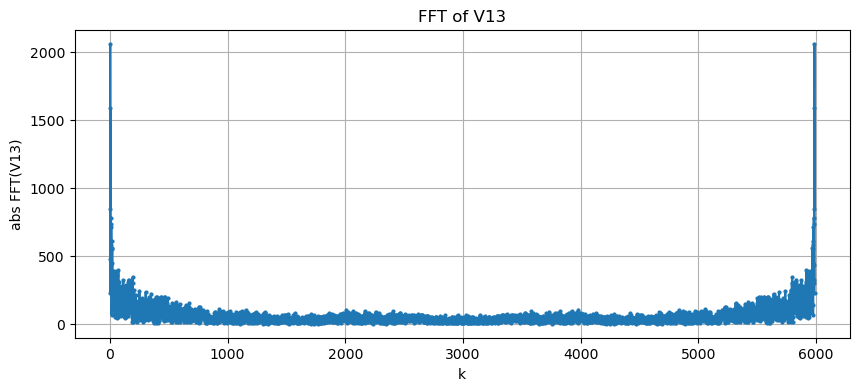

Top 10 frequencies for V13:
  k=2, abs FFT=2059.0653390236407
  k=5988, abs FFT=2059.0653390236403
  k=4, abs FFT=1585.9479112873473
  k=5986, abs FFT=1585.9479112873473
  k=5987, abs FFT=844.4180765201604
  k=3, abs FFT=844.4180765201604
  k=8, abs FFT=781.4469484076456
  k=5982, abs FFT=781.4469484076456
  k=5983, abs FFT=737.4522295350004
  k=7, abs FFT=737.4522295350004


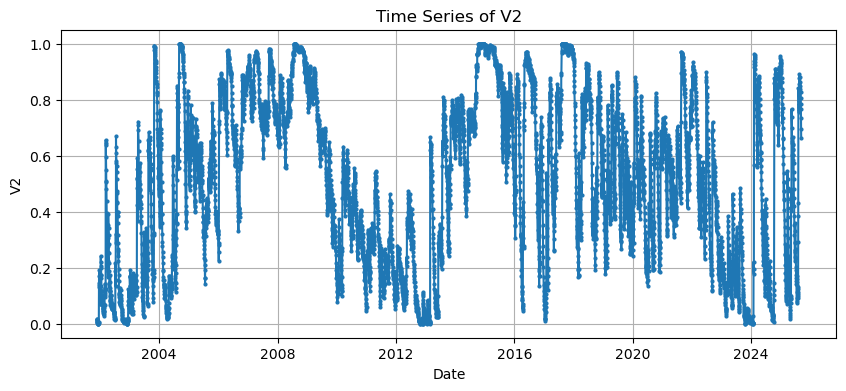

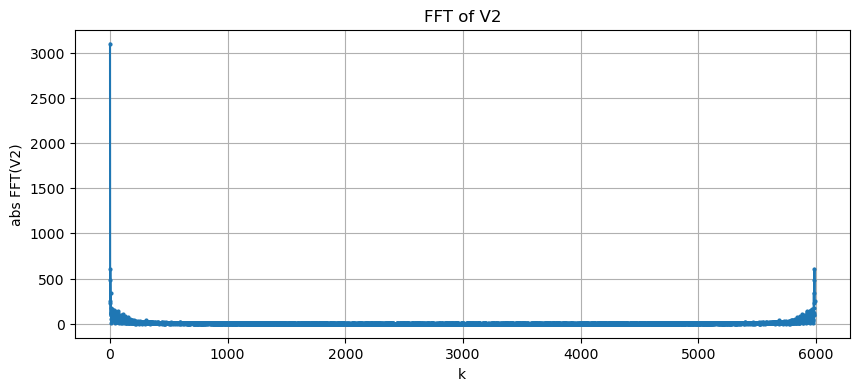

Top 10 frequencies for V2:
  k=0, abs FFT=3097.37037037037
  k=2, abs FFT=608.1735180124286
  k=5988, abs FFT=608.1735180124285
  k=5987, abs FFT=478.1548706080883
  k=3, abs FFT=478.15487060808823
  k=5983, abs FFT=340.41465594584594
  k=7, abs FFT=340.4146559458458
  k=1, abs FFT=250.47755840705327
  k=5989, abs FFT=250.47755840705312
  k=4, abs FFT=233.01946856704689


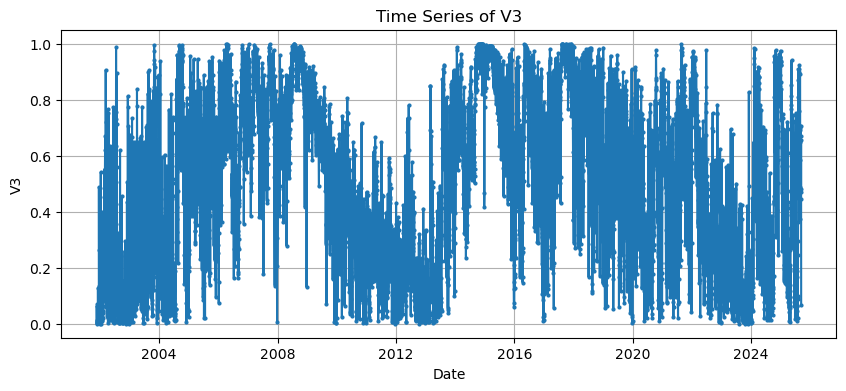

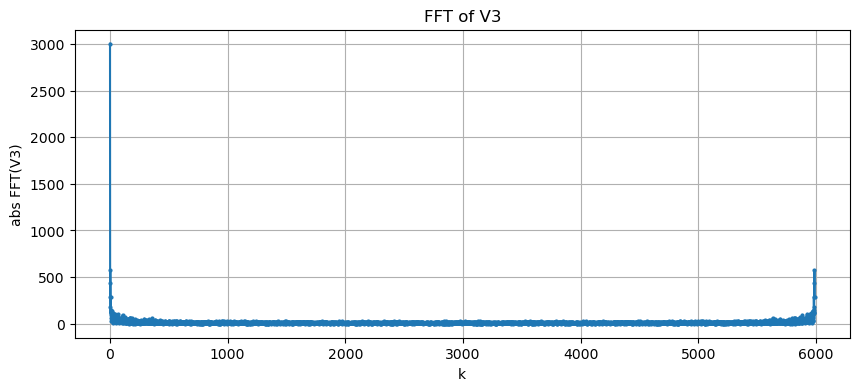

Top 10 frequencies for V3:
  k=0, abs FFT=3002.155092592592
  k=5988, abs FFT=575.1909068629775
  k=2, abs FFT=575.1909068629775
  k=3, abs FFT=442.14432923673286
  k=5987, abs FFT=442.14432923673286
  k=5983, abs FFT=289.25248438256114
  k=7, abs FFT=289.2524843825611
  k=1, abs FFT=283.27773925208226
  k=5989, abs FFT=283.27773925208226
  k=4, abs FFT=183.1974951531817


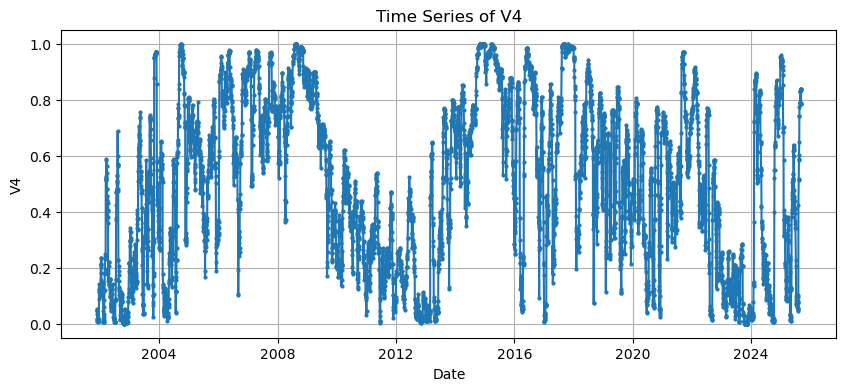

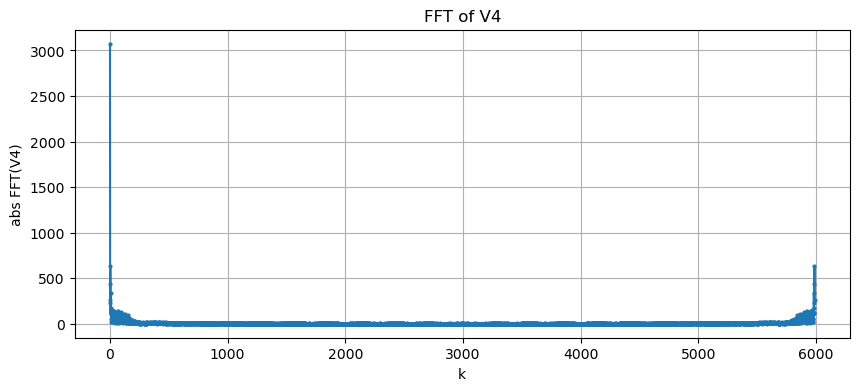

Top 10 frequencies for V4:
  k=0, abs FFT=3073.710317460317
  k=2, abs FFT=632.3750220597165
  k=5988, abs FFT=632.3750220597162
  k=5987, abs FFT=436.51925971503675
  k=3, abs FFT=436.51925971503675
  k=5983, abs FFT=335.96785515455616
  k=7, abs FFT=335.9678551545561
  k=1, abs FFT=259.5490988875287
  k=5989, abs FFT=259.5490988875286
  k=4, abs FFT=230.77975329334438


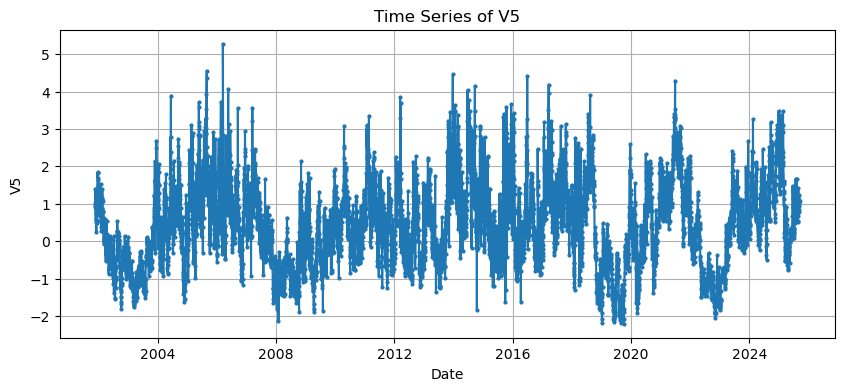

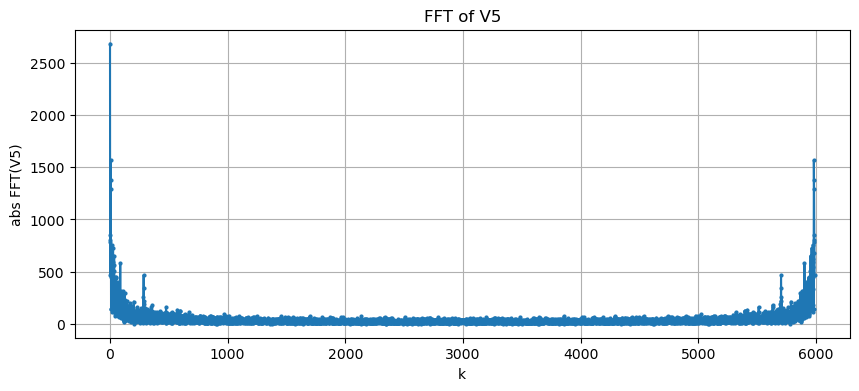

Top 10 frequencies for V5:
  k=0, abs FFT=2684.5873433659517
  k=7, abs FFT=1568.4413581175472
  k=5983, abs FFT=1568.441358117547
  k=5984, abs FFT=1380.198659880989
  k=6, abs FFT=1380.1986598809888
  k=5985, abs FFT=1295.3780647157598
  k=5, abs FFT=1295.3780647157594
  k=4, abs FFT=851.3132264869365
  k=5986, abs FFT=851.3132264869363
  k=3, abs FFT=803.2707523511705


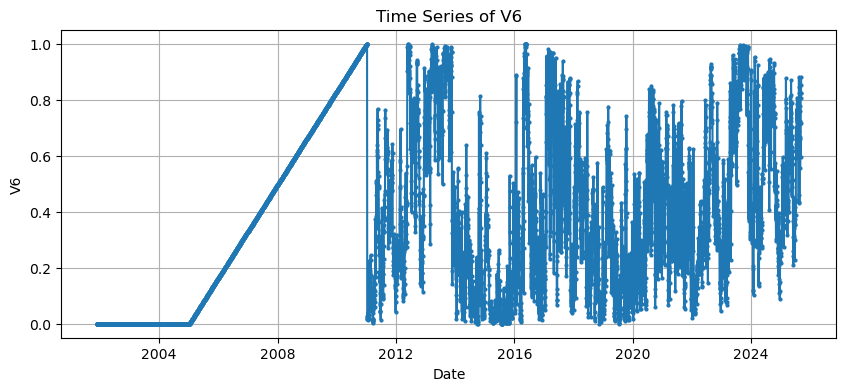

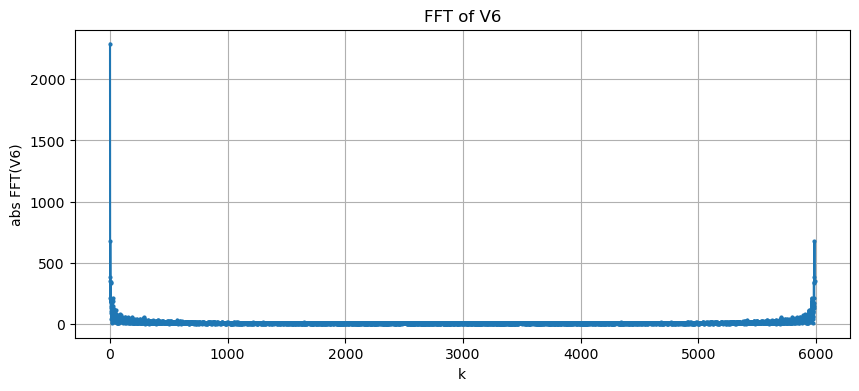

Top 10 frequencies for V6:
  k=0, abs FFT=2291.5145502645496
  k=5988, abs FFT=673.1163988400459
  k=2, abs FFT=673.1163988400459
  k=5987, abs FFT=380.4040752679894
  k=3, abs FFT=380.4040752679894
  k=1, abs FFT=350.78060397172356
  k=5989, abs FFT=350.78060397172345
  k=6, abs FFT=339.4182140167071
  k=5984, abs FFT=339.41821401670705
  k=7, abs FFT=332.3387397178517


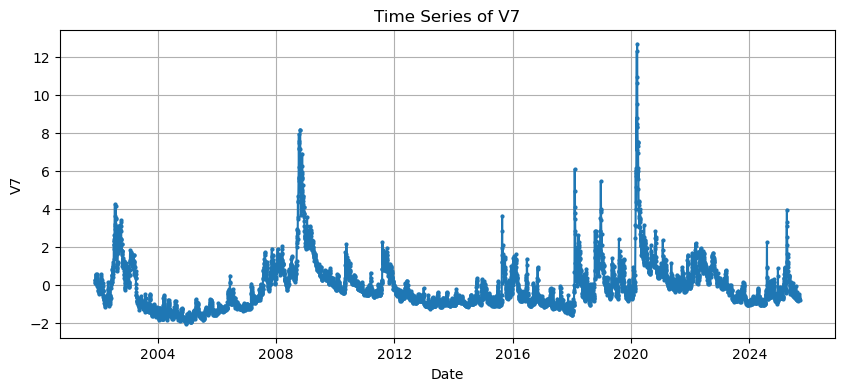

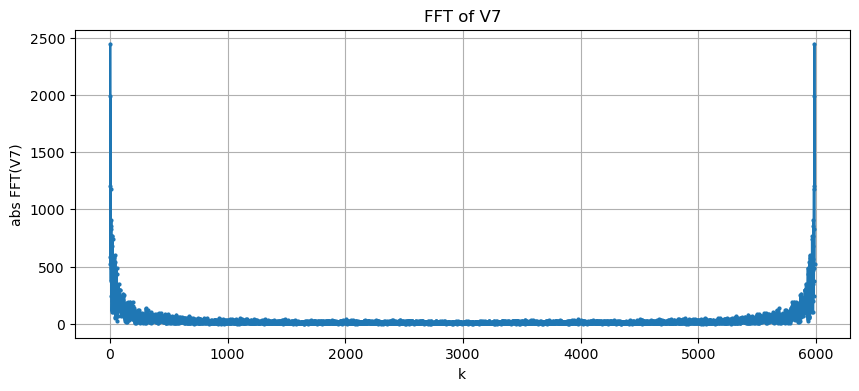

Top 10 frequencies for V7:
  k=2, abs FFT=2448.569383671791
  k=5988, abs FFT=2448.5693836717905
  k=5986, abs FFT=1992.2525828640828
  k=4, abs FFT=1992.2525828640828
  k=3, abs FFT=1207.322514384912
  k=5987, abs FFT=1207.3225143849118
  k=5983, abs FFT=1181.1108232959812
  k=7, abs FFT=1181.1108232959812
  k=12, abs FFT=902.8033679908657
  k=5978, abs FFT=902.8033679908655


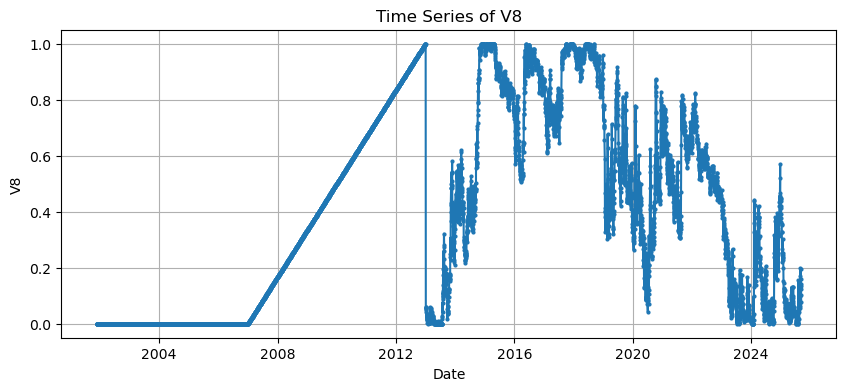

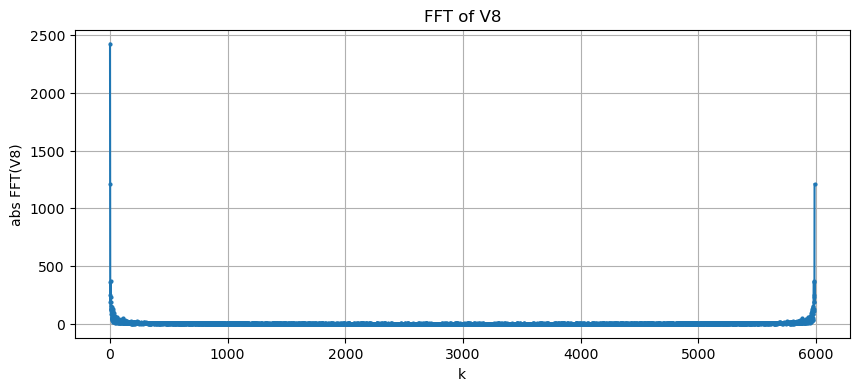

Top 10 frequencies for V8:
  k=0, abs FFT=2425.0796957671955
  k=1, abs FFT=1209.2507158150481
  k=5989, abs FFT=1209.250715815048
  k=5983, abs FFT=369.6348476416348
  k=7, abs FFT=369.6348476416348
  k=5986, abs FFT=362.9566226379722
  k=4, abs FFT=362.9566226379722
  k=5987, abs FFT=251.49320402814368
  k=3, abs FFT=251.4932040281436
  k=5982, abs FFT=230.87202460775828


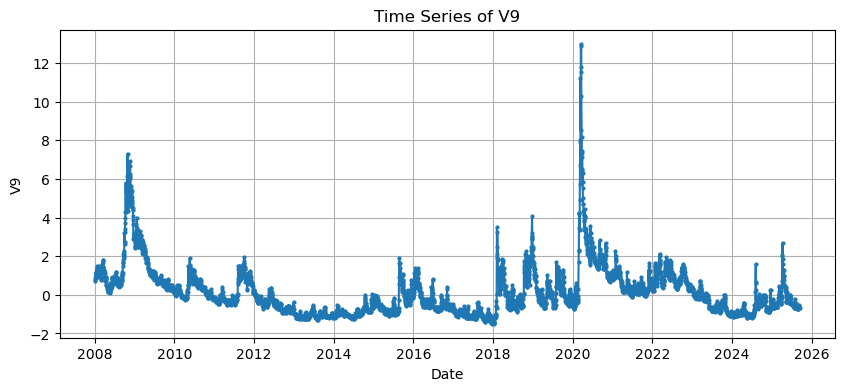

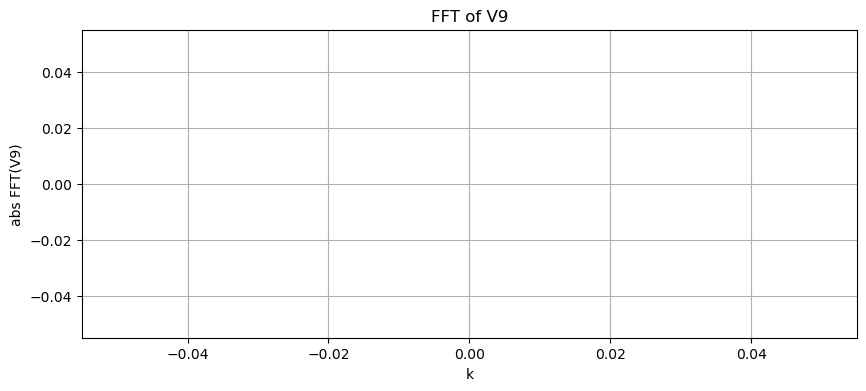

Top 10 frequencies for V9:
  k=1990, abs FFT=nan
  k=1991, abs FFT=nan
  k=1992, abs FFT=nan
  k=1993, abs FFT=nan
  k=1994, abs FFT=nan
  k=1995, abs FFT=nan
  k=1996, abs FFT=nan
  k=1997, abs FFT=nan
  k=1998, abs FFT=nan
  k=1999, abs FFT=nan


In [52]:
#visualize the resultprint("\n--- Training Data with Dates Shape ---")
import numpy as np
import scipy

import matplotlib.pyplot as plt
plotfeatures = ["M16","M18"]
plotfeatures = anonymous_features
for fs in plotfeatures:
    plt.figure(figsize=(10, 4))
    plt.plot(df_train_with_dates.select("Date").to_pandas(), df_train_with_dates.select(fs).to_pandas(), marker='o', linestyle='-', markersize=2)
    plt.title(f"Time Series of {fs}")
    plt.xlabel("Date")
    plt.ylabel(fs)
    plt.grid()
    plt.show()
    # plot fourier transform
    plt.figure(figsize=(10, 4))
    freqdata = np.fft.fft(df_train_with_dates.select(fs).to_numpy().flatten())
    freqdata = np.abs(freqdata)
    #print(freqdata[1:10])
    plt.plot(freqdata, marker='o', linestyle='-', markersize=2)
    plt.title(f"FFT of {fs}")
    plt.xlabel("k")
    plt.ylabel(f"abs FFT({fs})")
    plt.grid()
    plt.show()
    # print 10 highest frequencies
    freq_indices = np.argsort(freqdata)[-10:][::-1]
    print(f"Top 10 frequencies for {fs}:")
    for idx in freq_indices:
        print(f"  k={idx}, abs FFT={freqdata[idx]}")

## Part 3: Merge All Data Sources

Now we combine everything into one master dataframe. We'll use the `df_train_with_dates` as our base, then join the Yahoo and FRED data to it.

We must **forward-fill** the FRED data, as it's reported on all days (including weekends) or only when it changes (like `FED_FUNDS`). Forward-filling applies the last known value to the trading days.

In [20]:

# Join all dataframes
df_merged = df_train_with_dates.join(public_data, on="Date", how="left")

# Forward-fill nulls in public data (especially for FRED data)
public_feature_cols = list(YFINANCE_TICKERS.keys()) + list(FRED_SERIES.keys())
#public_feature_cols = [f"{col}_Close" if col in YFINANCE_TICKERS.values() else col for col in public_feature_cols]
public_feature_cols = public_data.columns[1:]  # Exclude 'Date' column

# df_merged = df_merged.with_columns(
#     pl.col(public_feature_cols).forward_fill()
# )

# Drop any remaining nulls (e.g., at the very start of the history)
df_merged = df_merged.drop_nulls().drop_nans()

print("Master dataframe created. Shape:", df_merged.shape)
print(df_merged.tail())
df_numeric_features = df_merged.select([pl.selectors.numeric()])
print(f"\nNumeric features dataframe shape: {df_numeric_features.shape}")

Master dataframe created. Shape: (2021, 128)
shape: (5, 128)
┌─────────┬─────┬─────┬─────┬───┬──────────┬───────────┬────────────────┬───────────────┐
│ date_id ┆ D1  ┆ D2  ┆ D3  ┆ … ┆ I_T10Y2Y ┆ S_UMCSENT ┆ S_BAMLH0A0HYM2 ┆ S_EMVMACROBUS │
│ ---     ┆ --- ┆ --- ┆ --- ┆   ┆ ---      ┆ ---       ┆ ---            ┆ ---           │
│ i64     ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64      ┆ f64       ┆ f64            ┆ f64           │
╞═════════╪═════╪═════╪═════╪═══╪══════════╪═══════════╪════════════════╪═══════════════╡
│ 8985    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.59     ┆ 58.2      ┆ 2.83           ┆ 0.0           │
│ 8986    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.56     ┆ 58.2      ┆ 2.84           ┆ 0.0           │
│ 8987    ┆ 0   ┆ 0   ┆ 1   ┆ … ┆ 0.54     ┆ 58.2      ┆ 2.87           ┆ 0.0           │
│ 8988    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.5      ┆ 58.2      ┆ 2.84           ┆ 0.0           │
│ 8989    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.49     ┆ 58.2      ┆ 2.78           ┆ 0.0           │
└─────────┴─────┴─────┴─────┴───┴──────

In [41]:
#visualize the resultprint("\n--- Training Data with Dates Shape ---")
print(df_merged.shape)
print("\n--- Training Data with Dates Head ---")
print(df_merged.head())
import matplotlib.pyplot as plt
plotfeatures = ["M16","M18"]
plotfeatures = anonymous_features
for fs in plotfeatures:
    break
    plt.figure(figsize=(6, 4))
    plt.plot(df_merged.select("Date").to_pandas(), df_merged.select(fs).to_pandas(), marker='o', linestyle='-', markersize=2)
    plt.title(f"Time Series of {fs}")
    plt.xlabel("Date")
    plt.ylabel(fs)
    plt.grid()
    plt.show()

(2021, 128)

--- Training Data with Dates Head ---
shape: (5, 128)
┌─────────┬─────┬─────┬─────┬───┬──────────┬───────────┬────────────────┬───────────────┐
│ date_id ┆ D1  ┆ D2  ┆ D3  ┆ … ┆ I_T10Y2Y ┆ S_UMCSENT ┆ S_BAMLH0A0HYM2 ┆ S_EMVMACROBUS │
│ ---     ┆ --- ┆ --- ┆ --- ┆   ┆ ---      ┆ ---       ┆ ---            ┆ ---           │
│ i64     ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64      ┆ f64       ┆ f64            ┆ f64           │
╞═════════╪═════╪═════╪═════╪═══╪══════════╪═══════════╪════════════════╪═══════════════╡
│ 6969    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.83     ┆ 96.8      ┆ 3.88           ┆ 0.47176       │
│ 6970    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.8      ┆ 96.8      ┆ 3.9            ┆ 0.47176       │
│ 6971    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.82     ┆ 96.8      ┆ 3.86           ┆ 0.47176       │
│ 6972    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.79     ┆ 96.8      ┆ 3.85           ┆ 0.47176       │
│ 6973    ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ 0.81     ┆ 95.1      ┆ 3.82           ┆ 0.17242       │
└─────────┴─────┴─────┴─────┴───┴

## Part 4: Calculate and Display Correlations

Finally, we calculate the correlation matrix. To make it easy to read, we won't print the whole matrix. Instead, we'll:

1.  Isolate the correlations between *anonymous* and *public* features.
2.  "Melt" the matrix into a long list: `(anonymous_feature, public_feature, correlation)`.
3.  Sort by the **absolute correlation value** to find the strongest relationships (both positive and negative).

In [23]:

# Define our two feature groups
public_features = public_feature_cols
#anonymous_features = [col for col in df_numeric_features.columns if col not in public_features and any(col.startswith(p) for p in ['M', 'E', 'I', 'P', 'V', 'S', 'D', 'MOM'])]

all_features = anonymous_features + public_features

print(f"\nAnonymous features ({len(anonymous_features)}): {anonymous_features}")
print(f"Public features ({len(public_features)}): {public_features}")

print(f"Correlating {len(anonymous_features)} anonymous features with {len(public_features)} public features...")

# Calculate the full correlation matrix for our subset of columns
corr_matrix = df_merged.select(anonymous_features + public_features).corr()

# *** START OF FIX ***

# Manually add the feature names as a new column
# This is the column we will filter on.
corr_matrix_with_labels = corr_matrix.with_columns(
    pl.Series("anonymous_feature", all_features)
)

# Filter the matrix to only show (Anonymous Rows x Public Columns)
corr_subset = corr_matrix_with_labels.filter(
    pl.col("anonymous_feature").is_in(anonymous_features)
).select(
    ["anonymous_feature"] + public_features  # Use the new column name
)

# Melt the matrix to a long format for easy sorting
corr_long = corr_subset.unpivot(
    index="anonymous_feature",  # Use the new column name
    variable_name="public_feature", 
    value_name="correlation"
)

# *** END OF FIX ***

# Sort by absolute correlation to find strongest links
corr_sorted = corr_long.with_columns(
    pl.col("correlation").abs().alias("abs_correlation")
).sort("abs_correlation", descending=True)

Notable_features = ['V13', 'M1', 'S5', 'M4']
for x in Notable_features:
    print(corr_sorted.filter(pl.col("anonymous_feature") == x).head(10))

print("\n--- Top 100 Most Correlated Feature Pairs --- (Positive or Negative)")
with pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000, tbl_rows=1000):
    print(corr_sorted.head(100))

    print("\n--- Top 10 Positive Correlations ---")
    print(corr_sorted.sort("correlation", descending=True).head(20))

    print("\n--- Top 10 Negative Correlations ---")
    print(corr_sorted.sort("correlation", descending=False).head(20))




Anonymous features (94): ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
Public features (29): ['S_BTC-USD', 'P_CL=F', 'P_GC=F', 'P_HG=F', 'P_SI=F', 'M_DJI', 'I_FVX', 'M_GSPC', 'M_IXIC', 'M_RUT', 'I_TNX', 'I_TYX', 'V_VIX', 'V_VIX3M', 'E_GDP', 'E_UNRATE', 'E_CPIAUCSL', 'E_PPIACO', 'E_INDPRO', 'E_PAYEMS', 'E_ICSA', 'I_DFF', 'I_DTB3', 'I_DGS2', 'I_DGS10', 'I_T10Y2Y', 'S_UMCSENT', 'S_BAMLH0A0HYM2', 'S_EMVMACROBUS']
Correlating 94 anonymous features wi

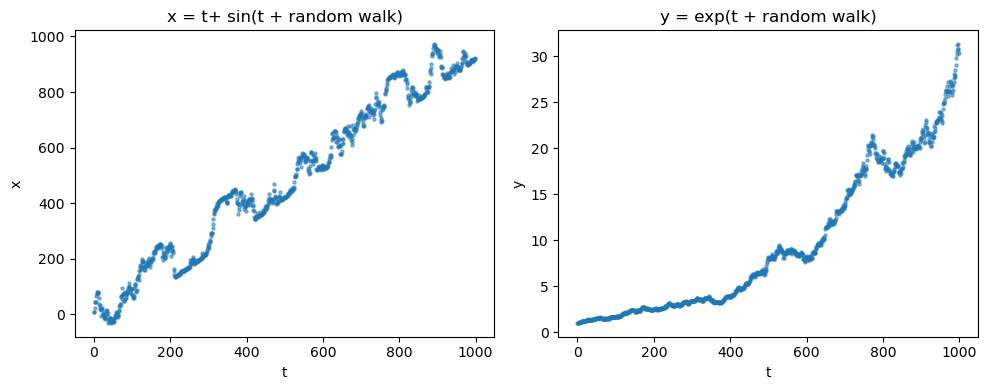

Correlation between x and y: 0.935226

Details:
Number of time points: 1000
x = t + noise (normal)
y = -t + noise (normal)

Expected correlation: close to -1 (since x increases with t, y decreases with t)


In [38]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of time points
n = 1000

# Generate time points
t = np.arange(n)

# Generate normal noise
noise_x = np.random.normal(0, 10, n)
noise_y = np.random.normal(0, 10, n)

# Create x and y
x = t + 80*np.sin((t+np.cumsum(noise_x))/50)
y = np.exp((t+np.cumsum(noise_y))/500)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(t, x, s=5, alpha=0.5)
plt.title("x = t+ sin(t + random walk)")
plt.xlabel("t")
plt.ylabel("x")
plt.subplot(1, 2, 2)
plt.scatter(t, y, s=5, alpha=0.5)
plt.title("y = exp(t + random walk)")
plt.xlabel("t")
plt.ylabel("y")
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = np.corrcoef(x, y)[0, 1]

print(f"Correlation between x and y: {correlation:.6f}")
print(f"\nDetails:")
print(f"Number of time points: {n}")
print(f"x = t + noise (normal)")
print(f"y = -t + noise (normal)")
print(f"\nExpected correlation: close to -1 (since x increases with t, y decreases with t)")